## dataset link

https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

In [1]:
from os import listdir
from numpy import asarray,vstack,load,savez_compressed,ones,zeros
from numpy.random import randint
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D,LeakyReLU,Activation,Conv2DTranspose,Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras import Input
import PIL
from matplotlib import pyplot
from random import random

In [2]:
def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

In [6]:
# dataset pathy
path="D://college-lessons//MA//FIU//AI-workshop//notebooks//GAN//horse2zebra//"

dataA1 = load_images(path + "trainA/")
dataAB = load_images(path + "testA/")
dataA = vstack((dataA1, dataAB))
print("Loaded dataA: ", dataA.shape)
# load dataset B
dataB1 = load_images(path + "trainB/")
dataB2 = load_images(path + "testB/")
dataB = vstack((dataB1, dataB2))
print("Loaded dataB: ", dataB.shape)
# save as compressed numpy array
filename = "horse2zebra_256.npz"
savez_compressed(filename, dataA, dataB)
print("Saved dataset: ", filename)

Loaded dataA:  (1187, 256, 256, 3)
Loaded dataB:  (1474, 256, 256, 3)
Saved dataset:  horse2zebra_256.npz


Loaded:  (1187, 256, 256, 3) (1474, 256, 256, 3)


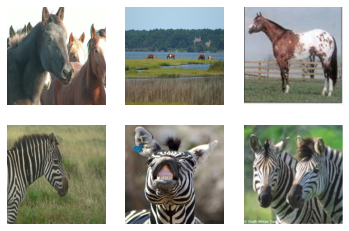

In [7]:
# load and plot the prepared dataset

# load the dace dataset
data=load("horse2zebra_256.npz")
dataA,dataB=data["arr_0"],data["arr_1"]
print("Loaded: ",dataA.shape,dataB.shape)

# plot source images
n_samples=3
for i in range(n_samples):
    pyplot.subplot(2,n_samples,i+1)
    pyplot.axis("off")
    pyplot.imshow(dataA[i].astype("uint8"))


# plot target image
for i in range(n_samples):
    pyplot.subplot(2,n_samples,i+n_samples+1)
    pyplot.axis("off")
    pyplot.imshow(dataB[i].astype("uint8"))

In [24]:
# define the discriminator model
def define_discriminator(image_shape):
    print("Discriminator model")
    # weight initialization
    init=RandomNormal(stddev=0.02)

    
    # source image input
    in_image=Input(shape=image_shape)
    print("Discriminator input image shape: ", in_image.shape)
    # C64
    d=Conv2D(64,(4,4),strides=(2,2),padding="same",kernel_initializer=init)(in_image)
    d=LeakyReLU(alpha=0.2)(d)

    # C128
    d=Conv2D(128,(4,4),strides=(2,2),padding="same",kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)

    # C256
    d=Conv2D(256,(4,4),strides=(2,2),padding="same",kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)

    # C512
    d=Conv2D(512,(4,4),strides=(2,2),padding="same",kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d=Conv2D(512,(4,4),padding="same",kernel_initializer=init)(d)
    d=InstanceNormalization(axis=-1)(d)
    d=LeakyReLU(alpha=0.2)(d)

    # patch output
    patch_out=Conv2D(1,(4,4),padding="same",kernel_initializer=init)(d)

    # define model
    model=Model(in_image,patch_out)

    # compile model
    model.compile(loss="mse",optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    model.summary()
    return model

In [25]:
# generator a resnet
def resnet_block(n_filters,input_layer):
    # weight initialization
    init=RandomNormal(stddev=0.02)

    # first convolutional layer
    g=Conv2D(n_filters,(3,3),padding="same",kernel_initializer=init)(input_layer)
    g=InstanceNormalization(axis=-1)(g)
    g=Activation("relu")(g)

    # second convolutuonal layer
    g=Conv2D(n_filters,(3,3),padding="same",kernel_initializer=init)(g)
    g=InstanceNormalization(axis=-1)(g)

    # concatenate merge channel-wise with input layer
    g=Concatenate()([g,input_layer])
    return g

In [28]:
# define the standalone generator
def define_generator(image_shape,n_resnet=9):
    print("Generator model")
    # weight initialization 
    init=RandomNormal(stddev=0.02)

    # image input
    in_image=Input(shape=image_shape)
    print("Generator input image shape: ", in_image.shape)

    # c7s1-64
    g=Conv2D(64,(7,7),padding="same",kernel_initializer=init)(in_image)
    g=InstanceNormalization(axis=-1)(g)
    g=Activation("relu")(g)

    # d128
    g=Conv2D(128,(3,3),strides=(2,2),padding="same",kernel_initializer=init)(g)
    g=InstanceNormalization(axis=-1)(g)
    g=Activation("relu")(g)

    # d256
    g=Conv2D(256,(3,3),strides=(2,2),padding="same",kernel_initializer=init)(g)
    g=InstanceNormalization(axis=-1)(g)
    g=Activation("relu")(g)
    
    
    # R256
    print("Resnet_block model")
    for _ in range(n_resnet):
        g=resnet_block(256,g)

    # u64
    g=Conv2DTranspose(128,(3,3),strides=(2,2),padding="same",kernel_initializer=init)(g)
    g=InstanceNormalization(axis=-1)(g)
    g=Activation("relu")(g)

    # c7s1-3
    g=Conv2D(3,(7,7),padding="same",kernel_initializer=init)(g)
    g=InstanceNormalization(axis=-1)(g)
    out_image=Activation("tanh")(g)

    # define model
    model=Model(in_image,out_image)
    model.summary()
    return model

In [12]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1,d_model,g_model_2,image_shape):

    # ensure the model we are updating is trainable
    g_model_1.trainable=True

    # mark discriminator as not trainable
    d_model.trainable=False

    # mark other generator model as not trainable
    g_model_2.trainable=False

    # discriminator element
    input_gen=Input(shape=image_shape)
    gen1_out=g_model_1(input_gen)
    output_d=d_model(gen1_out)

    # identity element
    input_id=Input(shape=image_shape)
    output_id=g_model_1(input_id)

    # forward cycle
    output_f=g_model_2(gen1_out)

    # backward cycle
    gen2_out=g_model_2(input_id)
    output_b=g_model_1(gen2_out)

    # define model graph
    model=Model([input_gen,input_id],[output_d,output_id,output_f,output_b])

    # define optimization algorithm configuration
    opt=Adam(lr=0.0002,beta_1=0.5)

    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=["mse","mae","mae","mae"],loss_weights=[1,5,10,10],optimizer=opt)
    return model

In [13]:
# load and prepare training images
def load_real_samples(filename):

    # load the dataset
    data=load(filename)

    # unpack arrays
    X1,X2=data["arr_0"],data["arr_1"]

    # scale from[0,255] to [-1,1]
    X1=(X1-127.5)/127.5
    X2=(X2-127.5)/127.5
    return [X1,X2]

In [14]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset,n_samples,patch_shape):

    # choose random instances
    ix=randint(0,dataset.shape[0],n_samples)

    # retrieve selected images
    X=dataset[ix]

    # generate "real" class labels (1)
    y=ones((n_samples,patch_shape,patch_shape,1))
    return X,y

In [15]:
# generate a batch of random samples, returns images and target
def generate_fake_samples(g_model,dataset,patch_shape):

    # generate fake instance
    X=g_model.predict(dataset)

    # create "fake" class labels
    y=zeros((len(X),patch_shape,patch_shape,1))
    return X,y

In [16]:
# save the generator models to file
def save_models(step,g_model_AtoB,g_model_BtoA):

    # save the first generator model
    filename1="g_model_AtoB%06d.h5"%(step+1)
    g_model_AtoB.save(filename1)

    # save the second generator model
    filename2="g_model_AtoB%06d.h5"%(step+1)
    g_model_BtoA.save(filename2)
    print(">Saved: %s and %s"%(filename1,filename2))

In [17]:
# generate samples and save as aplot asnd save the model
def summarize_performance(step,g_model,trainX,name,n_samples=5):

    # select a sample of input images
    X_in,_=generate_real_samples(trainX,n_samples,0)

    # generate translated images
    X_out,_=generate_fake_samples(g_model,X_in,0)

    # scale all pixels from [-1,1] to [0,1]
    X_in=(X_in+1)/2.0
    X_out=(X_out+1)/2.0

    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+i)
        pyplot.axis("off")
        pyplot.imshow(X_in[i])

    # plot translated images
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+n_samples+i)
        pyplot.axis("off")
        pyplot.imshow(X_out[i])

    # save plot to file
    filename1="%s_generated_plot_%06d.png"%(name,(step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [18]:
# update image pool for fake images
def update_image_pool(pool,images,max_size=50):
    seleceted=list()
    for image in images:
        if len(pool)<max_size:
            
            # stock the pool
            pool.append(image)
            seleceted.append(image)
        elif random()<0.5:

            # use image but do not add it to the pool
            seleceted.append(image)
        else:

            # replace an existing image and use replaced image
            ix=randint(0,len(pool))
            seleceted.append(pool[ix])
            pool[ix]=image
    return asarray(seleceted)

In [19]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,
dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print(">%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]" % (i+1, dA_loss1,dA_loss2,dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, "AtoB")
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, "BtoA")
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [29]:
# load image data
dataset=load_real_samples("horse2zebra_256.npz")
print("Loaded",dataset[0].shape,dataset[1].shape)

# define input shape based on the loaded dataset
image_shape=dataset[0].shape[1:]

# generator: A->B
g_model_AtoB = define_generator(image_shape)

# generator: B -> A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)
Generator model
Generator input image shape:  (None, 256, 256, 3)
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 256, 256, 64) 9472        input_25[0][0]                   
__________________________________________________________________________________________________
instance_normalization_162 (Ins (None, 256, 256, 64) 128         conv2d_168[0][0]    

Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Resnet_block model
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 256, 256, 64) 9472        input_26[0][0]                   
__________________________________________________________________________________________________
instance_normalization_185 (Ins (None, 256, 256, 64) 128         conv2d_190[0][0]                 
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 256, 256, 64) 0   

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_212 ( (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 32, 32, 256)       524

ValueError: in user code:

    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_18: expected shape=(None, 256, 256, 3), found shape=(1, 128, 128, 3)


In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss="mse", optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g


# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding="same", kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation("relu")(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding="same", kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation("tanh")(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we"re updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=["mse", "mae", "mae", "mae"], loss_weights=[1, 5, 10, 10],
    optimizer=opt)
    return model


# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data["arr_0"], data["arr_1"]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate "real" class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create "fake" class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = "g_model_AtoB_%06d.h5" % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = "g_model_BtoA_%06d.h5" % (step+1)
    g_model_BtoA.save(filename2)
    print(">Saved: %s and %s" % (filename1, filename2))
    
    
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis("off")
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = "%s_generated_plot_%06d.png" % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()
    
    
    
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don"t add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)



# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,
dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
        X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
        X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print(">%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]" % (i+1, dA_loss1,dA_loss2,
        dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, "AtoB")
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, "BtoA")
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)
            
            
# load image data
dataset = load_real_samples("horse2zebra_256.npz")
print("Loaded", dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)
>1, dA[0.828,1.430] dB[0.763,1.355] g[17.573,18.741]
>2, dA[1.829,2.968] dB[6.081,4.063] g[26.431,18.001]
>3, dA[5.861,3.373] dB[5.581,2.015] g[23.776,23.871]
>4, dA[4.385,2.942] dB[5.353,1.737] g[19.417,22.410]
>5, dA[1.782,2.789] dB[0.994,0.855] g[20.619,20.837]
>6, dA[3.332,2.917] dB[1.765,1.799] g[16.317,19.136]
>7, dA[1.083,2.684] dB[1.220,2.314] g[17.424,19.358]
>8, dA[1.344,2.246] dB[0.780,1.021] g[15.443,17.730]
>9, dA[6.629,0.806] dB[0.641,1.341] g[16.667,15.872]
>10, dA[5.439,1.053] dB[0.950,1.695] g[22.293,19.196]
>11, dA[2.604,1.536] dB[0.952,1.457] g[12.858,15.103]
>12, dA[1.052,1.077] dB[0.598,1.010] g[12.025,13.158]
>13, dA[1.351,0.951] dB[0.740,0.882] g[14.925,15.161]
>14, dA[1.420,0.623] dB[0.672,1.556] g[13.261,12.954]
>15, dA[0.731,0.580] dB[0.542,0.964] g[12.954,12.316]
>16, dA[0.438,0.512] dB[0.661,0.829] g[13.008,12.022]
>17, dA[0.692,0.445] dB[0.548,0.618] g[14.301,14.400]
>18, dA[0.538,0.508] dB[0.464,0.627] g[11.66

>128, dA[0.093,0.279] dB[0.225,0.169] g[5.275,5.382]
>129, dA[0.291,0.144] dB[0.088,0.148] g[6.664,7.462]
>130, dA[0.122,0.236] dB[0.153,0.168] g[7.899,7.976]
>131, dA[0.148,0.207] dB[0.200,0.131] g[6.094,6.543]
>132, dA[0.191,0.160] dB[0.211,0.158] g[6.154,6.055]
>133, dA[0.281,0.128] dB[0.281,0.131] g[8.639,8.211]
>134, dA[0.115,0.232] dB[0.138,0.260] g[7.605,7.646]
>135, dA[0.207,0.181] dB[0.149,0.107] g[7.082,7.210]
>136, dA[0.190,0.168] dB[0.165,0.141] g[6.322,6.561]
>137, dA[0.165,0.296] dB[0.162,0.119] g[5.751,6.348]
>138, dA[0.217,0.142] dB[0.123,0.255] g[8.096,8.314]
>139, dA[0.175,0.227] dB[0.203,0.140] g[7.919,8.736]
>140, dA[0.237,0.203] dB[0.183,0.150] g[5.388,5.957]
>141, dA[0.114,0.153] dB[0.164,0.249] g[7.587,7.517]
>142, dA[0.084,0.121] dB[0.182,0.052] g[7.779,8.544]
>143, dA[0.162,0.192] dB[0.152,0.220] g[7.372,8.016]
>144, dA[0.170,0.190] dB[0.182,0.227] g[7.607,7.686]
>145, dA[0.119,0.185] dB[0.194,0.138] g[7.761,7.149]
>146, dA[0.175,0.126] dB[0.201,0.088] g[6.943,

>283, dA[0.140,0.053] dB[0.113,0.282] g[7.513,7.479]
>284, dA[0.184,0.104] dB[0.204,0.072] g[5.922,6.266]
>285, dA[0.174,0.254] dB[0.218,0.128] g[7.024,6.394]
>286, dA[0.124,0.142] dB[0.155,0.186] g[6.348,6.651]
>287, dA[0.234,0.156] dB[0.091,0.047] g[5.560,6.454]
>288, dA[0.292,0.217] dB[0.069,0.165] g[12.418,11.251]
>289, dA[0.143,0.118] dB[0.329,0.180] g[6.017,6.017]
>290, dA[0.210,0.115] dB[0.116,0.212] g[6.097,6.325]
>291, dA[0.112,0.148] dB[0.066,0.077] g[12.134,10.861]
>292, dA[0.099,0.033] dB[0.124,0.148] g[6.602,6.295]
>293, dA[0.084,0.252] dB[0.160,0.069] g[6.187,6.225]
>294, dA[0.193,0.277] dB[0.245,0.246] g[5.717,5.810]
>295, dA[0.221,0.098] dB[0.115,0.155] g[6.110,5.885]
>296, dA[0.358,0.213] dB[0.250,0.263] g[5.285,5.496]
>297, dA[0.242,0.109] dB[0.093,0.188] g[5.504,6.193]
>298, dA[0.055,0.347] dB[0.287,0.210] g[6.543,6.366]
>299, dA[0.281,0.107] dB[0.091,0.194] g[6.521,6.727]
>300, dA[0.208,0.126] dB[0.203,0.080] g[5.897,6.288]
>301, dA[0.172,0.247] dB[0.217,0.137] g[7.

>438, dA[0.057,0.340] dB[0.196,0.130] g[7.863,7.598]
>439, dA[0.208,0.134] dB[0.383,0.178] g[5.956,6.153]
>440, dA[0.193,0.036] dB[0.166,0.248] g[5.893,5.581]
>441, dA[0.100,0.131] dB[0.132,0.240] g[6.620,6.651]
>442, dA[0.154,0.229] dB[0.452,0.184] g[5.241,5.548]
>443, dA[0.220,0.255] dB[0.170,0.200] g[5.260,5.670]
>444, dA[0.190,0.106] dB[0.084,0.057] g[9.236,11.291]
>445, dA[0.166,0.155] dB[0.067,0.183] g[6.548,7.189]
>446, dA[0.212,0.242] dB[0.195,0.115] g[6.844,6.554]
>447, dA[0.179,0.186] dB[0.209,0.128] g[6.725,6.685]
>448, dA[0.169,0.194] dB[0.119,0.106] g[5.181,5.349]
>449, dA[0.123,0.138] dB[0.090,0.173] g[6.038,6.876]
>450, dA[0.175,0.143] dB[0.180,0.208] g[4.766,5.020]
>451, dA[0.130,0.172] dB[0.182,0.160] g[4.775,5.053]
>452, dA[0.223,0.161] dB[0.153,0.154] g[6.105,5.694]
>453, dA[0.103,0.123] dB[0.130,0.059] g[5.476,5.980]
>454, dA[0.109,0.157] dB[0.089,0.183] g[6.558,6.638]
>455, dA[0.126,0.136] dB[0.153,0.116] g[5.813,5.643]
>456, dA[0.238,0.186] dB[0.128,0.122] g[4.465

>593, dA[0.163,0.128] dB[0.148,0.159] g[5.992,7.582]
>594, dA[0.085,0.085] dB[0.022,0.142] g[5.106,5.517]
>595, dA[0.095,0.242] dB[0.256,0.131] g[7.739,6.501]
>596, dA[0.139,0.119] dB[0.096,0.129] g[4.790,5.120]
>597, dA[0.256,0.140] dB[0.224,0.053] g[6.056,5.451]
>598, dA[0.115,0.223] dB[0.212,0.158] g[7.190,6.641]
>599, dA[0.115,0.127] dB[0.117,0.103] g[6.689,7.415]
>600, dA[0.309,0.109] dB[0.048,0.176] g[5.776,5.900]
>601, dA[0.253,0.187] dB[0.105,0.126] g[7.737,8.452]
>602, dA[0.116,0.261] dB[0.506,0.167] g[5.580,5.533]
>603, dA[0.318,0.274] dB[0.073,0.102] g[4.884,4.860]
>604, dA[0.140,0.260] dB[0.080,0.076] g[7.844,7.537]
>605, dA[0.236,0.100] dB[0.091,0.148] g[5.317,6.443]
>606, dA[0.098,0.175] dB[0.159,0.068] g[4.921,5.608]
>607, dA[0.156,0.266] dB[0.038,0.079] g[5.199,4.833]
>608, dA[0.167,0.137] dB[0.058,0.114] g[5.524,4.846]
>609, dA[0.242,0.166] dB[0.082,0.077] g[5.051,5.002]
>610, dA[0.208,0.080] dB[0.262,0.097] g[6.422,5.791]
>611, dA[0.207,0.196] dB[0.109,0.094] g[4.360,

>748, dA[0.076,0.335] dB[0.329,0.265] g[4.813,5.370]
>749, dA[0.117,0.066] dB[0.157,0.160] g[5.273,5.132]
>750, dA[0.040,0.060] dB[0.093,0.097] g[6.233,7.643]
>751, dA[0.227,0.216] dB[0.292,0.121] g[5.121,4.607]
>752, dA[0.158,0.087] dB[0.067,0.190] g[4.375,5.429]
>753, dA[0.080,0.122] dB[0.112,0.196] g[4.368,5.556]
>754, dA[0.112,0.114] dB[0.119,0.051] g[5.206,5.604]
>755, dA[0.075,0.082] dB[0.257,0.118] g[5.815,5.976]
>756, dA[0.117,0.134] dB[0.031,0.107] g[6.444,6.763]
>757, dA[0.065,0.055] dB[0.293,0.088] g[3.937,3.985]
>758, dA[0.021,0.162] dB[0.154,0.150] g[6.696,8.478]
>759, dA[0.496,0.234] dB[0.071,0.141] g[5.302,4.929]
>760, dA[0.067,0.094] dB[0.019,0.103] g[8.244,9.714]
>761, dA[0.184,0.047] dB[0.315,0.172] g[4.519,5.350]
>762, dA[0.193,0.191] dB[0.087,0.081] g[7.806,7.498]
>763, dA[0.063,0.069] dB[0.034,0.038] g[7.621,6.880]
>764, dA[0.240,0.189] dB[0.298,0.252] g[4.627,4.802]
>765, dA[0.080,0.158] dB[0.090,0.191] g[4.803,3.657]
>766, dA[0.075,0.149] dB[0.250,0.128] g[5.625,

>903, dA[0.084,0.143] dB[0.253,0.046] g[4.689,4.650]
>904, dA[0.128,0.100] dB[0.121,0.160] g[5.713,5.994]
>905, dA[0.060,0.080] dB[0.133,0.200] g[5.254,6.562]
>906, dA[0.081,0.039] dB[0.316,0.283] g[5.002,5.621]
>907, dA[0.024,0.317] dB[0.082,0.087] g[4.280,4.519]
>908, dA[0.054,0.071] dB[0.227,0.119] g[5.882,6.438]
>909, dA[0.432,0.055] dB[0.063,0.087] g[4.721,5.693]
>910, dA[0.048,0.253] dB[0.275,0.193] g[5.877,6.814]
>911, dA[0.021,0.124] dB[0.021,0.143] g[6.325,7.233]
>912, dA[0.256,0.100] dB[0.172,0.031] g[6.106,6.261]
>913, dA[0.071,0.174] dB[0.216,0.342] g[5.516,6.093]
>914, dA[0.438,0.134] dB[0.470,0.239] g[4.214,4.573]
>915, dA[0.064,0.585] dB[0.306,0.149] g[4.574,4.533]
>916, dA[0.036,0.076] dB[0.057,0.189] g[5.927,6.770]
>917, dA[0.324,0.088] dB[0.295,0.074] g[5.687,6.596]
>918, dA[0.036,0.215] dB[0.166,0.194] g[5.476,6.305]
>919, dA[0.127,0.061] dB[0.036,0.120] g[8.343,10.610]
>920, dA[0.145,0.015] dB[0.136,0.139] g[5.290,5.583]
>921, dA[0.013,0.088] dB[0.105,0.048] g[6.168

>1057, dA[0.079,0.080] dB[0.106,0.064] g[6.043,6.164]
>1058, dA[0.049,0.027] dB[0.206,0.098] g[4.766,4.492]
>1059, dA[0.072,0.102] dB[0.043,0.018] g[6.902,8.447]
>1060, dA[0.126,0.179] dB[0.244,0.128] g[4.410,5.004]
>1061, dA[0.234,0.213] dB[0.097,0.252] g[5.558,5.778]
>1062, dA[0.054,0.052] dB[0.045,0.112] g[4.917,5.193]
>1063, dA[0.158,0.223] dB[0.363,0.114] g[5.000,5.071]
>1064, dA[0.077,0.055] dB[0.032,0.351] g[6.944,7.939]
>1065, dA[0.028,0.045] dB[0.127,0.071] g[7.318,8.625]
>1066, dA[0.165,0.095] dB[0.302,0.245] g[5.172,5.527]
>1067, dA[0.046,0.093] dB[0.379,0.279] g[4.381,3.832]
>1068, dA[0.057,0.044] dB[0.088,0.085] g[6.473,7.050]
>1069, dA[0.258,0.389] dB[0.199,0.103] g[6.138,6.572]
>1070, dA[0.185,0.081] dB[0.104,0.176] g[4.331,5.412]
>1071, dA[0.077,0.068] dB[0.067,0.057] g[4.817,5.503]
>1072, dA[0.088,0.168] dB[0.206,0.161] g[5.467,4.977]
>1073, dA[0.044,0.030] dB[0.032,0.033] g[6.810,6.747]
>1074, dA[0.120,0.130] dB[0.036,0.047] g[7.041,5.917]
>1075, dA[0.294,0.437] dB[0.

>1209, dA[0.224,0.132] dB[0.014,0.042] g[4.831,5.156]
>1210, dA[0.119,0.141] dB[0.078,0.163] g[6.216,6.141]
>1211, dA[0.054,0.052] dB[0.035,0.013] g[6.289,6.891]
>1212, dA[0.035,0.151] dB[0.064,0.031] g[4.719,4.526]
>1213, dA[0.139,0.025] dB[0.188,0.145] g[6.995,5.829]
>1214, dA[0.137,0.071] dB[0.097,0.056] g[6.643,6.373]
>1215, dA[0.126,0.139] dB[0.166,0.064] g[6.340,5.896]
>1216, dA[0.287,0.114] dB[0.291,0.174] g[6.925,7.914]
>1217, dA[0.071,0.084] dB[0.247,0.115] g[5.027,4.773]
>1218, dA[0.012,0.079] dB[0.077,0.162] g[6.585,7.679]
>1219, dA[0.051,0.294] dB[0.021,0.185] g[6.711,7.083]
>1220, dA[0.537,0.033] dB[0.451,0.087] g[5.971,6.097]
>1221, dA[0.319,0.184] dB[0.022,0.104] g[4.923,5.113]
>1222, dA[0.034,0.133] dB[0.218,0.118] g[5.082,4.452]
>1223, dA[0.299,0.203] dB[0.015,0.078] g[5.490,4.976]
>1224, dA[0.034,0.148] dB[0.131,0.021] g[6.895,5.520]
>1225, dA[0.230,0.219] dB[0.071,0.053] g[5.049,5.750]
>1226, dA[0.080,0.064] dB[0.030,0.190] g[4.680,5.393]
>1227, dA[0.152,0.055] dB[0.

>1361, dA[0.177,0.019] dB[0.280,0.106] g[4.849,5.135]
>1362, dA[0.303,0.141] dB[0.200,0.217] g[4.382,5.636]
>1363, dA[0.222,0.081] dB[0.104,0.168] g[6.718,7.373]
>1364, dA[0.359,0.013] dB[0.099,0.133] g[5.239,6.677]
>1365, dA[0.108,0.255] dB[0.113,0.092] g[5.192,5.728]
>1366, dA[0.260,0.090] dB[0.120,0.064] g[5.858,5.984]
>1367, dA[0.076,0.091] dB[0.028,0.197] g[5.154,5.067]
>1368, dA[0.021,0.021] dB[0.491,0.197] g[5.834,7.958]
>1369, dA[0.068,0.049] dB[0.113,0.171] g[4.980,5.930]
>1370, dA[0.087,0.064] dB[0.099,0.091] g[5.944,6.862]
>1371, dA[0.024,0.062] dB[0.232,0.123] g[4.924,5.152]
>1372, dA[0.247,0.354] dB[0.160,0.151] g[5.572,5.197]
>1373, dA[0.154,0.073] dB[0.027,0.077] g[5.434,6.326]
>1374, dA[0.208,0.155] dB[0.365,0.040] g[4.595,4.925]
>1375, dA[0.030,0.144] dB[0.063,0.194] g[9.728,10.198]
>1376, dA[0.109,0.051] dB[0.045,0.042] g[7.651,7.748]
>1377, dA[0.142,0.041] dB[0.095,0.266] g[4.194,4.443]
>1378, dA[0.105,0.069] dB[0.285,0.123] g[4.495,5.784]
>1379, dA[0.010,0.243] dB[0

>1513, dA[0.205,0.145] dB[0.173,0.141] g[4.154,4.324]
>1514, dA[0.018,0.059] dB[0.236,0.221] g[4.207,4.786]
>1515, dA[0.044,0.037] dB[0.367,0.068] g[5.076,5.018]
>1516, dA[0.026,0.098] dB[0.176,0.217] g[5.680,5.536]
>1517, dA[0.327,0.041] dB[0.015,0.072] g[4.966,5.117]
>1518, dA[0.015,0.117] dB[0.037,0.045] g[6.561,6.899]
>1519, dA[0.237,0.071] dB[0.306,0.086] g[3.956,4.396]
>1520, dA[0.033,0.033] dB[0.025,0.371] g[5.196,5.018]
>1521, dA[0.214,0.109] dB[0.055,0.033] g[5.244,5.383]
>1522, dA[0.135,0.210] dB[0.447,0.075] g[6.349,6.801]
>1523, dA[0.021,0.073] dB[0.035,0.222] g[4.635,5.458]
>1524, dA[0.074,0.202] dB[0.349,0.192] g[3.895,3.543]
>1525, dA[0.405,0.099] dB[0.166,0.200] g[5.558,5.907]
>1526, dA[0.010,0.038] dB[0.234,0.109] g[5.540,5.533]
>1527, dA[0.124,0.038] dB[0.117,0.278] g[4.962,5.882]
>1528, dA[0.330,0.480] dB[0.052,0.126] g[6.700,7.672]
>1529, dA[0.111,0.041] dB[0.090,0.081] g[6.510,6.299]
>1530, dA[0.014,0.036] dB[0.129,0.027] g[8.704,8.034]
>1531, dA[0.167,0.178] dB[0.

>1665, dA[0.025,0.061] dB[0.314,0.141] g[7.801,8.958]
>1666, dA[0.436,0.141] dB[0.136,0.331] g[4.018,4.733]
>1667, dA[0.055,0.094] dB[0.098,0.035] g[4.209,4.054]
>1668, dA[0.155,0.117] dB[0.102,0.117] g[4.394,4.919]
>1669, dA[0.024,0.201] dB[0.256,0.429] g[5.394,4.679]
>1670, dA[0.072,0.057] dB[0.068,0.055] g[8.288,6.529]
>1671, dA[0.021,0.075] dB[0.492,0.147] g[6.324,7.374]
>1672, dA[0.147,0.080] dB[0.109,0.091] g[4.450,5.267]
>1673, dA[0.247,0.148] dB[0.026,0.142] g[5.606,6.564]
>1674, dA[0.036,0.091] dB[0.149,0.063] g[5.719,5.009]
>1675, dA[0.352,0.273] dB[0.034,0.056] g[4.472,4.005]
>1676, dA[0.268,0.220] dB[0.226,0.079] g[4.749,4.956]
>1677, dA[0.124,0.057] dB[0.432,0.177] g[5.529,6.100]
>1678, dA[0.032,0.122] dB[0.078,0.195] g[5.608,7.230]
>1679, dA[0.066,0.022] dB[0.165,0.062] g[4.646,5.249]
>1680, dA[0.223,0.201] dB[0.012,0.120] g[7.939,9.047]
>1681, dA[0.091,0.121] dB[0.114,0.025] g[5.777,5.523]
>1682, dA[0.258,0.125] dB[0.034,0.130] g[4.636,4.639]
>1683, dA[0.154,0.101] dB[0.

>1817, dA[0.149,0.008] dB[0.013,0.093] g[5.764,6.283]
>1818, dA[0.050,0.027] dB[0.196,0.056] g[5.243,5.086]
>1819, dA[0.139,0.196] dB[0.137,0.085] g[3.697,3.946]
>1820, dA[0.027,0.214] dB[0.343,0.114] g[4.386,4.440]
>1821, dA[0.404,0.015] dB[0.023,0.104] g[4.559,5.470]
>1822, dA[0.044,0.195] dB[0.154,0.150] g[6.194,7.393]
>1823, dA[0.224,0.144] dB[0.070,0.067] g[5.430,5.956]
>1824, dA[0.586,0.355] dB[0.018,0.023] g[5.760,6.215]
>1825, dA[0.067,0.101] dB[0.086,0.010] g[7.764,8.035]
>1826, dA[0.113,0.026] dB[0.020,0.078] g[6.298,7.760]
>1827, dA[0.398,0.224] dB[0.319,0.120] g[3.775,4.044]
>1828, dA[0.246,0.194] dB[0.040,0.225] g[3.875,3.884]
>1829, dA[0.080,0.136] dB[0.018,0.148] g[10.529,11.555]
>1830, dA[0.111,0.150] dB[0.278,0.104] g[5.340,4.719]
>1831, dA[0.049,0.030] dB[0.153,0.064] g[4.775,5.556]
>1832, dA[0.082,0.138] dB[0.098,0.156] g[5.418,6.648]
>1833, dA[0.340,0.125] dB[0.120,0.036] g[4.198,4.746]
>1834, dA[0.067,0.214] dB[0.022,0.064] g[5.899,5.241]
>1835, dA[0.017,0.075] dB[

>1969, dA[0.052,0.017] dB[0.055,0.122] g[5.850,7.283]
>1970, dA[0.262,0.365] dB[0.171,0.132] g[4.497,4.647]
>1971, dA[0.051,0.132] dB[0.064,0.064] g[5.079,5.989]
>1972, dA[0.029,0.027] dB[0.202,0.095] g[4.465,5.331]
>1973, dA[0.469,0.102] dB[0.024,0.066] g[4.696,5.367]
>1974, dA[0.021,0.106] dB[0.038,0.076] g[5.460,6.507]
>1975, dA[0.067,0.070] dB[0.417,0.131] g[5.341,5.711]
>1976, dA[0.045,0.059] dB[0.102,0.261] g[3.809,4.682]
>1977, dA[0.199,0.074] dB[0.262,0.176] g[3.120,4.203]
>1978, dA[0.109,0.072] dB[0.154,0.045] g[3.505,4.313]
>1979, dA[0.039,0.045] dB[0.052,0.169] g[5.498,5.684]
>1980, dA[0.033,0.035] dB[0.032,0.084] g[6.538,6.332]
>1981, dA[0.294,0.084] dB[0.325,0.087] g[4.453,4.772]
>1982, dA[0.015,0.107] dB[0.281,0.243] g[4.907,4.824]
>1983, dA[0.294,0.049] dB[0.327,0.197] g[4.862,4.920]
>1984, dA[0.078,0.121] dB[0.041,0.075] g[5.034,5.128]
>1985, dA[0.029,0.032] dB[0.091,0.056] g[3.885,4.226]
>1986, dA[0.012,0.107] dB[0.131,0.065] g[6.182,6.189]
>1987, dA[0.234,0.072] dB[0.

>2121, dA[0.406,0.138] dB[0.125,0.237] g[4.128,4.226]
>2122, dA[0.301,0.480] dB[0.026,0.087] g[6.380,7.279]
>2123, dA[0.104,0.084] dB[0.294,0.131] g[3.946,5.201]
>2124, dA[0.138,0.097] dB[0.122,0.178] g[5.032,5.954]
>2125, dA[0.044,0.110] dB[0.028,0.109] g[5.188,4.928]
>2126, dA[0.057,0.058] dB[0.075,0.018] g[4.670,4.694]
>2127, dA[0.033,0.024] dB[0.234,0.097] g[6.413,6.937]
>2128, dA[0.351,0.162] dB[0.067,0.363] g[5.339,5.781]
>2129, dA[0.132,0.195] dB[0.068,0.106] g[5.835,5.751]
>2130, dA[0.183,0.155] dB[0.085,0.062] g[6.663,6.341]
>2131, dA[0.018,0.069] dB[0.219,0.043] g[4.954,5.254]
>2132, dA[0.102,0.043] dB[0.200,0.172] g[3.888,4.546]
>2133, dA[0.263,0.175] dB[0.039,0.364] g[5.100,5.187]
>2134, dA[0.170,0.220] dB[0.135,0.033] g[4.314,3.808]
>2135, dA[0.071,0.064] dB[0.080,0.072] g[4.827,4.488]
>2136, dA[0.048,0.060] dB[0.299,0.130] g[4.093,3.847]
>2137, dA[0.050,0.031] dB[0.031,0.118] g[5.187,5.929]
>2138, dA[0.300,0.058] dB[0.077,0.133] g[4.322,4.880]
>2139, dA[0.084,0.057] dB[0.

>2273, dA[0.167,0.044] dB[0.152,0.238] g[6.062,6.952]
>2274, dA[0.014,0.305] dB[0.011,0.089] g[6.152,6.437]
>2275, dA[0.571,0.115] dB[0.262,0.075] g[5.388,5.105]
>2276, dA[0.034,0.129] dB[0.207,0.339] g[7.955,9.460]
>2277, dA[0.408,0.043] dB[0.366,0.165] g[4.738,5.939]
>2278, dA[0.179,0.229] dB[0.113,0.119] g[5.411,4.979]
>2279, dA[0.015,0.036] dB[0.017,0.054] g[5.562,5.717]
>2280, dA[0.021,0.052] dB[0.398,0.197] g[5.070,5.484]
>2281, dA[0.055,0.056] dB[0.141,0.117] g[4.605,4.826]
>2282, dA[0.107,0.065] dB[0.081,0.117] g[5.757,5.541]
>2283, dA[0.355,0.183] dB[0.161,0.063] g[4.277,4.304]
>2284, dA[0.019,0.165] dB[0.015,0.037] g[5.986,5.950]
>2285, dA[0.093,0.031] dB[0.032,0.029] g[6.932,6.614]
>2286, dA[0.037,0.038] dB[0.037,0.043] g[4.076,4.466]
>2287, dA[0.007,0.032] dB[0.141,0.043] g[6.091,6.829]
>2288, dA[0.057,0.079] dB[0.113,0.205] g[4.619,4.423]
>2289, dA[0.038,0.033] dB[0.019,0.058] g[4.681,5.011]
>2290, dA[0.082,0.060] dB[0.228,0.079] g[5.224,5.528]
>2291, dA[0.018,0.028] dB[0.

>2425, dA[0.008,0.010] dB[0.077,0.118] g[6.497,6.733]
>2426, dA[0.276,0.275] dB[0.095,0.111] g[5.682,5.638]
>2427, dA[0.058,0.025] dB[0.048,0.171] g[4.072,4.694]
>2428, dA[0.261,0.071] dB[0.062,0.049] g[4.677,5.149]
>2429, dA[0.096,0.112] dB[0.590,0.104] g[5.351,5.624]
>2430, dA[0.063,0.152] dB[0.231,0.301] g[5.659,5.584]
>2431, dA[0.068,0.020] dB[0.019,0.060] g[11.000,14.733]
>2432, dA[0.403,0.013] dB[0.099,0.031] g[5.116,6.181]
>2433, dA[0.006,0.072] dB[0.039,0.201] g[9.271,8.043]
>2434, dA[0.114,0.251] dB[0.245,0.224] g[5.703,7.049]
>2435, dA[0.014,0.025] dB[0.136,0.012] g[6.929,7.479]
>2436, dA[0.352,0.113] dB[0.426,0.200] g[5.499,5.987]
>2437, dA[0.166,0.194] dB[0.146,0.244] g[4.826,5.212]
>2438, dA[0.029,0.032] dB[0.108,0.370] g[4.535,5.407]
>2439, dA[0.053,0.039] dB[0.170,0.109] g[5.080,5.672]
>2440, dA[0.070,0.036] dB[0.053,0.099] g[6.568,9.551]
>2441, dA[0.021,0.108] dB[0.374,0.119] g[5.939,6.352]
>2442, dA[0.101,0.028] dB[0.156,0.128] g[6.655,8.199]
>2443, dA[0.269,0.121] dB[

>2577, dA[0.098,0.144] dB[0.011,0.033] g[4.625,4.587]
>2578, dA[0.087,0.011] dB[0.051,0.057] g[3.774,4.391]
>2579, dA[0.009,0.038] dB[0.035,0.057] g[4.074,3.715]
>2580, dA[0.011,0.316] dB[0.197,0.124] g[6.549,6.809]
>2581, dA[0.155,0.065] dB[0.008,0.151] g[4.232,5.206]
>2582, dA[0.034,0.294] dB[0.252,0.017] g[6.319,6.358]
>2583, dA[0.533,0.130] dB[0.022,0.256] g[6.447,6.327]
>2584, dA[0.046,0.019] dB[0.122,0.139] g[4.072,4.775]
>2585, dA[0.019,0.059] dB[0.326,0.163] g[4.126,4.811]
>2586, dA[0.019,0.031] dB[0.054,0.067] g[5.637,6.459]
>2587, dA[0.110,0.047] dB[0.106,0.098] g[3.770,3.770]
>2588, dA[0.022,0.071] dB[0.095,0.114] g[6.962,8.340]
>2589, dA[0.026,0.074] dB[0.104,0.053] g[6.337,6.837]
>2590, dA[0.178,0.029] dB[0.021,0.197] g[4.889,6.069]
>2591, dA[0.071,0.230] dB[0.269,0.114] g[4.660,4.009]
>2592, dA[0.319,0.192] dB[0.037,0.023] g[5.777,5.531]
>2593, dA[0.020,0.068] dB[0.055,0.012] g[4.993,5.046]
>2594, dA[0.214,0.041] dB[0.039,0.029] g[5.129,6.284]
>2595, dA[0.104,0.625] dB[0.

>2729, dA[0.020,0.022] dB[0.114,0.300] g[3.800,4.679]
>2730, dA[0.027,0.019] dB[0.155,0.109] g[6.560,8.071]
>2731, dA[0.122,0.033] dB[0.257,0.115] g[2.996,3.848]
>2732, dA[0.015,0.104] dB[0.143,0.170] g[4.766,4.800]
>2733, dA[0.030,0.034] dB[0.079,0.085] g[6.550,5.859]
>2734, dA[0.484,0.089] dB[0.097,0.074] g[5.336,5.250]
>2735, dA[0.180,0.323] dB[0.139,0.242] g[3.375,3.992]
>2736, dA[0.014,0.216] dB[0.192,0.047] g[5.370,4.061]
>2737, dA[0.040,0.028] dB[0.044,0.109] g[6.825,8.352]
>2738, dA[0.501,0.050] dB[0.205,0.056] g[4.706,6.037]
>2739, dA[0.034,0.114] dB[0.086,0.142] g[4.318,4.482]
>2740, dA[0.340,0.072] dB[0.086,0.109] g[3.737,5.025]
>2741, dA[0.137,0.140] dB[0.024,0.054] g[4.093,4.450]
>2742, dA[0.077,0.228] dB[0.357,0.208] g[4.705,4.759]
>2743, dA[0.046,0.044] dB[0.029,0.067] g[5.018,4.694]
>2744, dA[0.008,0.015] dB[0.219,0.126] g[5.318,5.049]
>2745, dA[0.006,0.075] dB[0.284,0.358] g[3.980,4.385]
>2746, dA[0.192,0.014] dB[0.091,0.165] g[4.598,5.469]
>2747, dA[0.098,0.085] dB[0.

>2881, dA[0.066,0.403] dB[0.127,0.040] g[3.615,4.319]
>2882, dA[0.009,0.057] dB[0.028,0.089] g[5.241,5.414]
>2883, dA[0.657,0.098] dB[0.014,0.164] g[3.925,4.818]
>2884, dA[0.179,0.135] dB[0.173,0.100] g[4.545,5.042]
>2885, dA[0.034,0.173] dB[0.063,0.039] g[4.224,4.018]
>2886, dA[0.098,0.279] dB[0.024,0.113] g[7.108,6.750]
>2887, dA[0.218,0.026] dB[0.252,0.054] g[3.935,4.123]
>2888, dA[0.255,0.085] dB[0.017,0.169] g[7.415,7.033]
>2889, dA[0.056,0.113] dB[0.536,0.237] g[4.909,4.743]
>2890, dA[0.087,0.032] dB[0.021,0.036] g[6.255,6.014]
>2891, dA[0.109,0.116] dB[0.089,0.015] g[3.809,4.836]
>2892, dA[0.243,0.102] dB[0.090,0.013] g[4.177,4.815]
>2893, dA[0.084,0.059] dB[0.020,0.217] g[3.915,5.083]
>2894, dA[0.220,0.605] dB[0.256,0.116] g[5.358,5.443]
>2895, dA[0.056,0.027] dB[0.011,0.069] g[4.162,4.917]
>2896, dA[0.099,0.094] dB[0.054,0.026] g[6.253,7.569]
>2897, dA[0.241,0.035] dB[0.170,0.118] g[4.849,5.135]
>2898, dA[0.048,0.194] dB[0.112,0.026] g[4.223,4.271]
>2899, dA[0.130,0.210] dB[0.

>3033, dA[0.538,0.101] dB[0.033,0.268] g[3.995,4.928]
>3034, dA[0.212,0.297] dB[0.417,0.064] g[5.152,5.292]
>3035, dA[0.371,0.062] dB[0.024,0.058] g[4.056,4.795]
>3036, dA[0.026,0.110] dB[0.122,0.034] g[5.006,5.683]
>3037, dA[0.020,0.021] dB[0.011,0.117] g[6.642,6.110]
>3038, dA[0.052,0.142] dB[0.584,0.021] g[5.306,5.295]
>3039, dA[0.266,0.043] dB[0.024,0.427] g[3.879,4.737]
>3040, dA[0.524,0.430] dB[0.057,0.102] g[3.596,3.618]
>3041, dA[0.029,0.227] dB[0.401,0.091] g[4.446,3.893]
>3042, dA[0.061,0.022] dB[0.070,0.122] g[4.605,5.495]
>3043, dA[0.227,0.182] dB[0.119,0.027] g[3.980,4.655]
>3044, dA[0.179,0.172] dB[0.316,0.414] g[3.138,3.737]
>3045, dA[0.008,0.066] dB[0.041,0.114] g[5.237,5.573]
>3046, dA[0.024,0.042] dB[0.139,0.159] g[3.809,5.029]
>3047, dA[0.018,0.024] dB[0.099,0.037] g[6.851,9.126]
>3048, dA[0.339,0.030] dB[0.298,0.100] g[4.045,4.904]
>3049, dA[0.022,0.122] dB[0.031,0.319] g[4.313,4.842]
>3050, dA[0.007,0.037] dB[0.116,0.125] g[3.632,5.140]
>3051, dA[0.111,0.012] dB[0.

>3185, dA[0.226,0.093] dB[0.026,0.061] g[4.972,5.167]
>3186, dA[0.133,0.047] dB[0.027,0.013] g[4.775,5.680]
>3187, dA[0.084,0.171] dB[0.424,0.178] g[5.540,5.470]
>3188, dA[0.029,0.043] dB[0.157,0.044] g[8.979,8.392]
>3189, dA[0.121,0.188] dB[0.231,0.023] g[3.957,4.406]
>3190, dA[0.031,0.013] dB[0.264,0.026] g[2.939,4.055]
>3191, dA[0.368,0.115] dB[0.056,0.426] g[3.740,4.005]
>3192, dA[0.145,0.345] dB[0.042,0.031] g[4.935,5.046]
>3193, dA[0.006,0.029] dB[0.296,0.076] g[3.842,3.716]
>3194, dA[0.139,0.080] dB[0.223,0.314] g[4.428,4.689]
>3195, dA[0.064,0.055] dB[0.091,0.243] g[3.436,4.010]
>3196, dA[0.032,0.229] dB[0.134,0.038] g[4.439,5.187]
>3197, dA[0.104,0.056] dB[0.194,0.214] g[6.503,6.700]
>3198, dA[0.152,0.033] dB[0.286,0.128] g[4.057,4.462]
>3199, dA[0.076,0.015] dB[0.071,0.110] g[4.721,5.888]
>3200, dA[0.174,0.057] dB[0.022,0.167] g[4.862,5.337]
>3201, dA[0.375,0.368] dB[0.201,0.209] g[4.214,4.737]
>3202, dA[0.030,0.090] dB[0.073,0.008] g[5.079,4.906]
>3203, dA[0.506,0.465] dB[0.

>3337, dA[0.056,0.032] dB[0.079,0.040] g[6.085,6.626]
>3338, dA[0.017,0.011] dB[0.014,0.091] g[3.401,4.093]
>3339, dA[0.071,0.085] dB[0.369,0.176] g[4.203,5.522]
>3340, dA[0.020,0.013] dB[0.184,0.319] g[5.983,7.228]
>3341, dA[0.009,0.012] dB[0.083,0.118] g[4.095,6.121]
>3342, dA[0.094,0.077] dB[0.011,0.016] g[5.239,4.907]
>3343, dA[0.008,0.026] dB[0.267,0.025] g[5.751,6.787]
>3344, dA[0.032,0.022] dB[0.029,0.090] g[4.142,4.420]
>3345, dA[0.087,0.098] dB[0.074,0.032] g[5.489,5.486]
>3346, dA[0.036,0.063] dB[0.053,0.088] g[4.427,4.689]
>3347, dA[0.018,0.028] dB[0.012,0.040] g[5.726,6.641]
>3348, dA[0.075,0.061] dB[0.027,0.079] g[3.765,4.416]
>3349, dA[0.026,0.010] dB[0.127,0.080] g[5.203,5.861]
>3350, dA[0.069,0.249] dB[0.325,0.197] g[4.449,5.053]
>3351, dA[0.020,0.031] dB[0.042,0.174] g[4.584,5.750]
>3352, dA[0.120,0.053] dB[0.138,0.005] g[5.108,5.593]
>3353, dA[0.389,0.285] dB[0.157,0.152] g[6.131,6.825]
>3354, dA[0.081,0.335] dB[0.181,0.238] g[4.216,3.996]
>3355, dA[0.020,0.018] dB[0.

>3489, dA[0.042,0.040] dB[0.005,0.082] g[4.877,5.578]
>3490, dA[0.139,0.046] dB[0.155,0.217] g[6.044,6.725]
>3491, dA[0.019,0.046] dB[0.019,0.013] g[5.654,5.676]
>3492, dA[0.058,0.104] dB[0.070,0.027] g[6.180,6.704]
>3493, dA[0.046,0.011] dB[0.152,0.315] g[4.390,5.919]
>3494, dA[0.038,0.010] dB[0.059,0.021] g[6.532,6.867]
>3495, dA[0.010,0.010] dB[0.077,0.008] g[5.903,6.822]
>3496, dA[0.007,0.007] dB[0.090,0.032] g[5.825,7.055]
>3497, dA[0.003,0.021] dB[0.499,0.121] g[3.455,3.711]
>3498, dA[0.045,0.011] dB[0.016,0.035] g[4.612,5.777]
>3499, dA[0.073,0.062] dB[0.089,0.127] g[5.399,5.951]
>3500, dA[0.024,0.016] dB[0.104,0.058] g[5.999,6.475]
>3501, dA[0.026,0.181] dB[0.028,0.011] g[6.729,6.606]
>3502, dA[0.491,0.065] dB[0.016,0.014] g[5.464,6.167]
>3503, dA[0.250,0.239] dB[0.029,0.338] g[4.904,5.148]
>3504, dA[0.073,0.154] dB[0.115,0.015] g[6.538,7.226]
>3505, dA[0.061,0.097] dB[0.342,0.154] g[4.979,6.120]
>3506, dA[0.079,0.029] dB[0.014,0.008] g[5.846,7.758]
>3507, dA[0.493,0.145] dB[0.

>3641, dA[0.011,0.039] dB[0.011,0.052] g[4.401,4.929]
>3642, dA[0.080,0.018] dB[0.037,0.006] g[3.797,4.376]
>3643, dA[0.044,0.050] dB[0.098,0.076] g[3.485,3.727]
>3644, dA[0.336,0.152] dB[0.024,0.269] g[5.047,5.099]
>3645, dA[0.014,0.240] dB[0.171,0.010] g[3.989,3.463]
>3646, dA[0.011,0.020] dB[0.306,0.061] g[6.162,6.718]
>3647, dA[0.109,0.096] dB[0.051,0.388] g[3.522,4.617]
>3648, dA[0.030,0.031] dB[0.004,0.026] g[6.283,6.799]
>3649, dA[0.443,0.102] dB[0.233,0.069] g[6.050,5.714]
>3650, dA[0.061,0.117] dB[0.118,0.082] g[4.625,4.672]
>3651, dA[0.015,0.019] dB[0.052,0.015] g[5.380,6.641]
>3652, dA[0.423,0.164] dB[0.194,0.303] g[4.425,4.603]
>3653, dA[0.009,0.020] dB[0.137,0.072] g[3.847,4.513]
>3654, dA[0.286,0.046] dB[0.009,0.032] g[5.456,5.819]
>3655, dA[0.036,0.264] dB[0.250,0.116] g[4.224,4.222]
>3656, dA[0.022,0.020] dB[0.063,0.062] g[7.413,9.398]
>3657, dA[0.073,0.084] dB[0.009,0.107] g[7.980,8.190]
>3658, dA[0.384,0.042] dB[0.043,0.023] g[4.088,4.828]
>3659, dA[0.015,0.074] dB[0.

>3793, dA[0.097,0.192] dB[0.023,0.065] g[5.918,5.926]
>3794, dA[0.047,0.089] dB[0.208,0.184] g[4.855,5.533]
>3795, dA[0.034,0.012] dB[0.019,0.017] g[6.545,6.875]
>3796, dA[0.033,0.047] dB[0.112,0.010] g[5.537,6.503]
>3797, dA[0.018,0.009] dB[0.021,0.045] g[6.510,7.240]
>3798, dA[0.024,0.007] dB[0.229,0.047] g[7.072,7.577]
>3799, dA[0.058,0.030] dB[0.083,0.329] g[4.786,7.022]
>3800, dA[0.011,0.028] dB[0.128,0.113] g[5.840,6.746]
>3801, dA[0.255,0.047] dB[0.121,0.018] g[4.621,5.174]
>3802, dA[0.034,0.071] dB[0.010,0.178] g[4.612,4.965]
>3803, dA[0.378,0.242] dB[0.256,0.051] g[4.297,4.156]
>3804, dA[0.040,0.094] dB[0.097,0.336] g[4.089,4.709]
>3805, dA[0.096,0.060] dB[0.030,0.055] g[3.364,3.623]
>3806, dA[0.009,0.010] dB[0.250,0.037] g[3.643,3.489]
>3807, dA[0.004,0.024] dB[0.284,0.108] g[3.704,4.275]
>3808, dA[0.483,0.241] dB[0.034,0.263] g[4.014,4.877]
>3809, dA[0.050,0.040] dB[0.013,0.018] g[5.921,6.555]
>3810, dA[0.516,0.039] dB[0.083,0.045] g[4.989,5.401]
>3811, dA[0.018,0.073] dB[0.

>3945, dA[0.072,0.183] dB[0.069,0.004] g[4.173,3.602]
>3946, dA[0.206,0.033] dB[0.282,0.187] g[5.230,5.902]
>3947, dA[0.038,0.050] dB[0.015,0.035] g[3.912,3.940]
>3948, dA[0.059,0.046] dB[0.099,0.058] g[5.794,5.599]
>3949, dA[0.014,0.010] dB[0.019,0.122] g[4.332,5.647]
>3950, dA[0.045,0.076] dB[0.302,0.125] g[3.945,3.927]
>3951, dA[0.076,0.300] dB[0.022,0.174] g[3.112,3.322]
>3952, dA[0.059,0.026] dB[0.103,0.293] g[5.225,6.223]
>3953, dA[0.367,0.196] dB[0.123,0.014] g[4.950,4.053]
>3954, dA[0.106,0.057] dB[0.034,0.265] g[4.973,6.238]
>3955, dA[0.048,0.051] dB[0.088,0.059] g[4.819,5.696]
>3956, dA[0.132,0.010] dB[0.032,0.271] g[5.096,5.770]
>3957, dA[0.368,0.269] dB[0.542,0.019] g[4.496,3.668]
>3958, dA[0.075,0.093] dB[0.230,0.137] g[4.508,4.677]
>3959, dA[0.251,0.241] dB[0.027,0.080] g[5.400,6.004]
>3960, dA[0.075,0.026] dB[0.156,0.019] g[4.716,4.434]
>3961, dA[0.079,0.191] dB[0.040,0.219] g[4.652,5.558]
>3962, dA[0.014,0.008] dB[0.033,0.007] g[6.833,7.925]
>3963, dA[0.433,0.424] dB[0.

>4097, dA[0.058,0.029] dB[0.097,0.239] g[3.910,4.580]
>4098, dA[0.100,0.017] dB[0.013,0.034] g[4.386,5.079]
>4099, dA[0.040,0.011] dB[0.349,0.091] g[6.677,8.558]
>4100, dA[0.298,0.129] dB[0.210,0.091] g[4.360,4.192]
>4101, dA[0.046,0.270] dB[0.009,0.110] g[5.664,5.062]
>4102, dA[0.139,0.175] dB[0.260,0.113] g[4.446,4.500]
>4103, dA[0.028,0.023] dB[0.033,0.123] g[5.144,6.636]
>4104, dA[0.106,0.013] dB[0.389,0.068] g[4.725,4.353]
>4105, dA[0.202,0.224] dB[0.031,0.031] g[7.393,6.858]
>4106, dA[0.033,0.285] dB[0.207,0.074] g[4.090,4.118]
>4107, dA[0.372,0.020] dB[0.015,0.022] g[2.801,4.004]
>4108, dA[0.053,0.013] dB[0.018,0.029] g[6.076,6.016]
>4109, dA[0.046,0.596] dB[0.196,0.036] g[3.859,3.898]
>4110, dA[0.338,0.089] dB[0.102,0.400] g[3.574,4.328]
>4111, dA[0.043,0.037] dB[0.011,0.153] g[6.528,6.687]
>4112, dA[0.176,0.107] dB[0.220,0.014] g[4.368,4.233]
>4113, dA[0.006,0.115] dB[0.041,0.025] g[7.230,7.240]
>4114, dA[0.537,0.086] dB[0.028,0.110] g[3.709,3.541]
>4115, dA[0.003,0.088] dB[0.

>4249, dA[0.317,0.025] dB[0.047,0.055] g[4.341,4.081]
>4250, dA[0.108,0.422] dB[0.036,0.075] g[5.877,5.081]
>4251, dA[0.031,0.032] dB[0.046,0.023] g[3.374,4.021]
>4252, dA[0.051,0.035] dB[0.107,0.011] g[4.056,4.803]
>4253, dA[0.016,0.048] dB[0.014,0.184] g[4.484,4.839]
>4254, dA[0.356,0.110] dB[0.204,0.009] g[3.232,4.101]
>4255, dA[0.220,0.222] dB[0.055,0.272] g[4.018,4.488]
>4256, dA[0.049,0.020] dB[0.262,0.009] g[4.125,4.658]
>4257, dA[0.021,0.137] dB[0.012,0.269] g[4.070,4.848]
>4258, dA[0.020,0.009] dB[0.007,0.084] g[8.224,9.497]
>4259, dA[0.041,0.009] dB[0.126,0.042] g[4.907,4.895]
>4260, dA[0.536,0.062] dB[0.301,0.110] g[4.836,5.366]
>4261, dA[0.141,0.250] dB[0.015,0.020] g[4.048,4.160]
>4262, dA[0.044,0.088] dB[0.009,0.063] g[5.562,5.585]
>4263, dA[0.255,0.289] dB[0.088,0.141] g[4.087,3.831]
>4264, dA[0.056,0.065] dB[0.140,0.028] g[5.752,6.601]
>4265, dA[0.022,0.039] dB[0.456,0.142] g[5.005,6.088]
>4266, dA[0.131,0.063] dB[0.058,0.201] g[3.216,3.740]
>4267, dA[0.014,0.018] dB[0.

>4401, dA[0.030,0.103] dB[0.039,0.014] g[5.570,4.606]
>4402, dA[0.177,0.197] dB[0.020,0.018] g[5.580,5.109]
>4403, dA[0.014,0.042] dB[0.318,0.119] g[6.523,7.039]
>4404, dA[0.346,0.119] dB[0.086,0.066] g[4.650,5.230]
>4405, dA[0.235,0.208] dB[0.015,0.134] g[5.027,5.304]
>4406, dA[0.010,0.048] dB[0.294,0.044] g[7.292,7.645]
>4407, dA[0.065,0.027] dB[0.120,0.090] g[4.143,4.787]
>4408, dA[0.035,0.224] dB[0.008,0.069] g[5.297,5.468]
>4409, dA[0.065,0.010] dB[0.127,0.025] g[4.736,5.599]
>4410, dA[0.255,0.038] dB[0.012,0.186] g[3.596,4.636]
>4411, dA[0.072,0.042] dB[0.026,0.070] g[7.325,8.352]
>4412, dA[0.097,0.050] dB[0.723,0.037] g[4.848,3.959]
>4413, dA[0.057,0.028] dB[0.155,0.307] g[5.299,6.767]
>4414, dA[0.101,0.073] dB[0.136,0.129] g[3.251,4.466]
>4415, dA[0.157,0.122] dB[0.024,0.092] g[5.263,5.326]
>4416, dA[0.062,0.119] dB[0.282,0.157] g[3.553,3.654]
>4417, dA[0.023,0.020] dB[0.041,0.152] g[4.688,5.914]
>4418, dA[0.064,0.034] dB[0.081,0.067] g[4.093,5.119]
>4419, dA[0.005,0.078] dB[0.

>4553, dA[0.057,0.095] dB[0.019,0.016] g[3.196,4.364]
>4554, dA[0.007,0.197] dB[0.010,0.021] g[4.870,5.311]
>4555, dA[0.045,0.009] dB[0.058,0.160] g[5.603,6.490]
>4556, dA[0.026,0.015] dB[0.062,0.087] g[5.316,5.494]
>4557, dA[0.250,0.155] dB[0.128,0.122] g[5.069,5.761]
>4558, dA[0.008,0.031] dB[0.204,0.222] g[5.293,5.468]
>4559, dA[0.020,0.017] dB[0.216,0.058] g[6.151,6.689]
>4560, dA[0.022,0.016] dB[0.027,0.016] g[7.372,6.629]
>4561, dA[0.329,0.153] dB[0.084,0.052] g[4.296,4.322]
>4562, dA[0.012,0.023] dB[0.089,0.041] g[4.567,5.315]
>4563, dA[0.014,0.006] dB[0.032,0.022] g[4.780,5.989]
>4564, dA[0.141,0.029] dB[0.065,0.107] g[5.369,5.650]
>4565, dA[0.042,0.034] dB[0.069,0.308] g[4.760,5.499]
>4566, dA[0.026,0.038] dB[0.011,0.005] g[4.550,3.765]
>4567, dA[0.065,0.009] dB[0.034,0.027] g[6.667,5.670]
>4568, dA[0.013,0.025] dB[0.128,0.014] g[4.679,4.653]
>4569, dA[0.012,0.010] dB[0.022,0.049] g[8.058,8.785]
>4570, dA[0.003,0.015] dB[0.016,0.128] g[5.822,5.846]
>4571, dA[0.016,0.028] dB[0.

>4705, dA[0.067,0.018] dB[0.007,0.081] g[5.171,5.924]
>4706, dA[0.049,0.149] dB[0.051,0.084] g[4.806,4.671]
>4707, dA[0.008,0.008] dB[0.277,0.045] g[5.535,4.908]
>4708, dA[0.012,0.014] dB[0.019,0.019] g[6.667,7.519]
>4709, dA[0.404,0.070] dB[0.229,0.026] g[5.626,6.260]
>4710, dA[0.041,0.069] dB[0.016,0.017] g[6.917,8.764]
>4711, dA[0.133,0.064] dB[0.032,0.190] g[4.224,4.532]
>4712, dA[0.059,0.030] dB[0.033,0.043] g[4.612,3.990]
>4713, dA[0.009,0.326] dB[0.046,0.024] g[5.171,5.326]
>4714, dA[0.014,0.031] dB[0.072,0.212] g[4.398,5.373]
>4715, dA[0.029,0.019] dB[0.041,0.017] g[6.092,7.658]
>4716, dA[0.005,0.022] dB[0.041,0.009] g[5.090,4.477]
>4717, dA[0.003,0.025] dB[0.423,0.298] g[4.758,5.211]
>4718, dA[0.018,0.017] dB[0.017,0.072] g[5.465,5.895]
>4719, dA[0.082,0.016] dB[0.015,0.011] g[6.258,6.993]
>4720, dA[0.013,0.019] dB[0.026,0.007] g[3.843,4.356]
>4721, dA[0.015,0.015] dB[0.017,0.069] g[5.522,7.127]
>4722, dA[0.030,0.014] dB[0.010,0.052] g[5.683,5.353]
>4723, dA[0.031,0.012] dB[0.

>4857, dA[0.024,0.010] dB[0.129,0.022] g[4.208,4.996]
>4858, dA[0.397,0.032] dB[0.267,0.076] g[4.258,4.392]
>4859, dA[0.015,0.107] dB[0.151,0.177] g[4.560,5.314]
>4860, dA[0.014,0.030] dB[0.008,0.022] g[6.161,5.907]
>4861, dA[0.013,0.159] dB[0.293,0.072] g[4.183,3.951]
>4862, dA[0.056,0.007] dB[0.153,0.161] g[3.501,4.584]
>4863, dA[0.401,0.157] dB[0.026,0.155] g[3.770,5.261]
>4864, dA[0.013,0.044] dB[0.043,0.008] g[5.424,5.784]
>4865, dA[0.020,0.142] dB[0.157,0.074] g[3.918,3.799]
>4866, dA[0.058,0.009] dB[0.034,0.029] g[7.198,7.489]
>4867, dA[0.008,0.027] dB[0.066,0.030] g[4.525,4.728]
>4868, dA[0.143,0.044] dB[0.187,0.091] g[4.441,4.893]
>4869, dA[0.016,0.013] dB[0.016,0.023] g[5.347,5.565]
>4870, dA[0.076,0.008] dB[0.009,0.079] g[3.841,5.491]
>4871, dA[0.032,0.014] dB[0.006,0.053] g[6.148,6.916]
>4872, dA[0.007,0.011] dB[0.075,0.004] g[5.093,5.189]
>4873, dA[0.061,0.015] dB[0.110,0.126] g[4.666,5.981]
>4874, dA[0.047,0.027] dB[0.009,0.022] g[5.131,5.221]
>4875, dA[0.018,0.048] dB[0.

>5009, dA[0.327,0.139] dB[0.022,0.061] g[4.183,4.633]
>5010, dA[0.080,0.096] dB[0.079,0.086] g[3.949,4.619]
>5011, dA[0.007,0.019] dB[0.025,0.011] g[4.571,5.311]
>5012, dA[0.334,0.108] dB[0.046,0.066] g[4.662,5.395]
>5013, dA[0.015,0.064] dB[0.376,0.042] g[4.586,4.410]
>5014, dA[0.024,0.050] dB[0.126,0.151] g[5.615,6.321]
>5015, dA[0.024,0.012] dB[0.193,0.117] g[3.887,4.113]
>5016, dA[0.045,0.049] dB[0.019,0.104] g[4.053,4.875]
>5017, dA[0.033,0.128] dB[0.093,0.062] g[4.208,4.516]
>5018, dA[0.098,0.007] dB[0.048,0.047] g[5.195,5.092]
>5019, dA[0.080,0.127] dB[0.152,0.078] g[3.912,3.685]
>5020, dA[0.019,0.023] dB[0.014,0.199] g[8.534,9.560]
>5021, dA[0.086,0.047] dB[0.032,0.007] g[6.505,6.704]
>5022, dA[0.008,0.020] dB[0.072,0.006] g[4.887,5.073]
>5023, dA[0.356,0.024] dB[0.080,0.291] g[3.294,4.168]
>5024, dA[0.041,0.181] dB[0.005,0.087] g[4.927,4.884]
>5025, dA[0.288,0.025] dB[0.075,0.036] g[4.138,4.267]
>5026, dA[0.167,0.053] dB[0.122,0.015] g[3.390,3.420]
>5027, dA[0.024,0.352] dB[0.

>5161, dA[0.004,0.024] dB[0.021,0.024] g[6.247,6.528]
>5162, dA[0.284,0.211] dB[0.010,0.212] g[4.531,4.451]
>5163, dA[0.016,0.024] dB[0.036,0.008] g[3.574,5.086]
>5164, dA[0.005,0.021] dB[0.426,0.102] g[7.183,7.139]
>5165, dA[0.006,0.010] dB[0.043,0.131] g[4.647,5.415]
>5166, dA[0.021,0.010] dB[0.078,0.128] g[5.169,8.173]
>5167, dA[0.081,0.012] dB[0.011,0.063] g[4.338,5.465]
>5168, dA[0.018,0.043] dB[0.082,0.006] g[5.055,4.261]
>5169, dA[0.011,0.376] dB[0.006,0.010] g[5.410,4.004]
>5170, dA[0.031,0.036] dB[0.130,0.072] g[4.340,5.248]
>5171, dA[0.345,0.027] dB[0.071,0.118] g[4.369,5.217]
>5172, dA[0.013,0.015] dB[0.103,0.174] g[4.995,5.091]
>5173, dA[0.009,0.020] dB[0.174,0.028] g[4.900,5.619]
>5174, dA[0.019,0.135] dB[0.132,0.020] g[5.711,4.982]
>5175, dA[0.005,0.004] dB[0.521,0.030] g[5.565,5.089]
>5176, dA[0.223,0.008] dB[0.163,0.318] g[3.700,4.813]
>5177, dA[0.251,0.181] dB[0.023,0.032] g[4.097,4.719]
>5178, dA[0.051,0.485] dB[0.021,0.046] g[5.025,4.738]
>5179, dA[0.107,0.029] dB[0.

>5313, dA[0.009,0.109] dB[0.015,0.015] g[4.592,5.054]
>5314, dA[0.176,0.017] dB[0.504,0.078] g[5.582,5.302]
>5315, dA[0.045,0.040] dB[0.017,0.273] g[3.486,4.026]
>5316, dA[0.052,0.090] dB[0.113,0.077] g[5.087,6.207]
>5317, dA[0.008,0.016] dB[0.051,0.018] g[4.744,4.930]
>5318, dA[0.337,0.136] dB[0.011,0.017] g[5.703,5.330]
>5319, dA[0.023,0.069] dB[0.012,0.012] g[4.925,4.580]
>5320, dA[0.133,0.084] dB[0.102,0.065] g[4.108,4.300]
>5321, dA[0.017,0.211] dB[0.008,0.009] g[5.753,4.468]
>5322, dA[0.100,0.023] dB[0.086,0.039] g[4.385,4.789]
>5323, dA[0.020,0.026] dB[0.167,0.226] g[5.322,6.802]
>5324, dA[0.286,0.038] dB[0.307,0.008] g[4.834,4.710]
>5325, dA[0.019,0.078] dB[0.037,0.020] g[5.036,5.026]
>5326, dA[0.063,0.221] dB[0.030,0.012] g[6.763,6.278]
>5327, dA[0.287,0.053] dB[0.220,0.034] g[3.954,4.653]
>5328, dA[0.041,0.053] dB[0.019,0.250] g[4.709,5.294]
>5329, dA[0.013,0.044] dB[0.012,0.011] g[4.914,4.037]
>5330, dA[0.026,0.038] dB[0.015,0.017] g[7.104,5.879]
>5331, dA[0.005,0.048] dB[0.

>5465, dA[0.171,0.044] dB[0.012,0.011] g[5.595,5.541]
>5466, dA[0.011,0.282] dB[0.234,0.070] g[4.793,4.611]
>5467, dA[0.126,0.011] dB[0.008,0.081] g[4.077,7.536]
>5468, dA[0.015,0.094] dB[0.143,0.022] g[5.029,6.037]
>5469, dA[0.030,0.008] dB[0.017,0.142] g[5.773,7.435]
>5470, dA[0.263,0.008] dB[0.009,0.111] g[5.561,7.131]
>5471, dA[0.011,0.315] dB[0.098,0.056] g[3.994,3.637]
>5472, dA[0.008,0.007] dB[0.456,0.009] g[4.342,4.790]
>5473, dA[0.421,0.043] dB[0.071,0.356] g[4.474,5.182]
>5474, dA[0.011,0.104] dB[0.007,0.051] g[4.073,4.298]
>5475, dA[0.151,0.211] dB[0.524,0.051] g[4.178,3.495]
>5476, dA[0.050,0.068] dB[0.005,0.111] g[3.886,5.418]
>5477, dA[0.245,0.031] dB[0.013,0.039] g[4.289,4.939]
>5478, dA[0.181,0.315] dB[0.009,0.007] g[5.790,5.110]
>5479, dA[0.172,0.055] dB[0.030,0.013] g[4.690,5.032]
>5480, dA[0.189,0.095] dB[0.294,0.037] g[5.025,4.693]
>5481, dA[0.008,0.136] dB[0.017,0.094] g[3.838,4.013]
>5482, dA[0.009,0.021] dB[0.043,0.073] g[4.058,5.805]
>5483, dA[0.321,0.060] dB[0.

>5617, dA[0.022,0.012] dB[0.039,0.068] g[4.115,4.856]
>5618, dA[0.126,0.010] dB[0.185,0.037] g[4.291,4.175]
>5619, dA[0.006,0.270] dB[0.232,0.018] g[4.716,5.077]
>5620, dA[0.304,0.029] dB[0.014,0.175] g[5.277,5.503]
>5621, dA[0.018,0.084] dB[0.027,0.075] g[4.777,5.567]
>5622, dA[0.009,0.045] dB[0.006,0.016] g[4.568,4.497]
>5623, dA[0.034,0.054] dB[0.162,0.111] g[4.800,4.385]
>5624, dA[0.007,0.027] dB[0.088,0.055] g[4.003,5.897]
>5625, dA[0.038,0.017] dB[0.022,0.089] g[4.554,5.459]
>5626, dA[0.137,0.103] dB[0.233,0.144] g[4.482,4.909]
>5627, dA[0.170,0.031] dB[0.082,0.016] g[8.224,9.031]
>5628, dA[0.067,0.049] dB[0.267,0.184] g[3.935,4.233]
>5629, dA[0.009,0.060] dB[0.044,0.051] g[4.097,4.021]
>5630, dA[0.223,0.018] dB[0.014,0.020] g[4.916,4.615]
>5631, dA[0.042,0.207] dB[0.118,0.017] g[4.677,3.633]
>5632, dA[0.010,0.021] dB[0.013,0.173] g[3.397,4.328]
>5633, dA[0.316,0.127] dB[0.192,0.046] g[3.683,3.873]
>5634, dA[0.078,0.005] dB[0.008,0.034] g[7.229,7.118]
>5635, dA[0.024,0.023] dB[0.

>5769, dA[0.019,0.010] dB[0.135,0.132] g[4.897,5.985]
>5770, dA[0.251,0.033] dB[0.030,0.060] g[6.643,6.650]
>5771, dA[0.023,0.039] dB[0.056,0.006] g[5.586,5.429]
>5772, dA[0.236,0.039] dB[0.073,0.008] g[6.054,6.007]
>5773, dA[0.028,0.283] dB[0.306,0.125] g[3.266,3.392]
>5774, dA[0.574,0.032] dB[0.013,0.382] g[3.266,4.648]
>5775, dA[0.127,0.089] dB[0.289,0.034] g[2.929,3.706]
>5776, dA[0.019,0.155] dB[0.050,0.090] g[3.453,3.876]
>5777, dA[0.016,0.011] dB[0.022,0.035] g[5.278,6.419]
>5778, dA[0.046,0.005] dB[0.015,0.071] g[4.648,5.467]
>5779, dA[0.007,0.025] dB[0.157,0.005] g[4.954,6.197]
>5780, dA[0.021,0.028] dB[0.014,0.116] g[7.388,7.479]
>5781, dA[0.010,0.020] dB[0.016,0.034] g[5.772,6.826]
>5782, dA[0.025,0.004] dB[0.104,0.024] g[5.374,6.294]
>5783, dA[0.028,0.032] dB[0.156,0.064] g[3.755,4.451]
>5784, dA[0.534,0.044] dB[0.025,0.178] g[4.610,5.626]
>5785, dA[0.027,0.059] dB[0.440,0.499] g[3.554,4.025]
>5786, dA[0.015,0.008] dB[0.209,0.057] g[6.302,7.494]
>5787, dA[0.049,0.011] dB[0.

>5921, dA[0.144,0.156] dB[0.072,0.010] g[7.543,7.061]
>5922, dA[0.014,0.016] dB[0.111,0.029] g[5.503,6.597]
>5923, dA[0.066,0.055] dB[0.380,0.134] g[4.434,4.447]
>5924, dA[0.060,0.096] dB[0.028,0.042] g[4.962,4.921]
>5925, dA[0.013,0.017] dB[0.026,0.012] g[5.327,4.885]
>5926, dA[0.012,0.031] dB[0.074,0.016] g[6.406,7.294]
>5927, dA[0.045,0.105] dB[0.003,0.014] g[5.173,4.593]
>5928, dA[0.007,0.018] dB[0.011,0.047] g[5.042,5.621]
>5929, dA[0.009,0.005] dB[0.011,0.018] g[6.123,6.619]
>5930, dA[0.086,0.014] dB[0.083,0.052] g[4.839,5.931]
>5931, dA[0.012,0.013] dB[0.160,0.053] g[3.996,4.149]
>5932, dA[0.020,0.017] dB[0.058,0.236] g[4.278,4.546]
>5933, dA[0.030,0.010] dB[0.009,0.035] g[4.710,5.011]
>5934, dA[0.004,0.024] dB[0.116,0.037] g[5.328,6.003]
>5935, dA[0.017,0.009] dB[0.020,0.303] g[4.131,4.702]
>Saved: g_model_AtoB_005935.h5 and g_model_BtoA_005935.h5
>5936, dA[0.413,0.041] dB[0.023,0.086] g[5.599,4.858]
>5937, dA[0.019,0.537] dB[0.294,0.047] g[4.411,3.311]
>5938, dA[0.007,0.015] d

>6072, dA[0.014,0.314] dB[0.014,0.050] g[5.698,4.746]
>6073, dA[0.015,0.012] dB[0.110,0.076] g[4.059,5.203]
>6074, dA[0.233,0.006] dB[0.052,0.040] g[4.814,4.633]
>6075, dA[0.269,0.107] dB[0.042,0.033] g[4.936,4.624]
>6076, dA[0.016,0.064] dB[0.007,0.043] g[5.243,4.562]
>6077, dA[0.074,0.023] dB[0.009,0.022] g[7.461,8.249]
>6078, dA[0.154,0.016] dB[0.007,0.014] g[5.094,5.049]
>6079, dA[0.004,0.008] dB[0.009,0.026] g[8.590,8.934]
>6080, dA[0.011,0.012] dB[0.036,0.010] g[4.028,5.737]
>6081, dA[0.164,0.060] dB[0.008,0.115] g[4.386,4.799]
>6082, dA[0.037,0.119] dB[0.015,0.147] g[4.995,5.027]
>6083, dA[0.212,0.224] dB[0.076,0.066] g[5.927,4.923]
>6084, dA[0.011,0.010] dB[0.235,0.006] g[5.604,4.957]
>6085, dA[0.033,0.016] dB[0.024,0.009] g[4.226,5.336]
>6086, dA[0.103,0.091] dB[0.009,0.008] g[5.289,5.019]
>6087, dA[0.017,0.009] dB[0.013,0.075] g[7.303,9.578]
>6088, dA[0.303,0.030] dB[0.086,0.076] g[4.046,5.312]
>6089, dA[0.014,0.041] dB[0.013,0.017] g[3.724,4.223]
>6090, dA[0.007,0.047] dB[0.

>6224, dA[0.052,0.089] dB[0.089,0.054] g[3.612,3.589]
>6225, dA[0.009,0.081] dB[0.004,0.048] g[4.460,4.839]
>6226, dA[0.012,0.011] dB[0.285,0.010] g[4.888,4.948]
>6227, dA[0.008,0.026] dB[0.017,0.118] g[6.838,6.642]
>6228, dA[0.027,0.049] dB[0.243,0.017] g[3.902,4.142]
>6229, dA[0.011,0.006] dB[0.151,0.067] g[3.648,4.853]
>6230, dA[0.014,0.069] dB[0.043,0.030] g[5.134,6.437]
>6231, dA[0.049,0.046] dB[0.023,0.093] g[4.346,5.186]
>6232, dA[0.044,0.007] dB[0.017,0.011] g[3.503,4.387]
>6233, dA[0.091,0.015] dB[0.190,0.200] g[4.585,5.533]
>6234, dA[0.014,0.008] dB[0.039,0.119] g[5.280,5.734]
>6235, dA[0.261,0.115] dB[0.006,0.034] g[4.068,4.855]
>6236, dA[0.065,0.012] dB[0.006,0.009] g[6.437,6.428]
>6237, dA[0.007,0.068] dB[0.278,0.066] g[4.107,4.237]
>6238, dA[0.484,0.036] dB[0.023,0.151] g[3.913,5.253]
>6239, dA[0.116,0.157] dB[0.016,0.015] g[4.592,4.604]
>6240, dA[0.012,0.077] dB[0.133,0.024] g[5.564,5.989]
>6241, dA[0.215,0.037] dB[0.009,0.007] g[4.958,5.018]
>6242, dA[0.059,0.032] dB[0.

>6376, dA[0.153,0.016] dB[0.345,0.082] g[3.664,4.388]
>6377, dA[0.007,0.270] dB[0.191,0.093] g[9.325,7.408]
>6378, dA[0.050,0.026] dB[0.030,0.010] g[8.145,8.337]
>6379, dA[0.026,0.009] dB[0.034,0.178] g[5.341,7.058]
>6380, dA[0.025,0.028] dB[0.145,0.019] g[3.846,3.651]
>6381, dA[0.055,0.111] dB[0.038,0.257] g[3.133,3.203]
>6382, dA[0.032,0.009] dB[0.186,0.030] g[5.358,4.637]
>6383, dA[0.010,0.059] dB[0.089,0.178] g[5.205,5.589]
>6384, dA[0.005,0.027] dB[0.101,0.201] g[3.477,4.054]
>6385, dA[0.471,0.038] dB[0.250,0.160] g[5.730,5.349]
>6386, dA[0.042,0.059] dB[0.170,0.064] g[5.206,5.074]
>6387, dA[0.020,0.015] dB[0.028,0.028] g[5.750,5.626]
>6388, dA[0.338,0.123] dB[0.013,0.010] g[4.491,4.109]
>6389, dA[0.040,0.404] dB[0.104,0.031] g[5.719,4.912]
>6390, dA[0.273,0.329] dB[0.217,0.022] g[3.597,3.456]
>6391, dA[0.076,0.256] dB[0.078,0.181] g[3.684,4.601]
>6392, dA[0.163,0.026] dB[0.150,0.265] g[3.843,5.385]
>6393, dA[0.083,0.010] dB[0.014,0.012] g[6.588,7.914]
>6394, dA[0.033,0.076] dB[0.

>6528, dA[0.013,0.012] dB[0.081,0.195] g[3.310,4.365]
>6529, dA[0.005,0.091] dB[0.141,0.117] g[4.596,4.633]
>6530, dA[0.262,0.248] dB[0.005,0.009] g[4.288,4.640]
>6531, dA[0.045,0.008] dB[0.388,0.034] g[3.851,5.486]
>6532, dA[0.058,0.047] dB[0.099,0.417] g[3.302,3.930]
>6533, dA[0.012,0.010] dB[0.078,0.170] g[3.764,4.807]
>6534, dA[0.003,0.032] dB[0.039,0.019] g[4.337,3.886]
>6535, dA[0.009,0.004] dB[0.295,0.062] g[4.693,5.695]
>6536, dA[0.367,0.073] dB[0.245,0.310] g[3.820,4.436]
>6537, dA[0.020,0.014] dB[0.141,0.043] g[3.713,4.017]
>6538, dA[0.170,0.178] dB[0.256,0.219] g[3.322,3.803]
>6539, dA[0.035,0.022] dB[0.032,0.273] g[4.863,5.444]
>6540, dA[0.021,0.005] dB[0.217,0.038] g[3.847,4.722]
>6541, dA[0.007,0.132] dB[0.021,0.063] g[4.811,5.506]
>6542, dA[0.027,0.025] dB[0.090,0.016] g[3.446,4.659]
>6543, dA[0.064,0.080] dB[0.099,0.125] g[3.971,4.505]
>6544, dA[0.015,0.009] dB[0.011,0.108] g[4.890,5.427]
>6545, dA[0.014,0.006] dB[0.217,0.015] g[4.176,4.580]
>6546, dA[0.368,0.028] dB[0.

>6680, dA[0.024,0.014] dB[0.008,0.011] g[5.198,6.305]
>6681, dA[0.020,0.010] dB[0.007,0.166] g[4.506,5.052]
>6682, dA[0.016,0.016] dB[0.047,0.069] g[5.796,5.415]
>6683, dA[0.017,0.004] dB[0.106,0.012] g[5.676,4.713]
>6684, dA[0.097,0.009] dB[0.072,0.193] g[3.913,5.806]
>6685, dA[0.045,0.063] dB[0.018,0.044] g[3.069,3.671]
>6686, dA[0.012,0.208] dB[0.037,0.007] g[5.864,6.010]
>6687, dA[0.091,0.014] dB[0.185,0.172] g[3.404,4.479]
>6688, dA[0.241,0.051] dB[0.016,0.022] g[5.550,5.448]
>6689, dA[0.183,0.106] dB[0.024,0.043] g[3.690,4.405]
>6690, dA[0.013,0.342] dB[0.007,0.028] g[4.123,3.695]
>6691, dA[0.009,0.007] dB[0.006,0.007] g[4.203,4.370]
>6692, dA[0.236,0.040] dB[0.055,0.169] g[3.550,4.291]
>6693, dA[0.013,0.159] dB[0.108,0.027] g[3.822,3.621]
>6694, dA[0.032,0.008] dB[0.009,0.035] g[5.109,7.315]
>6695, dA[0.165,0.009] dB[0.283,0.028] g[3.641,4.433]
>6696, dA[0.043,0.123] dB[0.013,0.081] g[3.785,4.133]
>6697, dA[0.012,0.004] dB[0.264,0.026] g[3.529,2.941]
>6698, dA[0.010,0.034] dB[0.

>6832, dA[0.048,0.010] dB[0.017,0.029] g[3.856,3.553]
>6833, dA[0.022,0.032] dB[0.008,0.165] g[4.869,5.567]
>6834, dA[0.019,0.038] dB[0.399,0.024] g[4.673,4.951]
>6835, dA[0.026,0.035] dB[0.069,0.015] g[5.784,6.266]
>6836, dA[0.004,0.008] dB[0.020,0.045] g[4.291,5.866]
>6837, dA[0.500,0.212] dB[0.005,0.016] g[5.517,5.018]
>6838, dA[0.058,0.086] dB[0.288,0.005] g[3.748,3.928]
>6839, dA[0.024,0.021] dB[0.027,0.211] g[4.220,4.979]
>6840, dA[0.041,0.021] dB[0.008,0.101] g[4.572,6.519]
>6841, dA[0.029,0.028] dB[0.030,0.018] g[6.853,6.513]
>6842, dA[0.014,0.016] dB[0.317,0.016] g[5.842,6.084]
>6843, dA[0.015,0.052] dB[0.046,0.011] g[5.227,5.066]
>6844, dA[0.035,0.007] dB[0.009,0.058] g[4.711,5.129]
>6845, dA[0.257,0.136] dB[0.012,0.008] g[3.903,3.814]
>6846, dA[0.035,0.023] dB[0.068,0.030] g[5.522,7.321]
>6847, dA[0.031,0.034] dB[0.032,0.266] g[4.795,5.647]
>6848, dA[0.004,0.007] dB[0.017,0.008] g[5.247,6.515]
>6849, dA[0.006,0.006] dB[0.035,0.009] g[3.806,4.353]
>6850, dA[0.002,0.006] dB[0.

>6984, dA[0.008,0.072] dB[0.009,0.018] g[5.140,4.671]
>6985, dA[0.004,0.010] dB[0.026,0.159] g[5.640,5.295]
>6986, dA[0.008,0.016] dB[0.026,0.130] g[4.027,4.369]
>6987, dA[0.012,0.008] dB[0.314,0.006] g[7.052,7.252]
>6988, dA[0.098,0.044] dB[0.008,0.019] g[7.918,7.018]
>6989, dA[0.309,0.171] dB[0.169,0.154] g[3.937,4.385]
>6990, dA[0.026,0.016] dB[0.011,0.142] g[5.705,6.132]
>6991, dA[0.006,0.034] dB[0.033,0.011] g[5.083,4.957]
>6992, dA[0.007,0.013] dB[0.358,0.022] g[5.729,6.175]
>6993, dA[0.318,0.091] dB[0.017,0.031] g[3.642,3.814]
>6994, dA[0.014,0.029] dB[0.055,0.073] g[4.257,4.802]
>6995, dA[0.310,0.209] dB[0.020,0.106] g[4.006,4.268]
>6996, dA[0.020,0.067] dB[0.005,0.016] g[4.061,3.470]
>6997, dA[0.076,0.022] dB[0.170,0.008] g[4.412,4.852]
>6998, dA[0.214,0.038] dB[0.149,0.150] g[4.444,4.527]
>6999, dA[0.014,0.042] dB[0.019,0.031] g[5.288,4.971]
>7000, dA[0.007,0.018] dB[0.050,0.012] g[5.666,5.554]
>7001, dA[0.187,0.272] dB[0.012,0.007] g[4.535,3.850]
>7002, dA[0.007,0.009] dB[0.

>7136, dA[0.168,0.156] dB[0.126,0.171] g[3.650,3.857]
>7137, dA[0.012,0.009] dB[0.044,0.008] g[4.322,4.201]
>7138, dA[0.014,0.016] dB[0.118,0.011] g[4.761,4.907]
>7139, dA[0.109,0.008] dB[0.029,0.042] g[5.267,5.424]
>7140, dA[0.011,0.133] dB[0.143,0.056] g[4.849,4.874]
>7141, dA[0.247,0.014] dB[0.062,0.052] g[3.230,4.468]
>7142, dA[0.019,0.008] dB[0.006,0.397] g[4.029,5.335]
>7143, dA[0.224,0.289] dB[0.023,0.119] g[3.704,4.421]
>7144, dA[0.008,0.013] dB[0.132,0.007] g[4.262,4.209]
>7145, dA[0.008,0.010] dB[0.177,0.018] g[4.456,4.704]
>7146, dA[0.048,0.012] dB[0.007,0.025] g[4.560,5.111]
>7147, dA[0.013,0.044] dB[0.023,0.009] g[3.738,4.355]
>7148, dA[0.003,0.014] dB[0.290,0.192] g[4.908,4.579]
>7149, dA[0.170,0.016] dB[0.018,0.076] g[4.490,5.056]
>7150, dA[0.009,0.140] dB[0.040,0.096] g[3.725,3.861]
>7151, dA[0.020,0.007] dB[0.009,0.036] g[4.131,4.984]
>7152, dA[0.233,0.025] dB[0.058,0.005] g[3.783,4.518]
>7153, dA[0.022,0.011] dB[0.012,0.041] g[4.786,5.214]
>7154, dA[0.061,0.094] dB[0.

>7288, dA[0.009,0.024] dB[0.061,0.026] g[4.379,5.242]
>7289, dA[0.017,0.010] dB[0.085,0.012] g[5.956,6.748]
>7290, dA[0.009,0.163] dB[0.054,0.281] g[4.958,6.394]
>7291, dA[0.023,0.008] dB[0.059,0.028] g[6.533,7.444]
>7292, dA[0.013,0.024] dB[0.239,0.007] g[4.933,5.847]
>7293, dA[0.434,0.063] dB[0.033,0.286] g[4.579,5.502]
>7294, dA[0.053,0.024] dB[0.075,0.057] g[4.454,5.310]
>7295, dA[0.399,0.058] dB[0.140,0.040] g[3.916,4.937]
>7296, dA[0.027,0.046] dB[0.014,0.159] g[4.517,5.227]
>7297, dA[0.032,0.011] dB[0.086,0.020] g[5.326,5.414]
>7298, dA[0.017,0.018] dB[0.248,0.041] g[4.567,4.745]
>7299, dA[0.007,0.016] dB[0.028,0.115] g[6.001,7.445]
>7300, dA[0.109,0.038] dB[0.024,0.008] g[3.919,4.688]
>7301, dA[0.005,0.026] dB[0.279,0.034] g[4.673,4.725]
>7302, dA[0.065,0.027] dB[0.028,0.161] g[5.841,7.293]
>7303, dA[0.025,0.039] dB[0.159,0.008] g[3.653,3.543]
>7304, dA[0.042,0.082] dB[0.107,0.071] g[5.538,6.147]
>7305, dA[0.004,0.008] dB[0.006,0.261] g[3.399,4.523]
>7306, dA[0.004,0.007] dB[0.

>7440, dA[0.023,0.014] dB[0.015,0.047] g[5.479,5.739]
>7441, dA[0.055,0.005] dB[0.083,0.197] g[5.358,7.046]
>7442, dA[0.021,0.049] dB[0.056,0.011] g[4.358,4.938]
>7443, dA[0.207,0.039] dB[0.146,0.040] g[3.788,4.427]
>7444, dA[0.014,0.009] dB[0.015,0.021] g[3.761,4.516]
>7445, dA[0.129,0.060] dB[0.142,0.010] g[3.773,3.467]
>7446, dA[0.030,0.028] dB[0.122,0.112] g[3.482,3.419]
>7447, dA[0.008,0.005] dB[0.011,0.412] g[3.080,4.604]
>7448, dA[0.004,0.016] dB[0.213,0.229] g[3.722,4.798]
>7449, dA[0.013,0.013] dB[0.332,0.013] g[4.040,4.487]
>7450, dA[0.009,0.011] dB[0.012,0.265] g[3.469,4.464]
>7451, dA[0.005,0.046] dB[0.313,0.028] g[3.759,4.694]
>7452, dA[0.072,0.011] dB[0.013,0.081] g[4.410,4.285]
>7453, dA[0.005,0.013] dB[0.034,0.019] g[3.633,3.420]
>7454, dA[0.204,0.065] dB[0.047,0.055] g[3.433,3.674]
>7455, dA[0.006,0.149] dB[0.006,0.019] g[4.979,5.577]
>7456, dA[0.407,0.086] dB[0.012,0.005] g[5.283,5.236]
>7457, dA[0.059,0.029] dB[0.098,0.098] g[3.565,4.089]
>7458, dA[0.013,0.042] dB[0.

>7592, dA[0.404,0.011] dB[0.017,0.035] g[4.439,5.714]
>7593, dA[0.022,0.079] dB[0.020,0.022] g[6.126,5.785]
>7594, dA[0.020,0.092] dB[0.225,0.030] g[4.477,4.613]
>7595, dA[0.026,0.020] dB[0.196,0.076] g[4.026,4.325]
>7596, dA[0.005,0.034] dB[0.008,0.006] g[4.764,4.403]
>7597, dA[0.061,0.039] dB[0.007,0.218] g[3.461,4.724]
>7598, dA[0.033,0.016] dB[0.016,0.017] g[4.224,3.980]
>7599, dA[0.295,0.294] dB[0.055,0.009] g[5.844,5.635]
>7600, dA[0.025,0.025] dB[0.015,0.016] g[5.360,5.850]
>7601, dA[0.060,0.041] dB[0.009,0.051] g[4.893,4.752]
>7602, dA[0.010,0.046] dB[0.027,0.031] g[4.857,5.063]
>7603, dA[0.012,0.035] dB[0.007,0.008] g[5.578,5.343]
>7604, dA[0.084,0.098] dB[0.011,0.018] g[4.492,4.135]
>7605, dA[0.029,0.090] dB[0.024,0.027] g[3.591,3.193]
>7606, dA[0.059,0.029] dB[0.289,0.221] g[3.327,3.825]
>7607, dA[0.523,0.022] dB[0.011,0.088] g[5.177,4.984]
>7608, dA[0.015,0.162] dB[0.517,0.185] g[3.408,3.471]
>7609, dA[0.283,0.041] dB[0.010,0.015] g[4.556,3.934]
>7610, dA[0.013,0.043] dB[0.

>7744, dA[0.024,0.278] dB[0.006,0.056] g[5.960,5.119]
>7745, dA[0.283,0.074] dB[0.011,0.006] g[4.804,4.243]
>7746, dA[0.168,0.097] dB[0.193,0.088] g[2.987,2.892]
>7747, dA[0.199,0.159] dB[0.068,0.343] g[3.011,3.241]
>7748, dA[0.162,0.171] dB[0.013,0.022] g[6.622,5.354]
>7749, dA[0.071,0.213] dB[0.008,0.012] g[4.912,4.847]
>7750, dA[0.128,0.052] dB[0.208,0.102] g[3.697,3.526]
>7751, dA[0.076,0.077] dB[0.044,0.138] g[3.855,4.650]
>7752, dA[0.258,0.074] dB[0.112,0.010] g[3.843,4.365]
>7753, dA[0.043,0.116] dB[0.229,0.090] g[3.843,4.010]
>7754, dA[0.036,0.050] dB[0.239,0.404] g[3.926,4.804]
>7755, dA[0.013,0.176] dB[0.015,0.061] g[4.379,4.619]
>7756, dA[0.008,0.012] dB[0.197,0.017] g[4.483,5.366]
>7757, dA[0.018,0.029] dB[0.007,0.011] g[4.776,4.438]
>7758, dA[0.184,0.049] dB[0.165,0.213] g[3.518,4.659]
>7759, dA[0.125,0.116] dB[0.014,0.023] g[3.864,3.268]
>7760, dA[0.049,0.022] dB[0.474,0.112] g[4.442,4.205]
>7761, dA[0.011,0.019] dB[0.179,0.173] g[3.144,3.904]
>7762, dA[0.043,0.004] dB[0.

>7896, dA[0.082,0.037] dB[0.091,0.094] g[4.424,4.490]
>7897, dA[0.453,0.158] dB[0.018,0.008] g[5.217,5.338]
>7898, dA[0.045,0.096] dB[0.228,0.500] g[2.754,3.085]
>7899, dA[0.240,0.027] dB[0.010,0.060] g[4.305,4.858]
>7900, dA[0.006,0.071] dB[0.443,0.033] g[3.776,3.712]
>7901, dA[0.011,0.049] dB[0.023,0.067] g[4.745,6.443]
>7902, dA[0.005,0.004] dB[0.027,0.024] g[3.841,4.123]
>7903, dA[0.008,0.021] dB[0.062,0.016] g[4.825,6.528]
>7904, dA[0.253,0.022] dB[0.226,0.007] g[3.583,4.526]
>7905, dA[0.009,0.066] dB[0.017,0.108] g[5.040,5.779]
>7906, dA[0.040,0.013] dB[0.010,0.004] g[6.126,6.508]
>7907, dA[0.036,0.089] dB[0.162,0.077] g[4.144,4.284]
>7908, dA[0.038,0.006] dB[0.006,0.051] g[3.688,4.060]
>7909, dA[0.130,0.025] dB[0.104,0.099] g[3.392,3.833]
>7910, dA[0.019,0.036] dB[0.019,0.050] g[4.883,4.462]
>7911, dA[0.044,0.011] dB[0.007,0.014] g[6.959,5.794]
>7912, dA[0.005,0.006] dB[0.006,0.020] g[10.189,9.304]
>7913, dA[0.006,0.023] dB[0.192,0.005] g[5.342,6.026]
>7914, dA[0.013,0.343] dB[0

>8048, dA[0.100,0.062] dB[0.186,0.048] g[4.300,4.752]
>8049, dA[0.006,0.008] dB[0.008,0.011] g[4.663,5.192]
>8050, dA[0.060,0.024] dB[0.071,0.044] g[3.730,4.323]
>8051, dA[0.006,0.007] dB[0.007,0.229] g[3.384,4.623]
>8052, dA[0.106,0.013] dB[0.156,0.021] g[5.532,5.382]
>8053, dA[0.008,0.165] dB[0.127,0.120] g[3.644,3.605]
>8054, dA[0.025,0.020] dB[0.073,0.061] g[6.783,8.099]
>8055, dA[0.412,0.096] dB[0.008,0.011] g[3.547,3.983]
>8056, dA[0.029,0.120] dB[0.028,0.029] g[5.124,4.932]
>8057, dA[0.048,0.143] dB[0.012,0.012] g[6.249,5.413]
>8058, dA[0.022,0.022] dB[0.124,0.026] g[6.912,6.785]
>8059, dA[0.014,0.071] dB[0.081,0.267] g[3.334,4.459]
>8060, dA[0.384,0.046] dB[0.038,0.043] g[2.947,3.883]
>8061, dA[0.075,0.031] dB[0.007,0.117] g[3.541,4.388]
>8062, dA[0.006,0.067] dB[0.128,0.011] g[4.597,3.630]
>8063, dA[0.013,0.006] dB[0.207,0.049] g[5.958,7.626]
>8064, dA[0.016,0.010] dB[0.054,0.115] g[5.021,5.316]
>8065, dA[0.011,0.005] dB[0.035,0.017] g[3.328,4.510]
>8066, dA[0.006,0.081] dB[0.

>8200, dA[0.156,0.010] dB[0.019,0.121] g[3.350,4.442]
>8201, dA[0.005,0.006] dB[0.065,0.006] g[4.774,7.167]
>8202, dA[0.009,0.057] dB[0.088,0.008] g[5.926,6.756]
>8203, dA[0.022,0.007] dB[0.100,0.086] g[4.281,5.288]
>8204, dA[0.063,0.015] dB[0.007,0.190] g[4.506,4.716]
>8205, dA[0.013,0.006] dB[0.111,0.047] g[4.901,5.146]
>8206, dA[0.218,0.587] dB[0.017,0.069] g[3.353,3.483]
>8207, dA[0.023,0.054] dB[0.304,0.058] g[4.906,5.291]
>8208, dA[0.149,0.017] dB[0.250,0.029] g[3.902,3.998]
>8209, dA[0.233,0.016] dB[0.046,0.074] g[4.053,5.106]
>8210, dA[0.019,0.145] dB[0.014,0.118] g[3.447,4.160]
>8211, dA[0.005,0.014] dB[0.033,0.023] g[6.182,6.916]
>8212, dA[0.613,0.140] dB[0.096,0.014] g[4.305,4.605]
>8213, dA[0.067,0.017] dB[0.012,0.008] g[5.998,5.284]
>8214, dA[0.058,0.051] dB[0.020,0.006] g[4.861,4.020]
>8215, dA[0.076,0.053] dB[0.019,0.067] g[4.229,4.116]
>8216, dA[0.030,0.156] dB[0.215,0.057] g[4.588,3.977]
>8217, dA[0.010,0.019] dB[0.056,0.065] g[3.652,4.545]
>8218, dA[0.046,0.027] dB[0.

>8352, dA[0.222,0.053] dB[0.035,0.008] g[4.709,5.459]
>8353, dA[0.017,0.016] dB[0.021,0.085] g[3.980,4.174]
>8354, dA[0.062,0.020] dB[0.047,0.010] g[3.895,4.212]
>8355, dA[0.010,0.055] dB[0.006,0.103] g[4.417,4.054]
>8356, dA[0.007,0.007] dB[0.031,0.020] g[3.203,3.337]
>8357, dA[0.041,0.006] dB[0.130,0.125] g[2.962,3.357]
>8358, dA[0.040,0.312] dB[0.005,0.232] g[3.986,4.162]
>8359, dA[0.240,0.010] dB[0.024,0.010] g[4.854,5.025]
>8360, dA[0.017,0.071] dB[0.138,0.007] g[5.184,5.141]
>8361, dA[0.006,0.014] dB[0.064,0.134] g[4.602,5.180]
>8362, dA[0.020,0.006] dB[0.041,0.012] g[3.741,4.067]
>8363, dA[0.154,0.086] dB[0.049,0.063] g[3.921,4.056]
>8364, dA[0.045,0.012] dB[0.100,0.127] g[4.451,5.874]
>8365, dA[0.154,0.156] dB[0.201,0.049] g[3.567,3.532]
>8366, dA[0.049,0.183] dB[0.034,0.025] g[5.433,4.801]
>8367, dA[0.012,0.008] dB[0.425,0.266] g[3.095,3.695]
>8368, dA[0.166,0.083] dB[0.188,0.031] g[3.837,3.854]
>8369, dA[0.012,0.024] dB[0.058,0.094] g[3.932,4.813]
>8370, dA[0.233,0.046] dB[0.

>8504, dA[0.003,0.125] dB[0.013,0.034] g[5.508,4.723]
>8505, dA[0.009,0.054] dB[0.015,0.019] g[8.868,6.258]
>8506, dA[0.047,0.010] dB[0.023,0.011] g[5.402,7.203]
>8507, dA[0.013,0.015] dB[0.109,0.128] g[4.617,5.628]
>8508, dA[0.020,0.010] dB[0.008,0.012] g[4.188,4.100]
>8509, dA[0.039,0.005] dB[0.037,0.064] g[4.657,5.600]
>8510, dA[0.008,0.074] dB[0.007,0.021] g[8.086,7.198]
>8511, dA[0.003,0.006] dB[0.065,0.031] g[7.664,8.621]
>8512, dA[0.364,0.031] dB[0.089,0.063] g[4.813,5.285]
>8513, dA[0.023,0.048] dB[0.046,0.031] g[5.409,5.271]
>8514, dA[0.002,0.004] dB[0.018,0.013] g[4.512,5.425]
>8515, dA[0.355,0.060] dB[0.026,0.008] g[4.891,4.488]
>8516, dA[0.009,0.016] dB[0.077,0.081] g[4.899,5.699]
>8517, dA[0.006,0.022] dB[0.204,0.024] g[3.590,4.101]
>8518, dA[0.002,0.033] dB[0.051,0.033] g[4.063,4.393]
>8519, dA[0.027,0.065] dB[0.020,0.197] g[4.644,5.500]
>8520, dA[0.280,0.040] dB[0.007,0.012] g[3.236,4.028]
>8521, dA[0.004,0.006] dB[0.010,0.134] g[4.153,5.421]
>8522, dA[0.018,0.076] dB[0.

>8656, dA[0.008,0.046] dB[0.008,0.009] g[4.084,4.300]
>8657, dA[0.006,0.007] dB[0.005,0.004] g[3.404,3.984]
>8658, dA[0.021,0.007] dB[0.517,0.024] g[4.265,4.809]
>8659, dA[0.157,0.169] dB[0.006,0.124] g[3.777,4.051]
>8660, dA[0.023,0.245] dB[0.066,0.330] g[3.800,5.211]
>8661, dA[0.019,0.023] dB[0.045,0.049] g[3.803,4.546]
>8662, dA[0.111,0.073] dB[0.068,0.060] g[4.164,5.166]
>8663, dA[0.124,0.008] dB[0.040,0.067] g[4.384,4.509]
>8664, dA[0.006,0.024] dB[0.010,0.041] g[4.736,4.651]
>8665, dA[0.002,0.050] dB[0.218,0.126] g[4.616,5.211]
>8666, dA[0.007,0.010] dB[0.105,0.014] g[4.145,4.623]
>8667, dA[0.006,0.020] dB[0.212,0.138] g[3.285,4.249]
>8668, dA[0.030,0.005] dB[0.100,0.007] g[3.346,4.573]
>8669, dA[0.021,0.087] dB[0.033,0.190] g[5.241,5.539]
>8670, dA[0.412,0.384] dB[0.010,0.170] g[7.092,6.148]
>8671, dA[0.036,0.033] dB[0.049,0.035] g[5.013,4.782]
>8672, dA[0.069,0.107] dB[0.398,0.056] g[5.282,4.727]
>8673, dA[0.314,0.024] dB[0.260,0.072] g[4.382,5.875]
>8674, dA[0.047,0.018] dB[0.

>8808, dA[0.006,0.007] dB[0.010,0.020] g[9.060,9.871]
>8809, dA[0.073,0.324] dB[0.261,0.172] g[4.273,4.124]
>8810, dA[0.011,0.013] dB[0.359,0.006] g[4.724,4.540]
>8811, dA[0.010,0.025] dB[0.128,0.108] g[6.658,8.236]
>8812, dA[0.030,0.006] dB[0.026,0.003] g[8.121,7.636]
>8813, dA[0.117,0.007] dB[0.006,0.015] g[5.562,5.962]
>8814, dA[0.008,0.026] dB[0.008,0.010] g[4.788,6.470]
>8815, dA[0.042,0.018] dB[0.006,0.015] g[4.580,4.556]
>8816, dA[0.057,0.108] dB[0.036,0.012] g[4.817,4.545]
>8817, dA[0.011,0.011] dB[0.009,0.067] g[4.030,4.610]
>8818, dA[0.004,0.006] dB[0.006,0.037] g[4.617,5.545]
>8819, dA[0.003,0.011] dB[0.096,0.008] g[5.450,5.686]
>8820, dA[0.006,0.006] dB[0.003,0.031] g[6.607,7.944]
>8821, dA[0.002,0.020] dB[0.186,0.006] g[5.065,4.602]
>8822, dA[0.008,0.045] dB[0.031,0.057] g[4.031,4.891]
>8823, dA[0.024,0.015] dB[0.009,0.182] g[4.544,5.873]
>8824, dA[0.006,0.077] dB[0.180,0.035] g[4.562,4.491]
>8825, dA[0.009,0.010] dB[0.027,0.169] g[5.925,7.161]
>8826, dA[0.024,0.019] dB[0.

>8960, dA[0.011,0.004] dB[0.078,0.011] g[7.772,7.382]
>8961, dA[0.324,0.082] dB[0.006,0.003] g[3.578,4.424]
>8962, dA[0.239,0.066] dB[0.119,0.015] g[3.226,3.513]
>8963, dA[0.026,0.141] dB[0.071,0.126] g[4.099,4.051]
>8964, dA[0.061,0.099] dB[0.033,0.113] g[2.741,3.166]
>8965, dA[0.007,0.150] dB[0.009,0.007] g[8.202,9.894]
>8966, dA[0.371,0.005] dB[0.028,0.173] g[5.099,5.769]
>8967, dA[0.114,0.023] dB[0.046,0.015] g[5.379,5.266]
>8968, dA[0.005,0.029] dB[0.245,0.019] g[3.853,4.428]
>8969, dA[0.076,0.054] dB[0.024,0.246] g[4.284,4.718]
>8970, dA[0.026,0.025] dB[0.336,0.076] g[3.334,3.675]
>8971, dA[0.018,0.011] dB[0.010,0.009] g[4.488,4.594]
>8972, dA[0.007,0.006] dB[0.147,0.015] g[4.252,4.006]
>8973, dA[0.050,0.025] dB[0.008,0.072] g[4.115,4.772]
>8974, dA[0.004,0.013] dB[0.044,0.044] g[6.896,7.915]
>8975, dA[0.271,0.050] dB[0.005,0.011] g[4.235,4.360]
>8976, dA[0.124,0.166] dB[0.011,0.011] g[3.253,3.243]
>8977, dA[0.017,0.015] dB[0.115,0.160] g[4.530,4.333]
>8978, dA[0.008,0.019] dB[0.

>9112, dA[0.008,0.015] dB[0.146,0.048] g[5.646,6.860]
>9113, dA[0.077,0.105] dB[0.025,0.007] g[4.248,4.814]
>9114, dA[0.012,0.014] dB[0.123,0.276] g[4.997,5.854]
>9115, dA[0.159,0.022] dB[0.140,0.165] g[3.960,4.670]
>9116, dA[0.020,0.156] dB[0.011,0.012] g[4.435,3.924]
>9117, dA[0.013,0.011] dB[0.011,0.016] g[5.751,5.918]
>9118, dA[0.010,0.103] dB[0.094,0.031] g[4.640,4.627]
>9119, dA[0.009,0.029] dB[0.043,0.014] g[4.711,5.138]
>9120, dA[0.020,0.070] dB[0.072,0.107] g[4.482,4.806]
>9121, dA[0.013,0.042] dB[0.247,0.406] g[3.223,4.451]
>9122, dA[0.015,0.034] dB[0.005,0.006] g[10.171,12.601]
>9123, dA[0.118,0.040] dB[0.017,0.045] g[3.874,5.113]
>9124, dA[0.190,0.014] dB[0.016,0.005] g[3.135,3.328]
>9125, dA[0.234,0.064] dB[0.249,0.052] g[3.474,3.425]
>9126, dA[0.029,0.240] dB[0.044,0.049] g[2.672,2.933]
>9127, dA[0.009,0.014] dB[0.004,0.047] g[7.719,8.035]
>9128, dA[0.223,0.100] dB[0.083,0.018] g[3.151,3.492]
>9129, dA[0.028,0.013] dB[0.008,0.038] g[5.476,5.826]
>9130, dA[0.331,0.025] dB[

>9264, dA[0.027,0.017] dB[0.327,0.041] g[4.831,5.019]
>9265, dA[0.012,0.018] dB[0.094,0.035] g[4.085,4.739]
>9266, dA[0.015,0.004] dB[0.011,0.020] g[3.671,4.214]
>9267, dA[0.347,0.121] dB[0.029,0.010] g[3.483,4.123]
>9268, dA[0.006,0.026] dB[0.013,0.294] g[4.552,4.095]
>9269, dA[0.019,0.024] dB[0.013,0.027] g[4.578,4.931]
>9270, dA[0.014,0.008] dB[0.105,0.034] g[3.786,3.899]
>9271, dA[0.234,0.072] dB[0.417,0.058] g[4.467,4.971]
>9272, dA[0.024,0.055] dB[0.019,0.010] g[8.041,6.327]
>9273, dA[0.024,0.362] dB[0.072,0.013] g[4.020,3.698]
>9274, dA[0.041,0.026] dB[0.004,0.006] g[5.465,5.954]
>9275, dA[0.009,0.034] dB[0.005,0.015] g[5.981,5.792]
>9276, dA[0.017,0.021] dB[0.006,0.009] g[6.638,7.812]
>9277, dA[0.322,0.034] dB[0.369,0.058] g[4.582,4.538]
>9278, dA[0.016,0.015] dB[0.008,0.081] g[5.170,5.990]
>9279, dA[0.012,0.039] dB[0.040,0.068] g[4.572,5.018]
>9280, dA[0.011,0.004] dB[0.009,0.089] g[4.743,4.709]
>9281, dA[0.008,0.007] dB[0.008,0.024] g[4.529,5.508]
>9282, dA[0.170,0.018] dB[0.

>9416, dA[0.031,0.008] dB[0.300,0.049] g[4.436,4.316]
>9417, dA[0.143,0.078] dB[0.011,0.038] g[3.886,4.449]
>9418, dA[0.023,0.052] dB[0.013,0.163] g[5.397,7.015]
>9419, dA[0.004,0.006] dB[0.209,0.040] g[3.593,3.835]
>9420, dA[0.010,0.029] dB[0.004,0.109] g[4.727,6.216]
>9421, dA[0.008,0.005] dB[0.040,0.010] g[5.089,6.150]
>9422, dA[0.015,0.015] dB[0.078,0.040] g[4.155,5.264]
>9423, dA[0.002,0.004] dB[0.010,0.027] g[4.037,4.812]
>9424, dA[0.017,0.005] dB[0.114,0.010] g[4.345,4.480]
>9425, dA[0.007,0.268] dB[0.008,0.118] g[4.051,4.668]
>9426, dA[0.069,0.025] dB[0.079,0.017] g[4.100,4.830]
>9427, dA[0.019,0.012] dB[0.025,0.012] g[4.760,5.977]
>9428, dA[0.013,0.007] dB[0.066,0.009] g[4.040,5.241]
>9429, dA[0.008,0.017] dB[0.023,0.010] g[3.162,3.913]
>9430, dA[0.019,0.006] dB[0.237,0.090] g[3.488,3.934]
>9431, dA[0.013,0.129] dB[0.012,0.025] g[4.738,5.345]
>9432, dA[0.318,0.007] dB[0.009,0.010] g[4.867,6.136]
>9433, dA[0.037,0.022] dB[0.032,0.031] g[4.351,4.734]
>9434, dA[0.040,0.031] dB[0.

>9568, dA[0.009,0.015] dB[0.002,0.008] g[5.070,6.904]
>9569, dA[0.429,0.054] dB[0.012,0.006] g[4.703,4.903]
>9570, dA[0.338,0.122] dB[0.142,0.049] g[3.133,3.222]
>9571, dA[0.030,0.155] dB[0.201,0.025] g[2.830,2.961]
>9572, dA[0.047,0.063] dB[0.010,0.324] g[3.636,3.626]
>9573, dA[0.261,0.022] dB[0.013,0.006] g[3.645,3.700]
>9574, dA[0.009,0.218] dB[0.056,0.092] g[3.489,3.763]
>9575, dA[0.013,0.008] dB[0.220,0.020] g[4.218,4.607]
>9576, dA[0.006,0.004] dB[0.005,0.036] g[4.345,5.900]
>9577, dA[0.006,0.005] dB[0.005,0.003] g[5.091,6.788]
>9578, dA[0.051,0.011] dB[0.098,0.021] g[4.535,5.563]
>9579, dA[0.007,0.014] dB[0.013,0.029] g[4.422,4.375]
>9580, dA[0.007,0.014] dB[0.166,0.467] g[3.716,5.792]
>9581, dA[0.009,0.009] dB[0.012,0.010] g[4.995,5.545]
>9582, dA[0.023,0.087] dB[0.015,0.015] g[2.908,3.612]
>9583, dA[0.174,0.004] dB[0.112,0.018] g[4.122,4.186]
>9584, dA[0.093,0.042] dB[0.016,0.090] g[4.264,4.377]
>9585, dA[0.039,0.135] dB[0.085,0.064] g[4.266,4.319]
>9586, dA[0.014,0.003] dB[0.

>9720, dA[0.017,0.347] dB[0.012,0.006] g[5.856,5.598]
>9721, dA[0.021,0.110] dB[0.007,0.016] g[5.622,4.989]
>9722, dA[0.012,0.017] dB[0.054,0.065] g[4.196,4.175]
>9723, dA[0.052,0.014] dB[0.010,0.238] g[4.135,4.842]
>9724, dA[0.022,0.022] dB[0.017,0.008] g[4.565,5.908]
>9725, dA[0.021,0.005] dB[0.032,0.038] g[3.723,4.199]
>9726, dA[0.343,0.029] dB[0.047,0.008] g[4.269,4.942]
>9727, dA[0.145,0.059] dB[0.048,0.027] g[4.672,4.789]
>9728, dA[0.011,0.026] dB[0.116,0.036] g[3.822,3.967]
>9729, dA[0.153,0.093] dB[0.016,0.131] g[3.432,4.133]
>9730, dA[0.007,0.076] dB[0.012,0.030] g[5.255,4.667]
>9731, dA[0.013,0.056] dB[0.006,0.053] g[3.833,4.503]
>9732, dA[0.003,0.007] dB[0.050,0.008] g[5.950,5.234]
>9733, dA[0.084,0.111] dB[0.144,0.022] g[4.292,4.334]
>9734, dA[0.005,0.015] dB[0.010,0.026] g[4.381,6.629]
>9735, dA[0.003,0.006] dB[0.121,0.089] g[4.996,6.213]
>9736, dA[0.333,0.022] dB[0.008,0.039] g[4.212,5.094]
>9737, dA[0.109,0.156] dB[0.008,0.011] g[4.148,3.869]
>9738, dA[0.011,0.015] dB[0.

>9872, dA[0.007,0.020] dB[0.102,0.078] g[5.669,5.879]
>9873, dA[0.009,0.011] dB[0.009,0.049] g[4.070,4.977]
>9874, dA[0.275,0.005] dB[0.101,0.212] g[3.606,3.755]
>9875, dA[0.011,0.187] dB[0.020,0.045] g[4.084,4.244]
>9876, dA[0.015,0.017] dB[0.222,0.023] g[3.977,3.640]
>9877, dA[0.018,0.019] dB[0.230,0.218] g[5.063,6.227]
>9878, dA[0.030,0.004] dB[0.042,0.044] g[3.687,4.317]
>9879, dA[0.004,0.009] dB[0.017,0.012] g[5.020,6.791]
>9880, dA[0.138,0.060] dB[0.011,0.032] g[3.661,4.328]
>9881, dA[0.011,0.047] dB[0.010,0.007] g[5.397,4.954]
>9882, dA[0.402,0.033] dB[0.015,0.071] g[4.672,4.645]
>9883, dA[0.014,0.122] dB[0.089,0.005] g[4.341,3.805]
>9884, dA[0.034,0.329] dB[0.184,0.106] g[3.290,2.975]
>9885, dA[0.012,0.006] dB[0.010,0.049] g[3.656,4.898]
>9886, dA[0.009,0.094] dB[0.010,0.005] g[8.473,7.055]
>9887, dA[0.058,0.015] dB[0.049,0.033] g[4.617,4.939]
>9888, dA[0.089,0.005] dB[0.414,0.011] g[4.595,5.546]
>9889, dA[0.015,0.098] dB[0.013,0.231] g[7.347,7.630]
>9890, dA[0.400,0.024] dB[0.

>10024, dA[0.005,0.010] dB[0.317,0.068] g[3.498,4.420]
>10025, dA[0.078,0.005] dB[0.015,0.021] g[5.359,6.147]
>10026, dA[0.353,0.014] dB[0.128,0.025] g[4.243,4.047]
>10027, dA[0.093,0.039] dB[0.303,0.280] g[4.224,4.930]
>10028, dA[0.040,0.068] dB[0.012,0.054] g[5.590,7.196]
>10029, dA[0.017,0.039] dB[0.012,0.017] g[4.442,4.745]
>10030, dA[0.202,0.038] dB[0.171,0.016] g[3.599,3.729]
>10031, dA[0.022,0.061] dB[0.133,0.030] g[4.157,4.590]
>10032, dA[0.005,0.019] dB[0.033,0.158] g[7.252,9.027]
>10033, dA[0.008,0.012] dB[0.008,0.045] g[4.661,5.920]
>10034, dA[0.202,0.024] dB[0.010,0.076] g[3.915,4.646]
>10035, dA[0.008,0.163] dB[0.243,0.006] g[4.603,5.206]
>10036, dA[0.005,0.042] dB[0.034,0.030] g[4.120,3.886]
>10037, dA[0.016,0.014] dB[0.157,0.108] g[3.880,4.770]
>10038, dA[0.140,0.005] dB[0.007,0.010] g[3.957,4.438]
>10039, dA[0.008,0.052] dB[0.007,0.055] g[4.418,4.386]
>10040, dA[0.016,0.034] dB[0.037,0.007] g[8.400,6.902]
>10041, dA[0.294,0.019] dB[0.052,0.068] g[3.988,4.350]
>10042, dA

>10173, dA[0.012,0.005] dB[0.006,0.019] g[5.258,5.438]
>10174, dA[0.004,0.037] dB[0.007,0.037] g[6.293,6.632]
>10175, dA[0.240,0.013] dB[0.009,0.006] g[4.048,4.164]
>10176, dA[0.010,0.053] dB[0.016,0.012] g[4.193,3.796]
>10177, dA[0.017,0.263] dB[0.155,0.014] g[4.298,4.455]
>10178, dA[0.027,0.022] dB[0.123,0.004] g[3.815,4.201]
>10179, dA[0.097,0.010] dB[0.017,0.042] g[4.050,5.314]
>10180, dA[0.033,0.108] dB[0.020,0.051] g[3.363,4.277]
>10181, dA[0.056,0.063] dB[0.017,0.015] g[5.971,5.448]
>10182, dA[0.114,0.011] dB[0.008,0.221] g[4.643,5.659]
>10183, dA[0.005,0.012] dB[0.207,0.033] g[3.218,4.595]
>10184, dA[0.144,0.033] dB[0.117,0.011] g[3.222,3.604]
>10185, dA[0.018,0.032] dB[0.154,0.070] g[3.993,4.088]
>10186, dA[0.054,0.008] dB[0.140,0.233] g[3.513,4.676]
>10187, dA[0.102,0.024] dB[0.075,0.092] g[2.814,3.459]
>10188, dA[0.012,0.186] dB[0.227,0.094] g[3.408,3.144]
>10189, dA[0.022,0.047] dB[0.049,0.011] g[3.214,4.408]
>10190, dA[0.009,0.020] dB[0.031,0.009] g[3.690,4.440]
>10191, dA

>10322, dA[0.063,0.017] dB[0.009,0.012] g[5.361,5.386]
>10323, dA[0.105,0.062] dB[0.225,0.439] g[2.898,3.933]
>10324, dA[0.004,0.030] dB[0.011,0.072] g[5.237,6.030]
>10325, dA[0.030,0.046] dB[0.072,0.053] g[3.295,4.226]
>10326, dA[0.012,0.019] dB[0.015,0.033] g[4.202,4.211]
>10327, dA[0.229,0.012] dB[0.011,0.014] g[3.229,4.492]
>10328, dA[0.025,0.113] dB[0.061,0.175] g[3.869,4.556]
>10329, dA[0.011,0.043] dB[0.019,0.066] g[4.524,4.488]
>10330, dA[0.019,0.005] dB[0.056,0.012] g[4.349,5.096]
>10331, dA[0.020,0.010] dB[0.465,0.270] g[5.847,6.279]
>10332, dA[0.012,0.014] dB[0.081,0.032] g[3.995,4.907]
>10333, dA[0.013,0.027] dB[0.017,0.192] g[3.857,4.239]
>10334, dA[0.005,0.010] dB[0.248,0.027] g[4.926,4.239]
>10335, dA[0.007,0.006] dB[0.017,0.020] g[3.495,3.983]
>10336, dA[0.237,0.021] dB[0.018,0.019] g[3.572,4.170]
>10337, dA[0.011,0.242] dB[0.048,0.062] g[3.678,3.756]
>10338, dA[0.249,0.012] dB[0.107,0.117] g[4.733,4.951]
>10339, dA[0.014,0.051] dB[0.059,0.050] g[4.295,5.250]
>10340, dA

>10471, dA[0.060,0.010] dB[0.008,0.026] g[5.450,5.481]
>10472, dA[0.294,0.021] dB[0.009,0.027] g[4.420,4.671]
>10473, dA[0.005,0.017] dB[0.009,0.064] g[3.370,4.012]
>10474, dA[0.006,0.008] dB[0.003,0.010] g[6.358,7.117]
>10475, dA[0.004,0.006] dB[0.016,0.026] g[3.635,3.847]
>10476, dA[0.040,0.023] dB[0.084,0.016] g[4.476,4.040]
>10477, dA[0.003,0.004] dB[0.009,0.042] g[6.569,7.342]
>10478, dA[0.006,0.142] dB[0.007,0.080] g[4.205,5.395]
>10479, dA[0.198,0.015] dB[0.151,0.018] g[4.693,4.326]
>10480, dA[0.248,0.081] dB[0.429,0.025] g[4.342,5.101]
>10481, dA[0.130,0.425] dB[0.021,0.237] g[5.153,4.694]
>10482, dA[0.009,0.152] dB[0.054,0.010] g[4.564,4.193]
>10483, dA[0.025,0.017] dB[0.011,0.033] g[3.880,4.784]
>10484, dA[0.272,0.262] dB[0.024,0.040] g[3.690,4.283]
>10485, dA[0.029,0.071] dB[0.019,0.011] g[3.708,3.773]
>10486, dA[0.019,0.013] dB[0.009,0.193] g[4.548,4.651]
>10487, dA[0.199,0.099] dB[0.028,0.017] g[4.871,4.485]
>10488, dA[0.095,0.128] dB[0.063,0.016] g[4.795,4.108]
>10489, dA

>10620, dA[0.019,0.108] dB[0.348,0.040] g[5.094,5.174]
>10621, dA[0.005,0.140] dB[0.124,0.046] g[3.764,4.375]
>10622, dA[0.140,0.101] dB[0.164,0.199] g[3.179,4.145]
>10623, dA[0.041,0.129] dB[0.014,0.036] g[3.764,3.742]
>10624, dA[0.063,0.039] dB[0.008,0.232] g[4.486,4.702]
>10625, dA[0.275,0.074] dB[0.066,0.090] g[3.748,4.138]
>10626, dA[0.007,0.073] dB[0.079,0.031] g[3.929,3.308]
>10627, dA[0.078,0.025] dB[0.185,0.056] g[3.438,3.728]
>10628, dA[0.010,0.023] dB[0.089,0.022] g[2.647,2.779]
>10629, dA[0.144,0.026] dB[0.160,0.258] g[2.779,3.553]
>10630, dA[0.078,0.107] dB[0.031,0.126] g[4.137,4.661]
>10631, dA[0.030,0.069] dB[0.008,0.008] g[4.494,3.886]
>10632, dA[0.077,0.248] dB[0.167,0.019] g[4.206,3.494]
>10633, dA[0.006,0.022] dB[0.142,0.225] g[3.932,5.390]
>10634, dA[0.015,0.005] dB[0.084,0.125] g[3.133,4.524]
>10635, dA[0.004,0.029] dB[0.014,0.024] g[5.904,5.638]
>10636, dA[0.003,0.046] dB[0.004,0.157] g[5.475,7.069]
>10637, dA[0.244,0.004] dB[0.018,0.015] g[6.511,6.290]
>10638, dA

>10769, dA[0.113,0.074] dB[0.008,0.005] g[4.435,4.616]
>10770, dA[0.124,0.258] dB[0.177,0.043] g[5.024,4.963]
>10771, dA[0.002,0.006] dB[0.006,0.088] g[5.143,6.250]
>10772, dA[0.301,0.006] dB[0.009,0.105] g[3.274,4.486]
>10773, dA[0.030,0.095] dB[0.473,0.059] g[4.088,4.009]
>10774, dA[0.182,0.345] dB[0.010,0.004] g[4.552,4.274]
>10775, dA[0.005,0.139] dB[0.108,0.011] g[4.516,4.364]
>10776, dA[0.011,0.006] dB[0.053,0.039] g[5.406,6.110]
>10777, dA[0.029,0.006] dB[0.014,0.114] g[3.568,4.734]
>10778, dA[0.005,0.006] dB[0.013,0.009] g[5.816,6.798]
>10779, dA[0.049,0.004] dB[0.009,0.016] g[4.398,4.583]
>10780, dA[0.013,0.056] dB[0.030,0.007] g[4.446,4.236]
>10781, dA[0.017,0.024] dB[0.170,0.008] g[4.093,4.456]
>10782, dA[0.005,0.008] dB[0.035,0.063] g[4.561,4.807]
>10783, dA[0.006,0.017] dB[0.061,0.029] g[3.811,4.405]
>10784, dA[0.014,0.012] dB[0.015,0.031] g[8.618,7.815]
>10785, dA[0.200,0.082] dB[0.208,0.198] g[3.853,4.608]
>10786, dA[0.022,0.131] dB[0.093,0.097] g[3.445,3.537]
>10787, dA

>10918, dA[0.053,0.013] dB[0.238,0.037] g[3.584,3.737]
>10919, dA[0.024,0.097] dB[0.004,0.043] g[4.721,4.265]
>10920, dA[0.459,0.050] dB[0.284,0.034] g[3.585,4.187]
>10921, dA[0.244,0.046] dB[0.093,0.058] g[3.041,3.509]
>10922, dA[0.065,0.233] dB[0.043,0.044] g[3.919,3.661]
>10923, dA[0.012,0.031] dB[0.271,0.410] g[2.229,3.439]
>10924, dA[0.017,0.099] dB[0.010,0.047] g[3.981,4.348]
>10925, dA[0.003,0.006] dB[0.011,0.006] g[4.443,4.820]
>10926, dA[0.062,0.007] dB[0.004,0.102] g[5.178,5.676]
>10927, dA[0.220,0.074] dB[0.181,0.172] g[2.991,3.420]
>10928, dA[0.297,0.057] dB[0.181,0.015] g[4.350,4.108]
>10929, dA[0.034,0.016] dB[0.044,0.025] g[5.244,6.320]
>10930, dA[0.007,0.013] dB[0.004,0.288] g[6.773,6.772]
>10931, dA[0.020,0.076] dB[0.114,0.038] g[5.042,5.285]
>10932, dA[0.004,0.004] dB[0.015,0.012] g[5.316,6.274]
>10933, dA[0.004,0.005] dB[0.120,0.011] g[5.975,7.517]
>10934, dA[0.007,0.006] dB[0.007,0.032] g[5.043,5.979]
>10935, dA[0.005,0.006] dB[0.043,0.008] g[4.734,5.894]
>10936, dA

>11067, dA[0.018,0.113] dB[0.005,0.107] g[4.405,4.947]
>11068, dA[0.012,0.010] dB[0.005,0.006] g[6.273,5.708]
>11069, dA[0.003,0.019] dB[0.327,0.088] g[5.709,6.341]
>11070, dA[0.313,0.010] dB[0.026,0.015] g[4.117,4.464]
>11071, dA[0.015,0.174] dB[0.129,0.018] g[4.151,4.620]
>11072, dA[0.015,0.041] dB[0.014,0.045] g[3.394,3.898]
>11073, dA[0.013,0.014] dB[0.021,0.118] g[3.794,4.696]
>11074, dA[0.033,0.025] dB[0.005,0.016] g[4.150,4.635]
>11075, dA[0.147,0.004] dB[0.016,0.106] g[3.925,4.500]
>11076, dA[0.028,0.047] dB[0.244,0.006] g[5.208,4.502]
>11077, dA[0.004,0.007] dB[0.079,0.023] g[4.428,4.345]
>11078, dA[0.349,0.008] dB[0.036,0.172] g[4.584,5.849]
>11079, dA[0.023,0.260] dB[0.241,0.009] g[4.491,3.952]
>11080, dA[0.013,0.039] dB[0.008,0.048] g[7.177,6.636]
>11081, dA[0.076,0.009] dB[0.018,0.038] g[6.024,5.205]
>11082, dA[0.005,0.009] dB[0.007,0.012] g[5.000,4.891]
>11083, dA[0.020,0.016] dB[0.023,0.004] g[5.072,4.689]
>11084, dA[0.250,0.235] dB[0.053,0.006] g[4.830,4.023]
>11085, dA

>11216, dA[0.005,0.017] dB[0.088,0.108] g[3.401,4.725]
>11217, dA[0.004,0.019] dB[0.128,0.042] g[4.429,4.785]
>11218, dA[0.251,0.010] dB[0.009,0.073] g[3.200,5.102]
>11219, dA[0.015,0.023] dB[0.010,0.145] g[4.738,5.218]
>11220, dA[0.004,0.198] dB[0.253,0.090] g[4.385,4.582]
>11221, dA[0.011,0.011] dB[0.032,0.034] g[3.806,5.016]
>11222, dA[0.055,0.009] dB[0.033,0.024] g[3.716,4.404]
>11223, dA[0.019,0.025] dB[0.130,0.005] g[3.816,3.646]
>11224, dA[0.005,0.005] dB[0.017,0.010] g[4.089,5.217]
>11225, dA[0.013,0.008] dB[0.014,0.008] g[2.817,3.128]
>11226, dA[0.012,0.004] dB[0.014,0.290] g[4.335,4.284]
>11227, dA[0.005,0.196] dB[0.009,0.122] g[7.449,7.706]
>11228, dA[0.420,0.135] dB[0.369,0.031] g[4.547,4.128]
>11229, dA[0.306,0.021] dB[0.027,0.042] g[4.888,4.961]
>11230, dA[0.010,0.023] dB[0.131,0.054] g[3.737,5.123]
>11231, dA[0.009,0.034] dB[0.034,0.008] g[3.251,3.239]
>11232, dA[0.114,0.116] dB[0.017,0.282] g[3.100,3.411]
>11233, dA[0.007,0.019] dB[0.046,0.023] g[3.273,3.951]
>11234, dA

>11365, dA[0.007,0.008] dB[0.022,0.006] g[3.462,3.885]
>11366, dA[0.006,0.095] dB[0.026,0.008] g[4.222,4.407]
>11367, dA[0.581,0.040] dB[0.007,0.313] g[2.799,3.755]
>11368, dA[0.014,0.019] dB[0.004,0.045] g[4.384,4.318]
>11369, dA[0.007,0.005] dB[0.032,0.007] g[5.182,5.217]
>11370, dA[0.096,0.009] dB[0.453,0.014] g[4.345,3.703]
>11371, dA[0.126,0.136] dB[0.009,0.131] g[4.537,5.011]
>11372, dA[0.199,0.041] dB[0.033,0.004] g[2.971,3.350]
>11373, dA[0.012,0.178] dB[0.004,0.004] g[3.974,4.412]
>11374, dA[0.014,0.057] dB[0.007,0.090] g[4.723,6.652]
>11375, dA[0.006,0.003] dB[0.268,0.024] g[3.683,4.471]
>11376, dA[0.352,0.049] dB[0.028,0.273] g[3.574,4.316]
>11377, dA[0.011,0.025] dB[0.220,0.004] g[3.278,3.935]
>11378, dA[0.003,0.016] dB[0.014,0.034] g[4.102,4.612]
>11379, dA[0.019,0.004] dB[0.003,0.054] g[3.657,4.447]
>11380, dA[0.004,0.174] dB[0.368,0.089] g[4.444,4.886]
>11381, dA[0.013,0.019] dB[0.030,0.022] g[3.470,3.689]
>11382, dA[0.010,0.010] dB[0.089,0.048] g[4.539,5.603]
>11383, dA

>11514, dA[0.003,0.013] dB[0.005,0.019] g[6.797,6.792]
>11515, dA[0.127,0.047] dB[0.005,0.021] g[6.198,6.831]
>11516, dA[0.009,0.273] dB[0.091,0.104] g[5.722,5.743]
>11517, dA[0.373,0.014] dB[0.014,0.012] g[4.337,4.793]
>11518, dA[0.370,0.052] dB[0.086,0.005] g[3.904,4.624]
>11519, dA[0.227,0.022] dB[0.011,0.060] g[3.351,4.034]
>11520, dA[0.004,0.337] dB[0.013,0.016] g[4.009,4.051]
>11521, dA[0.082,0.031] dB[0.163,0.028] g[3.662,4.230]
>11522, dA[0.124,0.052] dB[0.014,0.102] g[3.759,3.829]
>11523, dA[0.181,0.113] dB[0.012,0.025] g[4.041,4.034]
>11524, dA[0.069,0.106] dB[0.300,0.021] g[4.411,4.538]
>11525, dA[0.012,0.031] dB[0.009,0.019] g[4.924,5.796]
>11526, dA[0.004,0.007] dB[0.028,0.043] g[4.346,4.876]
>11527, dA[0.007,0.009] dB[0.175,0.134] g[3.270,4.374]
>11528, dA[0.004,0.025] dB[0.008,0.019] g[5.152,6.028]
>11529, dA[0.029,0.009] dB[0.003,0.025] g[2.795,2.892]
>11530, dA[0.202,0.139] dB[0.541,0.079] g[3.496,3.329]
>11531, dA[0.018,0.017] dB[0.017,0.047] g[4.372,3.579]
>11532, dA

>11663, dA[0.015,0.083] dB[0.018,0.026] g[3.488,3.448]
>11664, dA[0.006,0.293] dB[0.136,0.029] g[3.087,3.014]
>11665, dA[0.213,0.026] dB[0.025,0.021] g[3.099,4.097]
>11666, dA[0.450,0.032] dB[0.089,0.727] g[3.757,5.813]
>11667, dA[0.014,0.046] dB[0.012,0.028] g[3.842,4.525]
>11668, dA[0.007,0.105] dB[0.169,0.186] g[3.154,3.828]
>11669, dA[0.016,0.025] dB[0.021,0.006] g[7.232,6.859]
>11670, dA[0.027,0.006] dB[0.004,0.010] g[6.262,6.247]
>11671, dA[0.004,0.120] dB[0.064,0.006] g[5.203,5.069]
>11672, dA[0.031,0.020] dB[0.008,0.006] g[4.149,5.459]
>11673, dA[0.014,0.005] dB[0.283,0.195] g[3.831,4.957]
>11674, dA[0.418,0.117] dB[0.006,0.015] g[3.781,4.326]
>11675, dA[0.022,0.019] dB[0.012,0.006] g[3.735,4.300]
>11676, dA[0.092,0.058] dB[0.050,0.006] g[3.028,3.442]
>11677, dA[0.009,0.189] dB[0.207,0.236] g[4.832,5.655]
>11678, dA[0.272,0.015] dB[0.003,0.127] g[3.302,3.763]
>11679, dA[0.007,0.047] dB[0.027,0.008] g[5.576,5.827]
>11680, dA[0.019,0.008] dB[0.015,0.008] g[3.849,3.194]
>11681, dA

>11812, dA[0.041,0.149] dB[0.025,0.015] g[5.488,4.715]
>11813, dA[0.111,0.017] dB[0.083,0.012] g[3.896,3.089]
>11814, dA[0.022,0.036] dB[0.032,0.012] g[3.284,3.824]
>11815, dA[0.006,0.131] dB[0.014,0.019] g[3.603,3.843]
>11816, dA[0.004,0.018] dB[0.004,0.007] g[4.114,5.169]
>11817, dA[0.003,0.013] dB[0.103,0.033] g[3.831,5.249]
>11818, dA[0.007,0.093] dB[0.013,0.021] g[4.350,5.413]
>11819, dA[0.214,0.008] dB[0.007,0.104] g[3.432,4.684]
>11820, dA[0.005,0.007] dB[0.002,0.027] g[5.626,6.451]
>11821, dA[0.021,0.003] dB[0.056,0.062] g[3.516,5.292]
>11822, dA[0.019,0.022] dB[0.003,0.010] g[4.241,4.563]
>11823, dA[0.025,0.046] dB[0.029,0.005] g[5.324,4.550]
>11824, dA[0.003,0.010] dB[0.012,0.008] g[4.972,4.340]
>11825, dA[0.006,0.016] dB[0.005,0.024] g[4.378,3.396]
>11826, dA[0.004,0.018] dB[0.012,0.004] g[6.862,7.015]
>11827, dA[0.094,0.008] dB[0.010,0.004] g[4.062,4.826]
>11828, dA[0.005,0.009] dB[0.114,0.020] g[4.803,4.809]
>11829, dA[0.071,0.058] dB[0.016,0.081] g[4.478,4.742]
>11830, dA

>11960, dA[0.004,0.047] dB[0.124,0.050] g[4.390,4.479]
>11961, dA[0.133,0.021] dB[0.043,0.108] g[3.907,4.920]
>11962, dA[0.135,0.232] dB[0.021,0.047] g[3.136,3.107]
>11963, dA[0.062,0.079] dB[0.011,0.010] g[3.813,3.431]
>11964, dA[0.007,0.032] dB[0.010,0.007] g[3.722,3.844]
>11965, dA[0.011,0.025] dB[0.023,0.077] g[2.800,3.496]
>11966, dA[0.006,0.040] dB[0.008,0.051] g[3.676,4.137]
>11967, dA[0.008,0.007] dB[0.010,0.005] g[5.038,5.344]
>11968, dA[0.012,0.191] dB[0.012,0.025] g[4.392,4.111]
>11969, dA[0.344,0.008] dB[0.007,0.011] g[3.468,4.473]
>11970, dA[0.342,0.017] dB[0.155,0.028] g[3.450,3.713]
>11971, dA[0.023,0.064] dB[0.007,0.066] g[4.946,5.054]
>11972, dA[0.207,0.017] dB[0.007,0.005] g[3.067,3.894]
>11973, dA[0.007,0.032] dB[0.004,0.097] g[3.334,3.386]
>11974, dA[0.005,0.008] dB[0.022,0.016] g[6.133,6.563]
>11975, dA[0.009,0.045] dB[0.022,0.028] g[4.148,4.322]
>11976, dA[0.100,0.043] dB[0.261,0.160] g[3.412,3.848]
>11977, dA[0.007,0.026] dB[0.006,0.008] g[4.629,5.030]
>11978, dA

>12109, dA[0.002,0.014] dB[0.030,0.058] g[5.290,5.673]
>12110, dA[0.158,0.026] dB[0.017,0.005] g[3.996,4.142]
>12111, dA[0.352,0.024] dB[0.015,0.008] g[4.479,5.234]
>12112, dA[0.137,0.101] dB[0.013,0.028] g[4.516,4.307]
>12113, dA[0.020,0.116] dB[0.108,0.009] g[4.461,4.583]
>12114, dA[0.019,0.268] dB[0.009,0.044] g[4.056,3.892]
>12115, dA[0.144,0.014] dB[0.009,0.010] g[3.114,3.670]
>12116, dA[0.042,0.009] dB[0.019,0.084] g[3.957,4.633]
>12117, dA[0.071,0.023] dB[0.008,0.024] g[8.299,7.132]
>12118, dA[0.023,0.056] dB[0.016,0.004] g[4.501,4.215]
>12119, dA[0.007,0.015] dB[0.322,0.011] g[4.220,5.127]
>12120, dA[0.005,0.010] dB[0.012,0.110] g[3.309,4.095]
>12121, dA[0.266,0.007] dB[0.019,0.071] g[3.832,4.753]
>12122, dA[0.151,0.032] dB[0.028,0.044] g[3.093,3.344]
>12123, dA[0.006,0.137] dB[0.011,0.009] g[4.759,4.652]
>12124, dA[0.013,0.007] dB[0.008,0.031] g[6.425,7.175]
>12125, dA[0.201,0.094] dB[0.031,0.009] g[4.196,4.180]
>12126, dA[0.007,0.059] dB[0.012,0.062] g[6.307,5.907]
>12127, dA

>12258, dA[0.002,0.010] dB[0.020,0.042] g[3.962,4.428]
>12259, dA[0.328,0.070] dB[0.018,0.009] g[3.350,3.905]
>12260, dA[0.010,0.012] dB[0.093,0.007] g[4.303,3.648]
>12261, dA[0.005,0.028] dB[0.047,0.205] g[4.204,5.271]
>12262, dA[0.003,0.005] dB[0.011,0.026] g[4.827,4.782]
>12263, dA[0.002,0.011] dB[0.002,0.121] g[4.536,4.064]
>12264, dA[0.007,0.006] dB[0.010,0.010] g[4.966,5.569]
>12265, dA[0.007,0.007] dB[0.005,0.008] g[4.769,5.093]
>12266, dA[0.004,0.008] dB[0.064,0.010] g[3.847,5.027]
>12267, dA[0.019,0.008] dB[0.019,0.037] g[3.481,4.284]
>12268, dA[0.076,0.020] dB[0.260,0.005] g[2.480,3.351]
>12269, dA[0.003,0.005] dB[0.025,0.100] g[6.006,6.739]
>12270, dA[0.154,0.043] dB[0.010,0.123] g[3.863,4.334]
>12271, dA[0.107,0.060] dB[0.224,0.027] g[3.935,3.913]
>12272, dA[0.011,0.070] dB[0.020,0.016] g[5.124,4.123]
>12273, dA[0.023,0.024] dB[0.289,0.037] g[3.738,3.695]
>12274, dA[0.015,0.158] dB[0.292,0.022] g[3.566,3.149]
>12275, dA[0.035,0.006] dB[0.025,0.292] g[4.025,4.713]
>12276, dA

>12407, dA[0.415,0.007] dB[0.258,0.014] g[3.563,3.930]
>12408, dA[0.028,0.081] dB[0.010,0.084] g[2.975,3.179]
>12409, dA[0.044,0.018] dB[0.016,0.006] g[3.289,3.987]
>12410, dA[0.010,0.013] dB[0.032,0.038] g[3.434,3.584]
>12411, dA[0.007,0.006] dB[0.044,0.090] g[5.837,5.908]
>12412, dA[0.270,0.106] dB[0.145,0.052] g[3.504,4.026]
>12413, dA[0.020,0.079] dB[0.032,0.007] g[3.275,3.861]
>12414, dA[0.127,0.129] dB[0.445,0.085] g[2.845,2.938]
>12415, dA[0.154,0.025] dB[0.018,0.111] g[5.543,5.580]
>12416, dA[0.009,0.016] dB[0.013,0.066] g[4.422,4.976]
>12417, dA[0.022,0.088] dB[0.005,0.032] g[4.394,4.142]
>12418, dA[0.006,0.081] dB[0.310,0.064] g[3.842,3.690]
>12419, dA[0.244,0.042] dB[0.021,0.040] g[4.175,5.062]
>12420, dA[0.024,0.014] dB[0.023,0.125] g[5.518,5.489]
>12421, dA[0.044,0.010] dB[0.016,0.013] g[3.963,4.194]
>12422, dA[0.006,0.010] dB[0.368,0.015] g[4.277,4.244]
>12423, dA[0.009,0.005] dB[0.088,0.007] g[3.318,3.766]
>12424, dA[0.216,0.140] dB[0.014,0.017] g[3.440,3.558]
>12425, dA

>12556, dA[0.012,0.018] dB[0.005,0.008] g[3.850,5.716]
>12557, dA[0.114,0.025] dB[0.099,0.032] g[3.656,4.118]
>12558, dA[0.007,0.183] dB[0.016,0.026] g[5.913,6.079]
>12559, dA[0.515,0.020] dB[0.009,0.019] g[6.547,6.579]
>12560, dA[0.090,0.021] dB[0.154,0.106] g[3.399,3.960]
>12561, dA[0.016,0.072] dB[0.012,0.068] g[3.924,4.332]
>12562, dA[0.046,0.014] dB[0.016,0.013] g[4.212,4.273]
>12563, dA[0.040,0.008] dB[0.006,0.007] g[4.374,4.007]
>12564, dA[0.012,0.014] dB[0.013,0.009] g[4.371,3.416]
>12565, dA[0.018,0.098] dB[0.021,0.096] g[4.536,4.912]
>12566, dA[0.008,0.008] dB[0.012,0.012] g[4.829,5.339]
>12567, dA[0.006,0.087] dB[0.003,0.020] g[5.072,6.131]
>12568, dA[0.252,0.023] dB[0.030,0.057] g[5.010,5.510]
>12569, dA[0.046,0.036] dB[0.011,0.004] g[4.810,4.668]
>12570, dA[0.337,0.012] dB[0.059,0.081] g[3.403,3.908]
>12571, dA[0.049,0.185] dB[0.127,0.007] g[5.510,4.834]
>12572, dA[0.015,0.041] dB[0.160,0.015] g[4.760,3.943]
>12573, dA[0.344,0.097] dB[0.016,0.019] g[3.750,3.837]
>12574, dA

>12705, dA[0.004,0.008] dB[0.022,0.023] g[4.566,5.407]
>12706, dA[0.011,0.120] dB[0.018,0.025] g[5.000,5.656]
>12707, dA[0.015,0.028] dB[0.011,0.041] g[4.569,6.170]
>12708, dA[0.029,0.025] dB[0.003,0.010] g[4.549,4.719]
>12709, dA[0.017,0.022] dB[0.334,0.007] g[5.133,5.235]
>12710, dA[0.205,0.137] dB[0.008,0.009] g[6.162,6.229]
>12711, dA[0.004,0.013] dB[0.014,0.136] g[4.510,5.242]
>12712, dA[0.002,0.016] dB[0.032,0.052] g[5.128,6.973]
>12713, dA[0.046,0.006] dB[0.008,0.014] g[4.820,5.585]
>12714, dA[0.032,0.093] dB[0.344,0.016] g[3.395,3.392]
>12715, dA[0.014,0.004] dB[0.011,0.011] g[4.586,4.919]
>12716, dA[0.014,0.004] dB[0.200,0.247] g[3.137,4.705]
>12717, dA[0.010,0.006] dB[0.006,0.025] g[4.330,4.741]
>12718, dA[0.008,0.019] dB[0.004,0.008] g[5.823,6.529]
>12719, dA[0.007,0.021] dB[0.124,0.128] g[3.772,4.211]
>12720, dA[0.002,0.056] dB[0.144,0.031] g[4.878,4.934]
>12721, dA[0.002,0.030] dB[0.012,0.024] g[6.421,6.628]
>12722, dA[0.258,0.014] dB[0.017,0.095] g[3.242,4.661]
>12723, dA

>12854, dA[0.015,0.021] dB[0.345,0.013] g[3.935,3.934]
>12855, dA[0.104,0.092] dB[0.060,0.012] g[3.190,2.529]
>12856, dA[0.003,0.008] dB[0.051,0.035] g[4.732,5.392]
>12857, dA[0.009,0.050] dB[0.024,0.067] g[3.925,4.648]
>12858, dA[0.225,0.082] dB[0.019,0.142] g[4.261,4.656]
>12859, dA[0.014,0.014] dB[0.003,0.012] g[5.320,5.893]
>12860, dA[0.004,0.067] dB[0.004,0.012] g[6.120,6.375]
>12861, dA[0.371,0.061] dB[0.004,0.006] g[6.860,6.207]
>12862, dA[0.010,0.141] dB[0.009,0.007] g[4.221,3.688]
>12863, dA[0.005,0.006] dB[0.005,0.142] g[5.279,5.848]
>12864, dA[0.037,0.014] dB[0.007,0.006] g[5.426,5.725]
>12865, dA[0.008,0.005] dB[0.022,0.004] g[5.622,7.031]
>12866, dA[0.004,0.004] dB[0.010,0.007] g[4.678,4.571]
>12867, dA[0.022,0.008] dB[0.162,0.035] g[3.520,3.774]
>12868, dA[0.346,0.030] dB[0.005,0.025] g[3.720,4.514]
>12869, dA[0.006,0.006] dB[0.016,0.006] g[5.035,5.137]
>12870, dA[0.005,0.021] dB[0.247,0.020] g[4.639,3.635]
>12871, dA[0.241,0.184] dB[0.007,0.277] g[3.267,4.013]
>12872, dA

>13003, dA[0.143,0.008] dB[0.005,0.022] g[3.025,4.272]
>13004, dA[0.011,0.012] dB[0.010,0.251] g[3.076,4.400]
>13005, dA[0.004,0.082] dB[0.016,0.024] g[3.494,3.693]
>13006, dA[0.064,0.011] dB[0.018,0.017] g[3.989,3.540]
>13007, dA[0.002,0.050] dB[0.215,0.010] g[3.946,3.920]
>13008, dA[0.008,0.034] dB[0.015,0.170] g[4.482,4.618]
>13009, dA[0.006,0.056] dB[0.098,0.095] g[3.533,4.182]
>13010, dA[0.049,0.015] dB[0.061,0.022] g[3.960,4.276]
>13011, dA[0.323,0.045] dB[0.006,0.021] g[4.152,4.249]
>13012, dA[0.014,0.187] dB[0.061,0.032] g[3.614,3.687]
>13013, dA[0.012,0.011] dB[0.007,0.185] g[6.945,5.636]
>13014, dA[0.024,0.183] dB[0.089,0.015] g[3.873,3.736]
>13015, dA[0.028,0.028] dB[0.047,0.010] g[5.078,6.890]
>13016, dA[0.467,0.006] dB[0.005,0.020] g[3.189,3.889]
>13017, dA[0.008,0.010] dB[0.013,0.004] g[4.254,3.577]
>13018, dA[0.008,0.107] dB[0.009,0.006] g[5.061,5.247]
>13019, dA[0.007,0.014] dB[0.006,0.069] g[6.314,8.064]
>13020, dA[0.078,0.003] dB[0.013,0.056] g[4.355,5.023]
>13021, dA

>13152, dA[0.005,0.060] dB[0.004,0.068] g[2.957,3.390]
>13153, dA[0.061,0.010] dB[0.067,0.022] g[6.108,6.871]
>13154, dA[0.017,0.018] dB[0.261,0.384] g[4.305,4.856]
>13155, dA[0.012,0.017] dB[0.357,0.007] g[3.042,3.624]
>13156, dA[0.106,0.087] dB[0.013,0.257] g[3.323,4.249]
>13157, dA[0.072,0.012] dB[0.012,0.054] g[4.269,4.437]
>13158, dA[0.093,0.088] dB[0.033,0.036] g[3.448,3.619]
>13159, dA[0.007,0.420] dB[0.024,0.019] g[3.856,3.212]
>13160, dA[0.421,0.147] dB[0.023,0.009] g[3.774,2.898]
>13161, dA[0.011,0.008] dB[0.013,0.018] g[4.514,4.098]
>13162, dA[0.007,0.008] dB[0.006,0.004] g[5.736,6.350]
>13163, dA[0.058,0.011] dB[0.003,0.005] g[4.130,3.826]
>13164, dA[0.004,0.009] dB[0.255,0.083] g[3.511,4.068]
>13165, dA[0.010,0.051] dB[0.020,0.072] g[4.704,5.642]
>13166, dA[0.007,0.008] dB[0.009,0.020] g[5.675,6.938]
>13167, dA[0.004,0.005] dB[0.004,0.011] g[5.727,7.085]
>13168, dA[0.046,0.006] dB[0.004,0.038] g[3.618,4.319]
>13169, dA[0.011,0.009] dB[0.015,0.046] g[3.678,3.791]
>13170, dA

>13301, dA[0.024,0.007] dB[0.013,0.009] g[3.673,4.566]
>13302, dA[0.198,0.025] dB[0.007,0.018] g[3.570,5.069]
>13303, dA[0.006,0.004] dB[0.014,0.146] g[4.207,5.594]
>13304, dA[0.010,0.025] dB[0.140,0.013] g[3.477,4.123]
>13305, dA[0.007,0.016] dB[0.016,0.008] g[6.066,6.203]
>13306, dA[0.010,0.045] dB[0.010,0.068] g[5.609,6.226]
>13307, dA[0.198,0.006] dB[0.002,0.141] g[6.762,6.103]
>13308, dA[0.007,0.014] dB[0.015,0.012] g[3.674,3.990]
>13309, dA[0.046,0.020] dB[0.159,0.009] g[5.118,5.379]
>13310, dA[0.150,0.166] dB[0.014,0.025] g[3.914,4.011]
>13311, dA[0.010,0.054] dB[0.017,0.011] g[4.060,3.760]
>13312, dA[0.078,0.004] dB[0.087,0.108] g[3.523,3.783]
>13313, dA[0.016,0.015] dB[0.005,0.023] g[5.018,4.035]
>13314, dA[0.004,0.507] dB[0.006,0.007] g[8.922,9.799]
>13315, dA[0.066,0.037] dB[0.008,0.012] g[4.069,4.138]
>13316, dA[0.078,0.023] dB[0.004,0.223] g[4.110,4.967]
>13317, dA[0.173,0.011] dB[0.064,0.013] g[3.732,3.945]
>13318, dA[0.191,0.086] dB[0.129,0.006] g[3.236,2.809]
>13319, dA

>13450, dA[0.003,0.005] dB[0.021,0.043] g[5.996,5.687]
>13451, dA[0.011,0.033] dB[0.012,0.008] g[6.034,6.953]
>13452, dA[0.004,0.004] dB[0.006,0.013] g[5.113,5.058]
>13453, dA[0.065,0.032] dB[0.006,0.010] g[4.243,4.356]
>13454, dA[0.117,0.005] dB[0.007,0.013] g[4.503,4.540]
>13455, dA[0.007,0.123] dB[0.234,0.051] g[3.331,3.846]
>13456, dA[0.026,0.008] dB[0.385,0.038] g[3.582,3.452]
>13457, dA[0.019,0.010] dB[0.030,0.168] g[3.936,4.929]
>13458, dA[0.121,0.052] dB[0.005,0.107] g[3.432,3.785]
>13459, dA[0.003,0.149] dB[0.031,0.007] g[4.218,4.350]
>13460, dA[0.197,0.013] dB[0.051,0.010] g[3.719,4.633]
>13461, dA[0.005,0.078] dB[0.008,0.011] g[5.112,5.165]
>13462, dA[0.005,0.034] dB[0.090,0.005] g[4.407,5.042]
>13463, dA[0.011,0.006] dB[0.036,0.095] g[5.966,8.299]
>13464, dA[0.010,0.010] dB[0.006,0.009] g[4.992,5.089]
>13465, dA[0.330,0.017] dB[0.002,0.025] g[3.048,3.833]
>13466, dA[0.100,0.014] dB[0.019,0.019] g[2.743,3.839]
>13467, dA[0.022,0.075] dB[0.004,0.020] g[5.151,4.716]
>13468, dA

>13599, dA[0.071,0.052] dB[0.010,0.007] g[2.992,3.127]
>13600, dA[0.059,0.009] dB[0.006,0.018] g[3.814,3.740]
>13601, dA[0.012,0.037] dB[0.362,0.032] g[3.701,3.666]
>13602, dA[0.024,0.011] dB[0.023,0.026] g[4.983,5.635]
>13603, dA[0.012,0.013] dB[0.198,0.306] g[2.547,3.339]
>13604, dA[0.095,0.005] dB[0.025,0.026] g[3.626,3.273]
>13605, dA[0.276,0.038] dB[0.053,0.020] g[4.318,4.391]
>13606, dA[0.021,0.085] dB[0.010,0.107] g[3.839,4.085]
>13607, dA[0.024,0.059] dB[0.192,0.012] g[5.312,6.166]
>13608, dA[0.015,0.038] dB[0.007,0.009] g[7.346,6.689]
>13609, dA[0.175,0.005] dB[0.009,0.053] g[3.359,3.590]
>13610, dA[0.091,0.151] dB[0.035,0.017] g[3.177,3.125]
>13611, dA[0.017,0.023] dB[0.009,0.030] g[3.771,4.520]
>13612, dA[0.042,0.131] dB[0.004,0.016] g[5.173,5.272]
>13613, dA[0.043,0.017] dB[0.057,0.010] g[3.259,3.227]
>13614, dA[0.014,0.019] dB[0.020,0.064] g[3.446,3.764]
>13615, dA[0.017,0.018] dB[0.005,0.015] g[4.043,5.025]
>13616, dA[0.004,0.036] dB[0.017,0.006] g[4.742,4.890]
>13617, dA

>13748, dA[0.014,0.005] dB[0.004,0.004] g[4.398,4.435]
>13749, dA[0.060,0.008] dB[0.060,0.047] g[2.425,2.815]
>13750, dA[0.014,0.152] dB[0.008,0.063] g[3.612,4.372]
>13751, dA[0.320,0.023] dB[0.005,0.043] g[3.966,4.511]
>13752, dA[0.013,0.011] dB[0.219,0.029] g[3.995,3.996]
>13753, dA[0.006,0.241] dB[0.005,0.076] g[3.922,4.169]
>13754, dA[0.005,0.027] dB[0.119,0.005] g[4.312,4.140]
>13755, dA[0.008,0.011] dB[0.060,0.085] g[3.160,3.790]
>13756, dA[0.027,0.068] dB[0.007,0.020] g[4.658,5.222]
>13757, dA[0.144,0.010] dB[0.006,0.006] g[4.475,5.559]
>13758, dA[0.042,0.006] dB[0.008,0.005] g[3.584,4.101]
>13759, dA[0.045,0.011] dB[0.038,0.293] g[3.089,4.418]
>13760, dA[0.026,0.261] dB[0.265,0.023] g[2.931,2.360]
>13761, dA[0.009,0.015] dB[0.028,0.093] g[4.403,3.696]
>13762, dA[0.141,0.090] dB[0.260,0.141] g[3.368,3.356]
>13763, dA[0.016,0.102] dB[0.087,0.015] g[3.843,3.774]
>13764, dA[0.478,0.014] dB[0.008,0.012] g[4.849,3.749]
>13765, dA[0.016,0.069] dB[0.143,0.155] g[2.791,3.505]
>13766, dA

>13897, dA[0.006,0.004] dB[0.012,0.035] g[5.745,5.335]
>13898, dA[0.015,0.007] dB[0.362,0.024] g[4.049,4.452]
>13899, dA[0.004,0.005] dB[0.368,0.023] g[3.995,4.573]
>13900, dA[0.083,0.016] dB[0.021,0.059] g[3.526,5.051]
>13901, dA[0.008,0.027] dB[0.003,0.030] g[3.037,3.653]
>13902, dA[0.006,0.012] dB[0.030,0.018] g[3.593,4.094]
>13903, dA[0.004,0.012] dB[0.024,0.004] g[2.973,4.154]
>13904, dA[0.004,0.089] dB[0.005,0.044] g[4.008,4.561]
>13905, dA[0.023,0.023] dB[0.037,0.261] g[2.828,3.756]
>13906, dA[0.108,0.055] dB[0.006,0.059] g[3.871,3.930]
>13907, dA[0.005,0.006] dB[0.410,0.019] g[4.226,4.776]
>13908, dA[0.006,0.013] dB[0.022,0.034] g[3.456,4.553]
>13909, dA[0.260,0.012] dB[0.005,0.013] g[4.879,4.709]
>13910, dA[0.040,0.024] dB[0.010,0.034] g[3.223,4.333]
>13911, dA[0.021,0.032] dB[0.007,0.006] g[4.942,5.263]
>13912, dA[0.017,0.045] dB[0.189,0.128] g[3.204,3.488]
>13913, dA[0.007,0.015] dB[0.009,0.010] g[4.943,5.128]
>13914, dA[0.005,0.004] dB[0.014,0.005] g[4.560,4.365]
>13915, dA

>14046, dA[0.011,0.012] dB[0.091,0.014] g[3.974,3.789]
>14047, dA[0.006,0.041] dB[0.341,0.098] g[2.805,3.024]
>14048, dA[0.054,0.008] dB[0.029,0.190] g[3.474,4.657]
>14049, dA[0.007,0.006] dB[0.067,0.018] g[5.204,6.405]
>14050, dA[0.187,0.040] dB[0.011,0.078] g[3.141,3.384]
>14051, dA[0.255,0.067] dB[0.017,0.009] g[3.694,4.084]
>14052, dA[0.014,0.008] dB[0.011,0.009] g[5.388,5.086]
>14053, dA[0.242,0.338] dB[0.036,0.059] g[3.590,3.366]
>14054, dA[0.054,0.009] dB[0.216,0.011] g[3.850,3.936]
>14055, dA[0.017,0.016] dB[0.018,0.073] g[3.154,3.328]
>14056, dA[0.025,0.077] dB[0.026,0.160] g[3.067,4.032]
>14057, dA[0.006,0.060] dB[0.105,0.051] g[4.572,5.107]
>14058, dA[0.009,0.016] dB[0.015,0.011] g[4.229,4.544]
>14059, dA[0.293,0.055] dB[0.150,0.020] g[4.022,3.593]
>14060, dA[0.041,0.044] dB[0.186,0.061] g[3.658,3.393]
>14061, dA[0.162,0.069] dB[0.008,0.257] g[4.468,4.652]
>14062, dA[0.011,0.207] dB[0.037,0.009] g[3.709,3.349]
>14063, dA[0.007,0.007] dB[0.008,0.009] g[4.925,5.122]
>14064, dA

>14195, dA[0.009,0.005] dB[0.032,0.069] g[3.342,4.642]
>14196, dA[0.004,0.013] dB[0.015,0.018] g[3.023,4.003]
>14197, dA[0.005,0.005] dB[0.004,0.072] g[3.493,3.839]
>14198, dA[0.008,0.006] dB[0.007,0.012] g[3.793,3.999]
>14199, dA[0.085,0.038] dB[0.021,0.011] g[3.594,3.687]
>14200, dA[0.007,0.215] dB[0.388,0.042] g[3.356,3.023]
>14201, dA[0.104,0.008] dB[0.015,0.289] g[4.084,4.425]
>14202, dA[0.009,0.006] dB[0.011,0.026] g[3.735,4.531]
>14203, dA[0.140,0.008] dB[0.006,0.055] g[3.366,4.408]
>14204, dA[0.336,0.086] dB[0.183,0.065] g[4.704,4.736]
>14205, dA[0.020,0.069] dB[0.100,0.008] g[7.148,8.229]
>14206, dA[0.008,0.036] dB[0.007,0.031] g[3.655,3.777]
>14207, dA[0.015,0.020] dB[0.003,0.010] g[6.134,5.318]
>14208, dA[0.008,0.009] dB[0.365,0.021] g[3.506,4.662]
>14209, dA[0.004,0.024] dB[0.002,0.057] g[5.247,6.535]
>14210, dA[0.004,0.005] dB[0.062,0.025] g[4.235,4.810]
>14211, dA[0.057,0.027] dB[0.019,0.073] g[4.260,4.557]
>14212, dA[0.008,0.063] dB[0.070,0.045] g[3.826,3.819]
>14213, dA

>14344, dA[0.026,0.006] dB[0.005,0.019] g[4.718,5.901]
>14345, dA[0.149,0.006] dB[0.042,0.009] g[3.313,4.290]
>14346, dA[0.239,0.032] dB[0.005,0.102] g[4.941,5.043]
>14347, dA[0.022,0.141] dB[0.013,0.014] g[5.754,6.237]
>14348, dA[0.020,0.059] dB[0.200,0.021] g[3.497,3.220]
>14349, dA[0.007,0.079] dB[0.006,0.028] g[3.786,4.316]
>14350, dA[0.012,0.028] dB[0.028,0.004] g[4.150,5.309]
>14351, dA[0.013,0.040] dB[0.025,0.071] g[3.460,3.910]
>14352, dA[0.483,0.047] dB[0.022,0.030] g[3.700,3.492]
>14353, dA[0.112,0.026] dB[0.295,0.010] g[3.994,3.354]
>14354, dA[0.010,0.006] dB[0.013,0.121] g[2.861,2.965]
>14355, dA[0.020,0.013] dB[0.007,0.011] g[4.943,5.303]
>14356, dA[0.068,0.193] dB[0.007,0.020] g[4.361,3.779]
>14357, dA[0.359,0.037] dB[0.014,0.017] g[4.861,4.825]
>14358, dA[0.006,0.011] dB[0.136,0.010] g[6.682,6.794]
>14359, dA[0.008,0.010] dB[0.019,0.018] g[5.174,6.055]
>14360, dA[0.013,0.011] dB[0.005,0.053] g[4.080,4.222]
>14361, dA[0.007,0.112] dB[0.115,0.014] g[5.341,5.374]
>14362, dA

>14493, dA[0.025,0.005] dB[0.012,0.074] g[3.712,3.961]
>14494, dA[0.011,0.010] dB[0.069,0.040] g[5.475,5.326]
>14495, dA[0.034,0.047] dB[0.309,0.023] g[3.722,3.972]
>14496, dA[0.014,0.044] dB[0.015,0.147] g[3.625,4.198]
>14497, dA[0.007,0.016] dB[0.010,0.109] g[5.261,6.712]
>14498, dA[0.008,0.013] dB[0.013,0.012] g[4.500,4.901]
>14499, dA[0.009,0.090] dB[0.017,0.020] g[6.391,7.426]
>14500, dA[0.121,0.007] dB[0.105,0.007] g[5.285,5.460]
>14501, dA[0.006,0.006] dB[0.005,0.050] g[3.431,4.271]
>14502, dA[0.130,0.008] dB[0.170,0.053] g[3.687,4.320]
>14503, dA[0.256,0.035] dB[0.102,0.063] g[3.729,5.251]
>14504, dA[0.011,0.135] dB[0.007,0.017] g[4.039,3.192]
>14505, dA[0.015,0.098] dB[0.295,0.029] g[3.684,3.083]
>14506, dA[0.007,0.008] dB[0.022,0.277] g[5.063,5.347]
>14507, dA[0.011,0.030] dB[0.006,0.018] g[4.461,4.784]
>14508, dA[0.496,0.011] dB[0.183,0.032] g[3.872,4.194]
>14509, dA[0.141,0.224] dB[0.021,0.038] g[3.395,3.446]
>14510, dA[0.029,0.048] dB[0.099,0.014] g[3.237,3.647]
>14511, dA

>14642, dA[0.350,0.141] dB[0.014,0.036] g[4.367,4.350]
>14643, dA[0.045,0.048] dB[0.083,0.014] g[3.488,3.654]
>14644, dA[0.007,0.108] dB[0.008,0.021] g[3.038,2.993]
>14645, dA[0.020,0.038] dB[0.002,0.017] g[4.733,4.846]
>14646, dA[0.008,0.008] dB[0.004,0.007] g[4.766,4.221]
>14647, dA[0.029,0.008] dB[0.374,0.007] g[3.525,2.678]
>14648, dA[0.201,0.258] dB[0.021,0.006] g[3.853,3.306]
>14649, dA[0.160,0.044] dB[0.006,0.003] g[3.420,4.226]
>14650, dA[0.027,0.024] dB[0.184,0.071] g[3.845,3.902]
>14651, dA[0.011,0.019] dB[0.003,0.009] g[3.764,4.467]
>14652, dA[0.002,0.211] dB[0.003,0.019] g[4.403,3.805]
>14653, dA[0.151,0.007] dB[0.010,0.018] g[4.574,5.551]
>14654, dA[0.050,0.016] dB[0.022,0.031] g[3.809,4.067]
>14655, dA[0.027,0.021] dB[0.003,0.057] g[5.050,5.335]
>14656, dA[0.004,0.099] dB[0.060,0.014] g[5.705,6.488]
>14657, dA[0.272,0.028] dB[0.054,0.058] g[4.386,5.120]
>14658, dA[0.006,0.023] dB[0.013,0.003] g[3.564,4.283]
>14659, dA[0.009,0.012] dB[0.107,0.039] g[4.391,4.964]
>14660, dA

>14791, dA[0.006,0.106] dB[0.036,0.033] g[4.231,3.595]
>14792, dA[0.386,0.007] dB[0.013,0.041] g[3.560,4.001]
>14793, dA[0.012,0.015] dB[0.109,0.026] g[3.635,3.627]
>14794, dA[0.033,0.043] dB[0.008,0.011] g[3.716,3.835]
>14795, dA[0.009,0.011] dB[0.009,0.027] g[6.983,6.653]
>14796, dA[0.003,0.005] dB[0.030,0.006] g[4.208,4.890]
>14797, dA[0.047,0.007] dB[0.008,0.008] g[3.332,4.251]
>14798, dA[0.003,0.014] dB[0.003,0.069] g[4.205,4.470]
>14799, dA[0.006,0.005] dB[0.174,0.147] g[3.188,3.724]
>14800, dA[0.013,0.082] dB[0.004,0.011] g[4.455,3.943]
>14801, dA[0.047,0.014] dB[0.298,0.025] g[3.415,3.755]
>14802, dA[0.230,0.065] dB[0.011,0.185] g[3.975,5.151]
>14803, dA[0.019,0.012] dB[0.024,0.042] g[3.167,4.069]
>14804, dA[0.008,0.019] dB[0.006,0.007] g[3.838,3.682]
>14805, dA[0.107,0.048] dB[0.006,0.005] g[5.725,5.414]
>14806, dA[0.008,0.053] dB[0.178,0.100] g[3.475,4.718]
>14807, dA[0.004,0.009] dB[0.105,0.017] g[4.686,5.044]
>14808, dA[0.033,0.029] dB[0.252,0.018] g[3.075,3.702]
>14809, dA

>14940, dA[0.015,0.084] dB[0.013,0.029] g[3.530,3.788]
>14941, dA[0.020,0.032] dB[0.012,0.191] g[3.100,4.426]
>14942, dA[0.014,0.007] dB[0.007,0.009] g[4.498,4.648]
>14943, dA[0.004,0.013] dB[0.017,0.006] g[4.872,5.481]
>14944, dA[0.008,0.043] dB[0.008,0.079] g[6.844,6.311]
>14945, dA[0.005,0.012] dB[0.262,0.005] g[5.707,5.400]
>14946, dA[0.008,0.041] dB[0.051,0.017] g[5.070,6.426]
>14947, dA[0.006,0.034] dB[0.012,0.009] g[3.590,4.414]
>14948, dA[0.015,0.004] dB[0.009,0.142] g[3.701,5.147]
>14949, dA[0.305,0.008] dB[0.018,0.096] g[3.078,4.858]
>14950, dA[0.007,0.004] dB[0.059,0.205] g[3.771,3.730]
>14951, dA[0.007,0.011] dB[0.530,0.027] g[4.007,4.457]
>14952, dA[0.064,0.026] dB[0.031,0.007] g[4.221,4.207]
>14953, dA[0.015,0.094] dB[0.029,0.007] g[4.038,3.146]
>14954, dA[0.007,0.055] dB[0.010,0.007] g[5.341,4.809]
>14955, dA[0.007,0.009] dB[0.149,0.092] g[4.927,6.699]
>14956, dA[0.009,0.010] dB[0.013,0.020] g[4.110,4.958]
>14957, dA[0.102,0.061] dB[0.009,0.024] g[3.257,3.852]
>14958, dA

>15089, dA[0.157,0.308] dB[0.010,0.025] g[3.233,3.139]
>15090, dA[0.268,0.051] dB[0.015,0.005] g[5.823,5.026]
>15091, dA[0.059,0.048] dB[0.061,0.009] g[4.279,3.684]
>15092, dA[0.235,0.397] dB[0.005,0.005] g[3.311,2.617]
>15093, dA[0.149,0.015] dB[0.014,0.008] g[3.777,3.037]
>15094, dA[0.013,0.124] dB[0.039,0.006] g[3.193,2.776]
>15095, dA[0.058,0.065] dB[0.296,0.020] g[3.565,3.305]
>15096, dA[0.006,0.019] dB[0.022,0.014] g[3.609,4.609]
>15097, dA[0.346,0.010] dB[0.019,0.004] g[3.529,3.849]
>15098, dA[0.005,0.032] dB[0.167,0.008] g[4.356,4.470]
>15099, dA[0.171,0.169] dB[0.008,0.010] g[3.530,4.005]
>15100, dA[0.029,0.009] dB[0.012,0.252] g[2.954,3.140]
>15101, dA[0.077,0.022] dB[0.009,0.081] g[6.940,5.579]
>15102, dA[0.007,0.013] dB[0.013,0.006] g[4.180,3.956]
>15103, dA[0.007,0.036] dB[0.010,0.005] g[4.023,3.237]
>15104, dA[0.006,0.010] dB[0.005,0.005] g[4.542,4.108]
>15105, dA[0.103,0.131] dB[0.122,0.013] g[3.498,3.724]
>15106, dA[0.006,0.082] dB[0.011,0.005] g[4.167,4.379]
>15107, dA

>15238, dA[0.021,0.005] dB[0.005,0.007] g[3.400,3.645]
>15239, dA[0.009,0.089] dB[0.082,0.053] g[3.477,3.626]
>15240, dA[0.003,0.035] dB[0.008,0.013] g[4.342,4.942]
>15241, dA[0.469,0.018] dB[0.010,0.014] g[4.025,4.929]
>15242, dA[0.275,0.307] dB[0.007,0.021] g[4.116,4.421]
>15243, dA[0.123,0.133] dB[0.005,0.005] g[2.866,3.367]
>15244, dA[0.101,0.078] dB[0.017,0.018] g[3.127,3.992]
>15245, dA[0.099,0.021] dB[0.005,0.100] g[3.267,4.348]
>15246, dA[0.191,0.049] dB[0.005,0.053] g[4.024,4.926]
>15247, dA[0.145,0.068] dB[0.184,0.004] g[3.827,3.770]
>15248, dA[0.026,0.091] dB[0.003,0.014] g[4.605,5.002]
>15249, dA[0.012,0.081] dB[0.098,0.008] g[4.725,4.376]
>15250, dA[0.004,0.223] dB[0.023,0.156] g[4.202,4.034]
>15251, dA[0.014,0.009] dB[0.026,0.004] g[4.283,5.677]
>15252, dA[0.072,0.014] dB[0.144,0.021] g[4.489,4.948]
>15253, dA[0.313,0.021] dB[0.012,0.005] g[3.759,4.229]
>15254, dA[0.020,0.009] dB[0.007,0.012] g[4.424,4.343]
>15255, dA[0.009,0.044] dB[0.161,0.073] g[3.123,4.337]
>15256, dA

>15387, dA[0.183,0.022] dB[0.062,0.019] g[2.976,2.882]
>15388, dA[0.004,0.177] dB[0.030,0.053] g[5.000,6.061]
>15389, dA[0.013,0.014] dB[0.052,0.087] g[4.507,5.322]
>15390, dA[0.012,0.015] dB[0.007,0.009] g[5.374,6.092]
>15391, dA[0.026,0.014] dB[0.249,0.034] g[3.131,3.730]
>15392, dA[0.004,0.016] dB[0.007,0.055] g[3.838,4.054]
>15393, dA[0.125,0.009] dB[0.010,0.017] g[3.343,3.912]
>15394, dA[0.003,0.027] dB[0.038,0.018] g[3.838,4.420]
>15395, dA[0.142,0.041] dB[0.007,0.109] g[3.798,4.570]
>15396, dA[0.115,0.085] dB[0.138,0.016] g[3.141,4.350]
>15397, dA[0.006,0.164] dB[0.014,0.032] g[4.452,3.872]
>15398, dA[0.013,0.037] dB[0.006,0.034] g[3.396,4.066]
>15399, dA[0.003,0.005] dB[0.012,0.012] g[4.210,4.765]
>15400, dA[0.318,0.008] dB[0.060,0.040] g[3.931,4.432]
>15401, dA[0.021,0.053] dB[0.007,0.005] g[4.329,4.486]
>15402, dA[0.013,0.028] dB[0.004,0.061] g[3.813,3.712]
>15403, dA[0.121,0.151] dB[0.104,0.147] g[3.152,3.370]
>15404, dA[0.077,0.107] dB[0.018,0.013] g[4.170,3.422]
>15405, dA

>15536, dA[0.003,0.012] dB[0.023,0.034] g[3.527,3.791]
>15537, dA[0.002,0.034] dB[0.008,0.023] g[4.341,4.507]
>15538, dA[0.006,0.010] dB[0.002,0.020] g[5.077,6.682]
>15539, dA[0.054,0.018] dB[0.032,0.009] g[3.893,4.069]
>15540, dA[0.003,0.050] dB[0.004,0.017] g[3.346,3.570]
>15541, dA[0.010,0.006] dB[0.004,0.007] g[3.436,3.533]
>15542, dA[0.006,0.021] dB[0.002,0.044] g[5.065,5.742]
>15543, dA[0.163,0.084] dB[0.557,0.050] g[3.320,3.204]
>15544, dA[0.004,0.011] dB[0.009,0.010] g[7.455,8.178]
>15545, dA[0.004,0.018] dB[0.008,0.067] g[4.370,4.461]
>15546, dA[0.228,0.005] dB[0.031,0.004] g[3.737,4.089]
>15547, dA[0.007,0.014] dB[0.033,0.013] g[3.051,3.309]
>15548, dA[0.007,0.027] dB[0.010,0.042] g[5.583,5.856]
>15549, dA[0.067,0.006] dB[0.007,0.007] g[3.718,3.596]
>15550, dA[0.017,0.016] dB[0.010,0.011] g[4.500,5.097]
>15551, dA[0.045,0.083] dB[0.170,0.006] g[3.578,3.858]
>15552, dA[0.007,0.083] dB[0.010,0.240] g[5.000,5.316]
>15553, dA[0.021,0.004] dB[0.009,0.009] g[3.871,4.502]
>15554, dA

>15685, dA[0.004,0.010] dB[0.005,0.035] g[3.855,4.790]
>15686, dA[0.061,0.006] dB[0.012,0.062] g[3.573,4.413]
>15687, dA[0.076,0.021] dB[0.010,0.006] g[4.644,4.191]
>15688, dA[0.007,0.021] dB[0.440,0.012] g[3.349,2.980]
>15689, dA[0.145,0.088] dB[0.027,0.074] g[3.644,4.094]
>15690, dA[0.063,0.008] dB[0.025,0.013] g[3.486,4.109]
>15691, dA[0.240,0.286] dB[0.083,0.210] g[3.576,3.160]
>15692, dA[0.114,0.030] dB[0.008,0.012] g[7.375,6.384]
>15693, dA[0.014,0.023] dB[0.079,0.020] g[3.849,4.635]
>15694, dA[0.251,0.059] dB[0.008,0.145] g[4.458,4.423]
>15695, dA[0.007,0.020] dB[0.152,0.017] g[3.883,3.682]
>15696, dA[0.004,0.026] dB[0.012,0.011] g[3.516,3.558]
>15697, dA[0.242,0.287] dB[0.024,0.005] g[3.332,3.203]
>15698, dA[0.200,0.074] dB[0.011,0.025] g[3.234,3.166]
>15699, dA[0.016,0.028] dB[0.011,0.107] g[3.825,5.030]
>15700, dA[0.013,0.009] dB[0.004,0.011] g[4.131,3.992]
>15701, dA[0.117,0.009] dB[0.009,0.006] g[3.604,3.772]
>15702, dA[0.007,0.044] dB[0.011,0.008] g[3.508,4.374]
>15703, dA

>15834, dA[0.033,0.075] dB[0.048,0.016] g[3.994,4.440]
>15835, dA[0.187,0.009] dB[0.012,0.069] g[3.269,4.493]
>15836, dA[0.007,0.053] dB[0.028,0.014] g[5.365,6.331]
>15837, dA[0.046,0.008] dB[0.215,0.027] g[4.521,4.542]
>15838, dA[0.078,0.008] dB[0.015,0.097] g[4.074,4.762]
>15839, dA[0.007,0.024] dB[0.014,0.025] g[4.846,6.432]
>15840, dA[0.012,0.025] dB[0.118,0.032] g[3.871,4.752]
>15841, dA[0.011,0.035] dB[0.005,0.019] g[4.219,4.917]
>15842, dA[0.009,0.006] dB[0.012,0.013] g[3.962,5.073]
>15843, dA[0.011,0.016] dB[0.032,0.010] g[5.352,6.826]
>15844, dA[0.003,0.013] dB[0.007,0.004] g[5.254,5.854]
>15845, dA[0.003,0.006] dB[0.062,0.010] g[4.801,4.469]
>15846, dA[0.003,0.005] dB[0.005,0.044] g[3.227,5.341]
>15847, dA[0.006,0.006] dB[0.006,0.044] g[4.088,3.874]
>15848, dA[0.004,0.005] dB[0.006,0.045] g[5.467,5.353]
>15849, dA[0.013,0.014] dB[0.048,0.010] g[3.642,4.114]
>15850, dA[0.083,0.046] dB[0.076,0.006] g[4.458,5.233]
>15851, dA[0.353,0.112] dB[0.004,0.080] g[5.408,4.649]
>15852, dA

>15983, dA[0.160,0.159] dB[0.236,0.024] g[2.572,2.888]
>15984, dA[0.003,0.008] dB[0.017,0.018] g[3.995,4.387]
>15985, dA[0.008,0.015] dB[0.093,0.242] g[3.677,4.680]
>15986, dA[0.008,0.018] dB[0.007,0.025] g[3.422,3.770]
>15987, dA[0.250,0.167] dB[0.006,0.033] g[3.042,3.220]
>15988, dA[0.018,0.008] dB[0.050,0.039] g[4.954,5.308]
>15989, dA[0.011,0.012] dB[0.022,0.034] g[3.934,4.440]
>15990, dA[0.005,0.053] dB[0.007,0.007] g[3.944,3.708]
>15991, dA[0.054,0.051] dB[0.004,0.009] g[3.685,3.850]
>15992, dA[0.534,0.018] dB[0.021,0.005] g[3.391,3.262]
>15993, dA[0.012,0.045] dB[0.132,0.171] g[2.863,3.308]
>15994, dA[0.008,0.009] dB[0.006,0.037] g[4.365,5.248]
>15995, dA[0.090,0.005] dB[0.027,0.008] g[4.602,4.600]
>15996, dA[0.008,0.012] dB[0.044,0.009] g[4.366,4.348]
>15997, dA[0.013,0.153] dB[0.032,0.095] g[2.715,2.894]
>15998, dA[0.012,0.017] dB[0.014,0.021] g[4.058,5.030]
>15999, dA[0.012,0.010] dB[0.038,0.020] g[4.560,4.437]
>16000, dA[0.136,0.004] dB[0.012,0.038] g[3.569,3.918]
>16001, dA

>16132, dA[0.375,0.021] dB[0.015,0.007] g[3.639,3.413]
>16133, dA[0.008,0.026] dB[0.004,0.019] g[3.772,4.103]
>16134, dA[0.011,0.123] dB[0.011,0.010] g[4.695,4.806]
>16135, dA[0.230,0.009] dB[0.007,0.015] g[3.374,3.748]
>16136, dA[0.018,0.007] dB[0.053,0.046] g[4.097,4.772]
>16137, dA[0.002,0.006] dB[0.010,0.006] g[4.477,4.521]
>16138, dA[0.008,0.041] dB[0.068,0.007] g[3.581,3.892]
>16139, dA[0.160,0.097] dB[0.005,0.043] g[3.615,3.851]
>16140, dA[0.016,0.018] dB[0.004,0.081] g[3.361,3.929]
>16141, dA[0.023,0.018] dB[0.005,0.005] g[3.968,3.798]
>16142, dA[0.013,0.013] dB[0.085,0.024] g[3.347,3.956]
>16143, dA[0.260,0.029] dB[0.100,0.010] g[2.582,2.338]
>16144, dA[0.004,0.016] dB[0.300,0.406] g[2.682,3.925]
>16145, dA[0.004,0.018] dB[0.013,0.025] g[5.450,5.508]
>16146, dA[0.005,0.195] dB[0.100,0.015] g[4.229,4.372]
>16147, dA[0.009,0.010] dB[0.014,0.094] g[5.808,6.258]
>16148, dA[0.098,0.106] dB[0.016,0.024] g[3.542,3.742]
>16149, dA[0.444,0.005] dB[0.030,0.080] g[3.710,3.912]
>16150, dA

>16281, dA[0.008,0.023] dB[0.018,0.263] g[4.426,5.440]
>16282, dA[0.005,0.009] dB[0.007,0.021] g[5.116,5.682]
>16283, dA[0.007,0.009] dB[0.012,0.011] g[4.057,3.949]
>16284, dA[0.061,0.007] dB[0.247,0.025] g[4.015,4.422]
>16285, dA[0.006,0.004] dB[0.009,0.020] g[4.041,4.256]
>16286, dA[0.268,0.054] dB[0.007,0.019] g[3.052,3.721]
>16287, dA[0.103,0.041] dB[0.274,0.010] g[3.440,3.111]
>16288, dA[0.011,0.039] dB[0.033,0.111] g[3.420,4.014]
>16289, dA[0.083,0.007] dB[0.013,0.030] g[3.769,3.400]
>16290, dA[0.011,0.031] dB[0.156,0.014] g[3.403,3.563]
>16291, dA[0.008,0.032] dB[0.103,0.088] g[5.986,6.718]
>16292, dA[0.005,0.021] dB[0.017,0.040] g[3.692,4.038]
>16293, dA[0.008,0.042] dB[0.017,0.023] g[3.178,2.982]
>16294, dA[0.004,0.009] dB[0.006,0.007] g[3.825,4.704]
>16295, dA[0.040,0.008] dB[0.044,0.067] g[3.446,3.676]
>16296, dA[0.028,0.187] dB[0.262,0.186] g[4.064,4.012]
>16297, dA[0.007,0.154] dB[0.015,0.012] g[4.158,4.519]
>16298, dA[0.009,0.018] dB[0.144,0.009] g[4.491,5.392]
>16299, dA

>16430, dA[0.142,0.027] dB[0.272,0.090] g[2.874,3.685]
>16431, dA[0.011,0.008] dB[0.013,0.013] g[5.739,6.257]
>16432, dA[0.003,0.025] dB[0.028,0.058] g[6.096,8.548]
>16433, dA[0.393,0.090] dB[0.033,0.012] g[3.376,4.001]
>16434, dA[0.006,0.026] dB[0.004,0.034] g[4.461,4.344]
>16435, dA[0.124,0.059] dB[0.005,0.011] g[4.723,3.469]
>16436, dA[0.131,0.154] dB[0.009,0.161] g[4.036,4.396]
>16437, dA[0.014,0.064] dB[0.009,0.004] g[4.600,3.977]
>16438, dA[0.006,0.020] dB[0.184,0.015] g[4.043,4.401]
>16439, dA[0.013,0.042] dB[0.140,0.007] g[4.338,4.160]
>16440, dA[0.007,0.013] dB[0.003,0.018] g[4.578,4.700]
>16441, dA[0.210,0.017] dB[0.004,0.157] g[2.883,4.475]
>16442, dA[0.147,0.011] dB[0.139,0.222] g[3.928,4.409]
>16443, dA[0.140,0.076] dB[0.047,0.080] g[2.588,2.743]
>16444, dA[0.017,0.088] dB[0.018,0.005] g[6.137,6.583]
>16445, dA[0.022,0.228] dB[0.004,0.010] g[4.966,4.789]
>16446, dA[0.014,0.039] dB[0.014,0.004] g[5.733,6.606]
>16447, dA[0.194,0.005] dB[0.058,0.049] g[4.314,4.987]
>16448, dA

>16579, dA[0.031,0.006] dB[0.017,0.037] g[3.623,3.838]
>16580, dA[0.004,0.040] dB[0.003,0.078] g[4.090,4.560]
>16581, dA[0.004,0.010] dB[0.022,0.022] g[3.553,3.939]
>16582, dA[0.008,0.015] dB[0.013,0.008] g[5.706,6.812]
>16583, dA[0.011,0.036] dB[0.009,0.014] g[4.530,3.953]
>16584, dA[0.015,0.031] dB[0.023,0.009] g[4.417,3.923]
>16585, dA[0.485,0.055] dB[0.117,0.043] g[3.754,4.004]
>16586, dA[0.239,0.020] dB[0.017,0.029] g[2.708,3.556]
>16587, dA[0.196,0.135] dB[0.003,0.009] g[3.744,4.008]
>16588, dA[0.115,0.041] dB[0.004,0.084] g[3.363,3.485]
>16589, dA[0.010,0.050] dB[0.007,0.015] g[4.003,4.064]
>16590, dA[0.020,0.098] dB[0.386,0.023] g[4.141,4.603]
>16591, dA[0.006,0.013] dB[0.022,0.060] g[3.575,4.338]
>16592, dA[0.168,0.030] dB[0.173,0.009] g[3.196,4.020]
>16593, dA[0.151,0.009] dB[0.025,0.142] g[3.324,3.857]
>16594, dA[0.005,0.309] dB[0.157,0.029] g[4.568,5.139]
>16595, dA[0.009,0.034] dB[0.090,0.045] g[3.784,4.269]
>16596, dA[0.183,0.059] dB[0.009,0.012] g[3.433,3.086]
>16597, dA

>16728, dA[0.057,0.015] dB[0.003,0.015] g[3.661,3.961]
>16729, dA[0.004,0.066] dB[0.019,0.104] g[5.030,4.924]
>16730, dA[0.293,0.042] dB[0.026,0.022] g[4.277,4.483]
>16731, dA[0.005,0.012] dB[0.004,0.010] g[5.328,5.524]
>16732, dA[0.193,0.166] dB[0.005,0.020] g[3.672,3.631]
>16733, dA[0.017,0.018] dB[0.003,0.004] g[5.438,5.782]
>16734, dA[0.006,0.143] dB[0.002,0.006] g[6.650,5.819]
>16735, dA[0.271,0.017] dB[0.170,0.063] g[3.651,4.584]
>16736, dA[0.285,0.015] dB[0.003,0.006] g[4.117,3.853]
>16737, dA[0.022,0.040] dB[0.166,0.018] g[3.281,3.907]
>16738, dA[0.151,0.019] dB[0.009,0.020] g[4.328,4.530]
>16739, dA[0.006,0.015] dB[0.007,0.011] g[4.010,5.250]
>16740, dA[0.002,0.016] dB[0.011,0.109] g[3.620,4.147]
>16741, dA[0.030,0.034] dB[0.009,0.011] g[5.190,4.329]
>16742, dA[0.021,0.089] dB[0.044,0.011] g[4.824,5.241]
>16743, dA[0.030,0.010] dB[0.006,0.006] g[4.741,3.844]
>16744, dA[0.004,0.016] dB[0.102,0.214] g[4.665,6.956]
>16745, dA[0.006,0.008] dB[0.007,0.011] g[4.074,4.085]
>16746, dA

>16877, dA[0.251,0.012] dB[0.096,0.003] g[3.668,3.930]
>16878, dA[0.105,0.112] dB[0.005,0.064] g[3.439,3.683]
>16879, dA[0.085,0.025] dB[0.012,0.022] g[4.213,4.154]
>16880, dA[0.010,0.220] dB[0.006,0.003] g[5.416,5.311]
>16881, dA[0.002,0.004] dB[0.008,0.055] g[4.195,5.005]
>16882, dA[0.005,0.009] dB[0.006,0.005] g[5.255,5.915]
>16883, dA[0.006,0.006] dB[0.006,0.018] g[4.554,5.514]
>16884, dA[0.015,0.007] dB[0.069,0.084] g[3.347,4.049]
>16885, dA[0.047,0.009] dB[0.060,0.006] g[3.588,3.916]
>16886, dA[0.120,0.016] dB[0.036,0.118] g[3.080,3.475]
>16887, dA[0.013,0.155] dB[0.229,0.014] g[4.203,3.590]
>16888, dA[0.030,0.212] dB[0.008,0.036] g[3.796,4.072]
>16889, dA[0.009,0.029] dB[0.009,0.054] g[3.625,3.730]
>16890, dA[0.006,0.007] dB[0.002,0.009] g[8.810,9.754]
>16891, dA[0.191,0.006] dB[0.030,0.013] g[3.618,3.318]
>16892, dA[0.244,0.064] dB[0.004,0.017] g[3.567,3.664]
>16893, dA[0.051,0.199] dB[0.007,0.005] g[5.218,5.261]
>16894, dA[0.006,0.086] dB[0.125,0.013] g[4.034,3.727]
>16895, dA

>17026, dA[0.005,0.039] dB[0.004,0.004] g[6.829,8.587]
>17027, dA[0.014,0.033] dB[0.004,0.051] g[5.400,6.035]
>17028, dA[0.054,0.007] dB[0.016,0.004] g[4.190,4.152]
>17029, dA[0.233,0.040] dB[0.008,0.118] g[2.891,4.200]
>17030, dA[0.009,0.069] dB[0.003,0.008] g[4.065,3.669]
>17031, dA[0.013,0.087] dB[0.017,0.005] g[3.549,4.337]
>17032, dA[0.010,0.033] dB[0.005,0.018] g[3.676,3.818]
>17033, dA[0.261,0.025] dB[0.014,0.021] g[3.717,4.551]
>17034, dA[0.048,0.069] dB[0.010,0.012] g[2.956,3.223]
>17035, dA[0.009,0.020] dB[0.013,0.004] g[3.612,4.004]
>17036, dA[0.010,0.110] dB[0.077,0.012] g[3.512,4.778]
>17037, dA[0.005,0.065] dB[0.047,0.197] g[3.593,4.205]
>17038, dA[0.005,0.018] dB[0.005,0.009] g[6.083,6.850]
>17039, dA[0.016,0.015] dB[0.037,0.020] g[3.704,4.437]
>17040, dA[0.013,0.022] dB[0.006,0.039] g[3.531,4.580]
>17041, dA[0.018,0.034] dB[0.008,0.006] g[4.729,4.653]
>17042, dA[0.006,0.011] dB[0.004,0.005] g[4.782,4.859]
>17043, dA[0.007,0.016] dB[0.006,0.010] g[4.444,4.911]
>17044, dA

>17175, dA[0.009,0.089] dB[0.152,0.056] g[3.705,3.559]
>17176, dA[0.333,0.070] dB[0.010,0.204] g[3.823,4.599]
>17177, dA[0.096,0.285] dB[0.015,0.009] g[3.935,3.363]
>17178, dA[0.005,0.165] dB[0.006,0.008] g[4.226,4.029]
>17179, dA[0.005,0.006] dB[0.081,0.004] g[3.519,4.011]
>17180, dA[0.594,0.006] dB[0.005,0.034] g[3.371,4.045]
>17181, dA[0.011,0.029] dB[0.003,0.009] g[4.845,5.082]
>17182, dA[0.067,0.012] dB[0.033,0.089] g[2.831,2.958]
>17183, dA[0.060,0.148] dB[0.005,0.006] g[4.240,3.833]
>17184, dA[0.291,0.021] dB[0.007,0.018] g[3.477,3.324]
>17185, dA[0.008,0.016] dB[0.149,0.016] g[3.171,2.846]
>17186, dA[0.007,0.019] dB[0.053,0.009] g[3.273,3.152]
>17187, dA[0.239,0.156] dB[0.006,0.069] g[4.705,4.776]
>17188, dA[0.003,0.035] dB[0.012,0.107] g[3.262,3.945]
>17189, dA[0.022,0.021] dB[0.181,0.019] g[3.500,3.430]
>17190, dA[0.013,0.047] dB[0.143,0.358] g[3.280,4.049]
>17191, dA[0.284,0.027] dB[0.008,0.143] g[4.264,4.565]
>17192, dA[0.015,0.073] dB[0.012,0.010] g[5.006,4.607]
>17193, dA

>17324, dA[0.034,0.012] dB[0.067,0.019] g[3.644,4.158]
>17325, dA[0.071,0.044] dB[0.187,0.279] g[2.695,3.536]
>17326, dA[0.018,0.028] dB[0.299,0.051] g[3.207,3.609]
>17327, dA[0.088,0.033] dB[0.019,0.005] g[3.298,3.908]
>17328, dA[0.020,0.050] dB[0.024,0.010] g[3.571,4.425]
>17329, dA[0.040,0.006] dB[0.006,0.056] g[3.629,4.397]
>17330, dA[0.004,0.009] dB[0.007,0.196] g[2.474,3.912]
>17331, dA[0.005,0.013] dB[0.081,0.003] g[8.814,11.191]
>17332, dA[0.035,0.033] dB[0.012,0.006] g[3.635,4.197]
>17333, dA[0.027,0.067] dB[0.004,0.057] g[3.736,3.916]
>17334, dA[0.017,0.017] dB[0.074,0.159] g[3.628,4.515]
>17335, dA[0.004,0.021] dB[0.097,0.005] g[3.615,4.359]
>17336, dA[0.002,0.022] dB[0.006,0.014] g[7.623,6.555]
>17337, dA[0.174,0.005] dB[0.004,0.127] g[3.203,5.010]
>17338, dA[0.014,0.182] dB[0.199,0.017] g[3.364,2.991]
>17339, dA[0.064,0.006] dB[0.115,0.013] g[3.197,3.851]
>17340, dA[0.003,0.012] dB[0.013,0.099] g[3.181,4.012]
>17341, dA[0.005,0.033] dB[0.004,0.010] g[3.437,4.268]
>17342, d

>17473, dA[0.009,0.033] dB[0.006,0.036] g[3.977,3.742]
>17474, dA[0.007,0.028] dB[0.010,0.014] g[3.726,4.333]
>17475, dA[0.312,0.104] dB[0.005,0.097] g[3.682,3.338]
>17476, dA[0.006,0.095] dB[0.224,0.033] g[3.546,3.123]
>17477, dA[0.167,0.024] dB[0.005,0.015] g[3.312,3.450]
>17478, dA[0.022,0.023] dB[0.045,0.056] g[3.808,4.111]
>17479, dA[0.218,0.007] dB[0.005,0.009] g[3.699,3.618]
>17480, dA[0.078,0.015] dB[0.023,0.009] g[3.142,3.494]
>17481, dA[0.014,0.246] dB[0.005,0.009] g[3.562,3.532]
>17482, dA[0.006,0.027] dB[0.035,0.022] g[4.500,4.704]
>17483, dA[0.066,0.027] dB[0.005,0.127] g[2.504,3.666]
>17484, dA[0.005,0.019] dB[0.217,0.045] g[3.480,4.119]
>17485, dA[0.162,0.058] dB[0.019,0.034] g[3.604,3.570]
>17486, dA[0.009,0.041] dB[0.252,0.009] g[4.084,4.211]
>17487, dA[0.011,0.004] dB[0.009,0.012] g[3.355,3.515]
>17488, dA[0.006,0.026] dB[0.018,0.219] g[3.785,4.528]
>17489, dA[0.005,0.019] dB[0.387,0.054] g[3.184,4.245]
>17490, dA[0.227,0.041] dB[0.008,0.041] g[2.863,3.246]
>17491, dA

>17622, dA[0.007,0.007] dB[0.006,0.010] g[4.369,5.516]
>17623, dA[0.007,0.005] dB[0.006,0.003] g[3.826,4.184]
>17624, dA[0.006,0.014] dB[0.033,0.007] g[3.512,3.810]
>17625, dA[0.002,0.013] dB[0.330,0.047] g[3.265,3.566]
>17626, dA[0.459,0.008] dB[0.082,0.017] g[2.597,3.207]
>17627, dA[0.129,0.207] dB[0.131,0.403] g[2.622,3.367]
>17628, dA[0.009,0.058] dB[0.016,0.038] g[4.846,5.784]
>17629, dA[0.006,0.006] dB[0.083,0.068] g[4.033,4.333]
>17630, dA[0.394,0.092] dB[0.206,0.039] g[3.125,3.009]
>17631, dA[0.034,0.024] dB[0.006,0.103] g[3.224,3.586]
>17632, dA[0.005,0.007] dB[0.024,0.017] g[4.739,5.454]
>17633, dA[0.156,0.135] dB[0.265,0.012] g[4.361,4.068]
>17634, dA[0.023,0.032] dB[0.015,0.048] g[3.043,4.145]
>17635, dA[0.122,0.017] dB[0.009,0.311] g[2.627,3.235]
>17636, dA[0.008,0.046] dB[0.453,0.008] g[4.654,4.252]
>17637, dA[0.015,0.008] dB[0.006,0.009] g[3.916,3.968]
>17638, dA[0.150,0.010] dB[0.008,0.050] g[3.604,3.653]
>17639, dA[0.017,0.176] dB[0.166,0.023] g[2.508,2.497]
>17640, dA

>17771, dA[0.010,0.009] dB[0.023,0.011] g[3.604,3.501]
>17772, dA[0.008,0.010] dB[0.155,0.017] g[3.737,3.842]
>17773, dA[0.010,0.006] dB[0.005,0.009] g[5.605,7.168]
>17774, dA[0.004,0.013] dB[0.003,0.048] g[6.684,7.687]
>17775, dA[0.052,0.010] dB[0.010,0.012] g[3.569,4.546]
>17776, dA[0.010,0.013] dB[0.003,0.008] g[3.973,3.817]
>17777, dA[0.020,0.027] dB[0.101,0.093] g[2.289,3.330]
>17778, dA[0.018,0.074] dB[0.010,0.004] g[3.358,3.479]
>17779, dA[0.026,0.098] dB[0.026,0.110] g[3.034,3.376]
>17780, dA[0.010,0.024] dB[0.305,0.021] g[3.977,4.054]
>17781, dA[0.007,0.008] dB[0.009,0.160] g[3.100,4.511]
>17782, dA[0.003,0.005] dB[0.006,0.017] g[4.721,4.917]
>17783, dA[0.014,0.059] dB[0.031,0.012] g[2.986,3.338]
>17784, dA[0.006,0.021] dB[0.005,0.085] g[3.158,4.147]
>17785, dA[0.008,0.010] dB[0.028,0.007] g[4.238,4.538]
>17786, dA[0.015,0.056] dB[0.075,0.035] g[3.840,4.291]
>17787, dA[0.021,0.066] dB[0.020,0.011] g[5.255,4.608]
>17788, dA[0.400,0.018] dB[0.051,0.038] g[3.391,4.238]
>17789, dA

>17919, dA[0.004,0.009] dB[0.041,0.079] g[5.029,6.599]
>17920, dA[0.005,0.007] dB[0.045,0.075] g[3.816,5.246]
>17921, dA[0.016,0.015] dB[0.020,0.037] g[3.032,3.121]
>17922, dA[0.003,0.004] dB[0.168,0.017] g[3.072,3.729]
>17923, dA[0.087,0.015] dB[0.017,0.019] g[3.108,3.442]
>17924, dA[0.012,0.161] dB[0.119,0.033] g[3.054,3.436]
>17925, dA[0.282,0.030] dB[0.009,0.129] g[2.916,3.329]
>17926, dA[0.089,0.022] dB[0.116,0.063] g[2.448,2.942]
>17927, dA[0.010,0.049] dB[0.006,0.008] g[4.240,3.880]
>17928, dA[0.004,0.062] dB[0.008,0.011] g[4.853,4.535]
>17929, dA[0.128,0.046] dB[0.051,0.003] g[3.377,3.750]
>17930, dA[0.004,0.002] dB[0.021,0.010] g[3.782,4.245]
>17931, dA[0.186,0.055] dB[0.008,0.080] g[3.005,3.832]
>17932, dA[0.004,0.164] dB[0.046,0.080] g[3.422,3.398]
>17933, dA[0.004,0.003] dB[0.028,0.013] g[4.336,4.230]
>17934, dA[0.010,0.007] dB[0.017,0.045] g[3.973,3.557]
>17935, dA[0.004,0.005] dB[0.394,0.032] g[3.455,3.904]
>17936, dA[0.004,0.085] dB[0.049,0.013] g[4.825,4.705]
>17937, dA

>18068, dA[0.192,0.010] dB[0.014,0.005] g[3.503,4.069]
>18069, dA[0.038,0.025] dB[0.005,0.042] g[3.325,4.227]
>18070, dA[0.194,0.115] dB[0.005,0.011] g[4.462,4.008]
>18071, dA[0.088,0.123] dB[0.016,0.033] g[3.545,3.573]
>18072, dA[0.006,0.013] dB[0.149,0.009] g[3.326,3.662]
>18073, dA[0.196,0.037] dB[0.056,0.024] g[3.159,3.309]
>18074, dA[0.173,0.240] dB[0.013,0.192] g[2.538,2.851]
>18075, dA[0.152,0.050] dB[0.003,0.026] g[3.684,3.816]
>18076, dA[0.061,0.223] dB[0.221,0.248] g[4.026,4.714]
>18077, dA[0.024,0.021] dB[0.011,0.025] g[4.182,3.972]
>18078, dA[0.011,0.085] dB[0.011,0.010] g[4.602,3.695]
>18079, dA[0.002,0.016] dB[0.015,0.005] g[4.827,5.236]
>18080, dA[0.124,0.009] dB[0.214,0.012] g[3.812,4.259]
>18081, dA[0.007,0.011] dB[0.097,0.018] g[3.707,4.395]
>18082, dA[0.003,0.020] dB[0.010,0.014] g[5.811,7.435]
>18083, dA[0.007,0.017] dB[0.026,0.062] g[3.718,4.254]
>18084, dA[0.103,0.044] dB[0.149,0.035] g[2.735,3.257]
>18085, dA[0.075,0.061] dB[0.013,0.071] g[3.048,3.817]
>18086, dA

>18217, dA[0.336,0.010] dB[0.004,0.008] g[3.564,3.594]
>18218, dA[0.023,0.009] dB[0.152,0.058] g[3.148,3.823]
>18219, dA[0.004,0.028] dB[0.002,0.026] g[4.045,4.001]
>18220, dA[0.004,0.022] dB[0.150,0.005] g[3.716,4.198]
>18221, dA[0.099,0.088] dB[0.007,0.055] g[3.188,3.398]
>18222, dA[0.013,0.023] dB[0.009,0.022] g[3.638,4.324]
>18223, dA[0.004,0.009] dB[0.004,0.007] g[3.710,4.394]
>18224, dA[0.131,0.058] dB[0.050,0.054] g[3.990,4.328]
>18225, dA[0.004,0.015] dB[0.064,0.008] g[4.397,4.968]
>18226, dA[0.002,0.023] dB[0.006,0.030] g[3.638,3.786]
>18227, dA[0.113,0.024] dB[0.004,0.007] g[2.825,3.276]
>18228, dA[0.005,0.114] dB[0.274,0.327] g[3.961,4.583]
>18229, dA[0.407,0.021] dB[0.003,0.054] g[3.930,3.901]
>18230, dA[0.005,0.044] dB[0.013,0.004] g[6.293,5.098]
>18231, dA[0.003,0.008] dB[0.255,0.071] g[3.643,3.085]
>18232, dA[0.005,0.005] dB[0.020,0.005] g[3.208,3.220]
>18233, dA[0.018,0.084] dB[0.005,0.019] g[3.166,3.376]
>18234, dA[0.022,0.052] dB[0.004,0.015] g[3.222,3.109]
>18235, dA

>18366, dA[0.032,0.015] dB[0.009,0.057] g[4.361,4.275]
>18367, dA[0.135,0.257] dB[0.058,0.063] g[2.874,2.932]
>18368, dA[0.009,0.084] dB[0.008,0.004] g[4.774,4.866]
>18369, dA[0.008,0.006] dB[0.006,0.008] g[3.189,4.025]
>18370, dA[0.012,0.012] dB[0.013,0.083] g[3.061,3.517]
>18371, dA[0.003,0.012] dB[0.005,0.035] g[3.222,4.094]
>18372, dA[0.011,0.005] dB[0.009,0.016] g[3.616,4.460]
>18373, dA[0.004,0.016] dB[0.112,0.014] g[3.875,5.056]
>18374, dA[0.046,0.008] dB[0.029,0.010] g[3.093,4.194]
>18375, dA[0.013,0.057] dB[0.040,0.019] g[3.621,4.301]
>18376, dA[0.007,0.035] dB[0.110,0.019] g[3.965,4.483]
>18377, dA[0.278,0.009] dB[0.014,0.079] g[3.860,4.207]
>18378, dA[0.008,0.016] dB[0.005,0.022] g[3.663,4.681]
>18379, dA[0.011,0.037] dB[0.002,0.009] g[3.512,3.572]
>18380, dA[0.130,0.009] dB[0.006,0.004] g[3.872,3.652]
>18381, dA[0.008,0.009] dB[0.005,0.016] g[3.695,4.650]
>18382, dA[0.262,0.146] dB[0.009,0.011] g[3.738,4.264]
>18383, dA[0.126,0.054] dB[0.187,0.008] g[3.484,3.480]
>18384, dA

>18515, dA[0.215,0.014] dB[0.028,0.010] g[3.716,4.631]
>18516, dA[0.060,0.103] dB[0.006,0.028] g[4.546,3.959]
>18517, dA[0.068,0.007] dB[0.019,0.006] g[4.182,5.151]
>18518, dA[0.006,0.610] dB[0.072,0.133] g[3.389,4.394]
>18519, dA[0.221,0.016] dB[0.007,0.008] g[3.021,3.688]
>18520, dA[0.025,0.110] dB[0.025,0.049] g[3.081,3.713]
>18521, dA[0.215,0.050] dB[0.004,0.075] g[3.476,4.210]
>18522, dA[0.010,0.005] dB[0.075,0.044] g[2.788,3.115]
>18523, dA[0.182,0.065] dB[0.058,0.032] g[3.428,3.766]
>18524, dA[0.016,0.016] dB[0.259,0.057] g[2.819,3.179]
>18525, dA[0.004,0.037] dB[0.016,0.015] g[2.929,2.810]
>18526, dA[0.099,0.009] dB[0.012,0.020] g[3.292,3.803]
>18527, dA[0.007,0.077] dB[0.013,0.086] g[3.535,4.481]
>18528, dA[0.152,0.055] dB[0.003,0.005] g[5.017,4.778]
>18529, dA[0.004,0.022] dB[0.002,0.006] g[5.534,6.938]
>18530, dA[0.026,0.278] dB[0.138,0.014] g[3.897,3.619]
>18531, dA[0.291,0.012] dB[0.010,0.470] g[3.825,3.951]
>18532, dA[0.004,0.007] dB[0.017,0.044] g[3.650,5.020]
>18533, dA

>18664, dA[0.004,0.017] dB[0.013,0.009] g[4.028,3.235]
>18665, dA[0.003,0.021] dB[0.071,0.004] g[4.581,4.781]
>18666, dA[0.004,0.027] dB[0.054,0.012] g[3.574,4.222]
>18667, dA[0.002,0.005] dB[0.003,0.219] g[3.712,4.386]
>18668, dA[0.008,0.011] dB[0.088,0.054] g[3.195,4.600]
>18669, dA[0.004,0.006] dB[0.023,0.008] g[4.291,4.752]
>18670, dA[0.007,0.022] dB[0.200,0.006] g[3.630,3.846]
>18671, dA[0.007,0.044] dB[0.006,0.016] g[4.061,4.008]
>18672, dA[0.078,0.007] dB[0.005,0.021] g[5.708,5.462]
>18673, dA[0.161,0.126] dB[0.013,0.015] g[3.095,2.974]
>18674, dA[0.008,0.018] dB[0.016,0.052] g[4.752,5.615]
>18675, dA[0.031,0.173] dB[0.019,0.004] g[3.747,3.661]
>18676, dA[0.008,0.004] dB[0.027,0.060] g[3.486,4.697]
>18677, dA[0.004,0.170] dB[0.019,0.093] g[3.605,3.597]
>18678, dA[0.510,0.012] dB[0.183,0.023] g[2.733,3.069]
>18679, dA[0.002,0.019] dB[0.004,0.025] g[5.101,5.991]
>18680, dA[0.042,0.007] dB[0.138,0.025] g[3.717,4.707]
>18681, dA[0.005,0.003] dB[0.008,0.031] g[3.729,4.156]
>18682, dA

>18813, dA[0.007,0.099] dB[0.005,0.007] g[3.754,3.968]
>18814, dA[0.251,0.027] dB[0.211,0.160] g[2.911,3.774]
>18815, dA[0.017,0.050] dB[0.003,0.006] g[4.025,3.437]
>18816, dA[0.004,0.005] dB[0.004,0.004] g[3.658,4.057]
>18817, dA[0.362,0.069] dB[0.006,0.005] g[3.549,3.332]
>18818, dA[0.040,0.010] dB[0.005,0.016] g[5.046,4.510]
>18819, dA[0.003,0.027] dB[0.011,0.144] g[2.835,3.332]
>18820, dA[0.006,0.006] dB[0.027,0.010] g[3.117,4.098]
>18821, dA[0.007,0.067] dB[0.157,0.030] g[3.635,3.235]
>18822, dA[0.028,0.003] dB[0.219,0.039] g[3.930,3.806]
>18823, dA[0.050,0.047] dB[0.026,0.420] g[2.927,3.740]
>18824, dA[0.002,0.006] dB[0.006,0.015] g[3.901,4.139]
>18825, dA[0.141,0.007] dB[0.012,0.064] g[3.811,3.908]
>18826, dA[0.183,0.100] dB[0.227,0.033] g[3.433,3.486]
>18827, dA[0.004,0.008] dB[0.210,0.024] g[2.381,2.394]
>18828, dA[0.003,0.115] dB[0.054,0.018] g[3.658,5.092]
>18829, dA[0.073,0.013] dB[0.006,0.219] g[3.968,4.001]
>18830, dA[0.004,0.037] dB[0.015,0.016] g[3.394,3.804]
>18831, dA

>18962, dA[0.009,0.012] dB[0.010,0.008] g[3.781,3.673]
>18963, dA[0.026,0.010] dB[0.015,0.017] g[3.731,4.448]
>18964, dA[0.015,0.006] dB[0.088,0.033] g[4.204,4.331]
>18965, dA[0.003,0.006] dB[0.013,0.008] g[3.318,3.247]
>18966, dA[0.006,0.027] dB[0.010,0.058] g[3.408,4.740]
>18967, dA[0.307,0.161] dB[0.005,0.008] g[4.637,3.730]
>18968, dA[0.014,0.011] dB[0.005,0.058] g[4.342,4.441]
>18969, dA[0.007,0.007] dB[0.004,0.027] g[3.441,4.313]
>18970, dA[0.249,0.013] dB[0.005,0.004] g[4.743,5.044]
>18971, dA[0.109,0.045] dB[0.290,0.013] g[3.629,3.466]
>18972, dA[0.043,0.068] dB[0.016,0.013] g[3.322,3.430]
>18973, dA[0.011,0.008] dB[0.060,0.115] g[4.093,4.399]
>18974, dA[0.045,0.006] dB[0.004,0.174] g[3.871,4.232]
>18975, dA[0.277,0.156] dB[0.017,0.041] g[4.519,4.121]
>18976, dA[0.019,0.033] dB[0.082,0.020] g[3.566,4.354]
>18977, dA[0.012,0.052] dB[0.183,0.014] g[4.092,3.948]
>18978, dA[0.063,0.219] dB[0.048,0.048] g[3.135,2.952]
>18979, dA[0.006,0.012] dB[0.009,0.174] g[3.984,4.536]
>18980, dA

>19111, dA[0.087,0.097] dB[0.004,0.013] g[3.994,4.101]
>19112, dA[0.082,0.022] dB[0.012,0.006] g[3.532,3.234]
>19113, dA[0.011,0.189] dB[0.011,0.030] g[3.839,2.968]
>19114, dA[0.196,0.195] dB[0.330,0.010] g[3.526,3.602]
>19115, dA[0.020,0.089] dB[0.114,0.076] g[3.210,3.742]
>19116, dA[0.009,0.013] dB[0.029,0.166] g[3.298,4.561]
>19117, dA[0.149,0.087] dB[0.326,0.030] g[2.905,3.821]
>19118, dA[0.136,0.040] dB[0.002,0.012] g[3.863,4.151]
>19119, dA[0.005,0.036] dB[0.006,0.007] g[3.712,3.996]
>19120, dA[0.011,0.016] dB[0.064,0.009] g[3.496,4.223]
>19121, dA[0.003,0.008] dB[0.006,0.148] g[4.520,6.242]
>19122, dA[0.003,0.034] dB[0.004,0.028] g[3.156,3.663]
>19123, dA[0.274,0.005] dB[0.003,0.016] g[4.158,4.818]
>19124, dA[0.016,0.070] dB[0.245,0.006] g[2.715,2.983]
>19125, dA[0.161,0.085] dB[0.070,0.082] g[4.431,4.458]
>19126, dA[0.005,0.009] dB[0.017,0.087] g[3.753,4.366]
>19127, dA[0.005,0.023] dB[0.054,0.003] g[3.328,3.687]
>19128, dA[0.004,0.009] dB[0.293,0.103] g[3.239,3.222]
>19129, dA

>19260, dA[0.248,0.012] dB[0.125,0.077] g[2.877,3.096]
>19261, dA[0.011,0.026] dB[0.025,0.017] g[3.649,3.490]
>19262, dA[0.051,0.348] dB[0.098,0.109] g[3.166,2.913]
>19263, dA[0.157,0.053] dB[0.027,0.006] g[4.595,4.721]
>19264, dA[0.008,0.006] dB[0.050,0.043] g[3.579,4.550]
>19265, dA[0.003,0.017] dB[0.069,0.031] g[3.569,4.322]
>19266, dA[0.109,0.004] dB[0.003,0.009] g[3.187,3.628]
>19267, dA[0.142,0.097] dB[0.010,0.044] g[3.141,3.609]
>19268, dA[0.006,0.027] dB[0.006,0.007] g[3.273,4.374]
>19269, dA[0.008,0.086] dB[0.012,0.007] g[3.693,3.375]
>19270, dA[0.047,0.009] dB[0.003,0.110] g[4.084,4.643]
>19271, dA[0.009,0.020] dB[0.012,0.030] g[4.420,5.622]
>19272, dA[0.011,0.043] dB[0.198,0.059] g[3.418,3.471]
>19273, dA[0.007,0.115] dB[0.014,0.128] g[4.326,2.999]
>19274, dA[0.008,0.008] dB[0.011,0.011] g[4.712,4.064]
>19275, dA[0.282,0.005] dB[0.014,0.006] g[4.548,3.517]
>19276, dA[0.270,0.040] dB[0.104,0.009] g[3.964,3.853]
>19277, dA[0.009,0.037] dB[0.017,0.015] g[3.435,3.646]
>19278, dA

>19409, dA[0.013,0.013] dB[0.019,0.051] g[4.137,4.873]
>19410, dA[0.218,0.012] dB[0.013,0.005] g[4.001,3.660]
>19411, dA[0.016,0.086] dB[0.005,0.009] g[4.600,4.451]
>19412, dA[0.045,0.052] dB[0.040,0.011] g[3.610,3.676]
>19413, dA[0.007,0.010] dB[0.003,0.070] g[5.454,6.638]
>19414, dA[0.043,0.037] dB[0.002,0.007] g[3.499,3.777]
>19415, dA[0.002,0.020] dB[0.363,0.049] g[3.451,4.272]
>19416, dA[0.002,0.042] dB[0.010,0.014] g[4.390,4.996]
>19417, dA[0.078,0.013] dB[0.142,0.019] g[3.846,4.485]
>19418, dA[0.009,0.009] dB[0.085,0.086] g[3.772,4.949]
>19419, dA[0.008,0.094] dB[0.041,0.107] g[3.484,4.537]
>19420, dA[0.005,0.022] dB[0.004,0.011] g[4.432,6.634]
>19421, dA[0.003,0.009] dB[0.004,0.188] g[3.626,4.042]
>19422, dA[0.201,0.006] dB[0.060,0.014] g[5.068,4.757]
>19423, dA[0.288,0.093] dB[0.326,0.009] g[3.689,3.808]
>19424, dA[0.005,0.014] dB[0.011,0.012] g[3.165,2.662]
>19425, dA[0.016,0.111] dB[0.007,0.107] g[3.443,3.562]
>19426, dA[0.028,0.007] dB[0.004,0.004] g[3.339,4.124]
>19427, dA

>19558, dA[0.069,0.014] dB[0.005,0.149] g[3.285,4.182]
>19559, dA[0.007,0.082] dB[0.362,0.005] g[2.920,3.024]
>19560, dA[0.039,0.025] dB[0.038,0.019] g[3.993,3.956]
>19561, dA[0.002,0.009] dB[0.012,0.005] g[4.160,5.038]
>19562, dA[0.002,0.011] dB[0.007,0.056] g[4.515,5.386]
>19563, dA[0.022,0.005] dB[0.003,0.014] g[3.302,3.661]
>19564, dA[0.083,0.067] dB[0.218,0.112] g[3.798,3.924]
>19565, dA[0.017,0.032] dB[0.004,0.081] g[4.095,4.384]
>19566, dA[0.002,0.007] dB[0.008,0.007] g[5.471,6.017]
>19567, dA[0.005,0.004] dB[0.029,0.010] g[3.537,3.621]
>19568, dA[0.307,0.055] dB[0.225,0.015] g[3.744,3.429]
>19569, dA[0.010,0.021] dB[0.096,0.023] g[3.729,3.472]
>19570, dA[0.010,0.010] dB[0.013,0.050] g[3.102,3.538]
>19571, dA[0.008,0.289] dB[0.025,0.015] g[3.209,3.026]
>19572, dA[0.075,0.024] dB[0.019,0.066] g[3.026,3.386]
>19573, dA[0.211,0.021] dB[0.006,0.019] g[3.699,3.901]
>19574, dA[0.044,0.004] dB[0.019,0.052] g[3.216,3.336]
>19575, dA[0.005,0.035] dB[0.016,0.212] g[3.193,3.662]
>19576, dA

>19707, dA[0.486,0.007] dB[0.004,0.079] g[3.413,4.121]
>19708, dA[0.005,0.051] dB[0.122,0.013] g[3.042,4.245]
>19709, dA[0.003,0.038] dB[0.007,0.005] g[2.691,4.067]
>19710, dA[0.061,0.003] dB[0.004,0.006] g[5.319,4.861]
>19711, dA[0.009,0.014] dB[0.301,0.027] g[3.777,4.628]
>19712, dA[0.004,0.009] dB[0.006,0.299] g[2.370,2.883]
>19713, dA[0.279,0.044] dB[0.131,0.257] g[3.392,4.379]
>19714, dA[0.008,0.019] dB[0.006,0.015] g[4.443,3.994]
>19715, dA[0.026,0.115] dB[0.022,0.021] g[3.639,3.703]
>19716, dA[0.005,0.068] dB[0.024,0.010] g[5.911,5.043]
>19717, dA[0.369,0.015] dB[0.011,0.004] g[3.708,3.980]
>19718, dA[0.009,0.026] dB[0.008,0.016] g[3.178,4.271]
>19719, dA[0.009,0.037] dB[0.026,0.136] g[3.694,4.391]
>19720, dA[0.035,0.039] dB[0.275,0.015] g[4.192,3.600]
>19721, dA[0.125,0.043] dB[0.167,0.037] g[3.694,3.599]
>19722, dA[0.014,0.162] dB[0.035,0.011] g[3.551,3.604]
>19723, dA[0.004,0.007] dB[0.007,0.013] g[3.164,4.325]
>19724, dA[0.003,0.008] dB[0.016,0.129] g[4.419,5.054]
>19725, dA

>19856, dA[0.003,0.010] dB[0.011,0.010] g[3.290,3.064]
>19857, dA[0.072,0.025] dB[0.014,0.005] g[4.891,4.494]
>19858, dA[0.097,0.207] dB[0.197,0.024] g[2.894,2.984]
>19859, dA[0.063,0.015] dB[0.006,0.043] g[2.948,3.278]
>19860, dA[0.009,0.059] dB[0.003,0.026] g[2.998,3.447]
>19861, dA[0.005,0.036] dB[0.042,0.026] g[4.974,5.744]
>19862, dA[0.194,0.035] dB[0.008,0.210] g[3.134,3.721]
>19863, dA[0.027,0.127] dB[0.008,0.024] g[2.886,2.413]
>19864, dA[0.015,0.042] dB[0.012,0.015] g[4.005,3.297]
>19865, dA[0.195,0.007] dB[0.005,0.040] g[2.744,3.001]
>19866, dA[0.005,0.009] dB[0.003,0.006] g[3.980,4.902]
>19867, dA[0.025,0.008] dB[0.007,0.020] g[4.890,4.575]
>19868, dA[0.272,0.059] dB[0.114,0.054] g[3.643,3.241]
>19869, dA[0.008,0.164] dB[0.058,0.087] g[3.106,2.580]
>19870, dA[0.037,0.007] dB[0.005,0.012] g[3.758,3.677]
>19871, dA[0.076,0.078] dB[0.187,0.003] g[3.191,3.467]
>19872, dA[0.015,0.009] dB[0.009,0.173] g[3.122,4.380]
>19873, dA[0.004,0.004] dB[0.121,0.190] g[6.058,7.439]
>19874, dA

>20005, dA[0.009,0.077] dB[0.005,0.007] g[4.558,4.923]
>20006, dA[0.246,0.079] dB[0.087,0.052] g[3.887,4.225]
>20007, dA[0.065,0.010] dB[0.009,0.012] g[4.379,3.906]
>20008, dA[0.004,0.008] dB[0.173,0.126] g[3.428,3.965]
>20009, dA[0.002,0.003] dB[0.006,0.055] g[6.270,7.814]
>20010, dA[0.020,0.004] dB[0.008,0.005] g[4.818,5.101]
>20011, dA[0.006,0.059] dB[0.004,0.014] g[4.521,4.587]
>20012, dA[0.020,0.009] dB[0.059,0.004] g[4.365,4.658]
>20013, dA[0.120,0.121] dB[0.009,0.021] g[3.420,3.654]
>20014, dA[0.190,0.051] dB[0.008,0.010] g[4.689,4.503]
>20015, dA[0.029,0.021] dB[0.003,0.008] g[5.933,6.195]
>20016, dA[0.280,0.304] dB[0.072,0.028] g[3.957,4.264]
>20017, dA[0.056,0.018] dB[0.052,0.007] g[3.274,3.141]
>20018, dA[0.011,0.062] dB[0.022,0.090] g[3.134,3.480]
>20019, dA[0.036,0.109] dB[0.143,0.016] g[3.030,3.122]
>20020, dA[0.005,0.063] dB[0.008,0.005] g[4.752,4.993]
>20021, dA[0.013,0.033] dB[0.161,0.219] g[3.786,4.742]
>20022, dA[0.132,0.007] dB[0.021,0.164] g[2.609,3.530]
>20023, dA

>20154, dA[0.199,0.017] dB[0.078,0.032] g[3.815,3.792]
>20155, dA[0.022,0.017] dB[0.024,0.040] g[4.355,3.144]
>20156, dA[0.010,0.037] dB[0.065,0.003] g[4.107,3.853]
>20157, dA[0.020,0.175] dB[0.003,0.006] g[4.620,3.649]
>20158, dA[0.036,0.012] dB[0.152,0.057] g[3.099,3.555]
>20159, dA[0.020,0.006] dB[0.003,0.052] g[4.089,4.243]
>20160, dA[0.002,0.006] dB[0.049,0.014] g[4.383,4.708]
>20161, dA[0.006,0.020] dB[0.005,0.096] g[3.373,4.440]
>20162, dA[0.005,0.007] dB[0.012,0.009] g[4.658,5.765]
>20163, dA[0.068,0.016] dB[0.015,0.008] g[4.469,5.185]
>20164, dA[0.274,0.143] dB[0.178,0.062] g[4.230,4.070]
>20165, dA[0.010,0.032] dB[0.015,0.043] g[3.796,3.765]
>20166, dA[0.007,0.081] dB[0.005,0.008] g[4.704,4.567]
>20167, dA[0.006,0.008] dB[0.005,0.011] g[5.427,7.362]
>20168, dA[0.097,0.154] dB[0.003,0.011] g[2.320,3.016]
>20169, dA[0.290,0.015] dB[0.004,0.006] g[3.270,4.396]
>20170, dA[0.015,0.030] dB[0.013,0.023] g[3.580,3.938]
>20171, dA[0.042,0.033] dB[0.003,0.005] g[3.973,4.007]
>20172, dA

>20303, dA[0.115,0.013] dB[0.006,0.008] g[3.460,3.986]
>20304, dA[0.009,0.005] dB[0.003,0.007] g[3.695,3.943]
>20305, dA[0.004,0.139] dB[0.006,0.146] g[3.571,4.570]
>20306, dA[0.006,0.015] dB[0.003,0.019] g[3.865,5.016]
>20307, dA[0.020,0.023] dB[0.095,0.015] g[3.326,3.411]
>20308, dA[0.007,0.039] dB[0.004,0.078] g[4.230,4.547]
>20309, dA[0.011,0.005] dB[0.003,0.053] g[3.836,4.252]
>20310, dA[0.092,0.015] dB[0.083,0.005] g[3.552,3.680]
>20311, dA[0.003,0.075] dB[0.008,0.026] g[3.881,4.137]
>20312, dA[0.156,0.011] dB[0.121,0.008] g[3.735,3.827]
>20313, dA[0.090,0.006] dB[0.008,0.048] g[4.133,4.228]
>20314, dA[0.014,0.020] dB[0.004,0.004] g[2.987,2.989]
>20315, dA[0.008,0.021] dB[0.001,0.003] g[3.305,3.975]
>20316, dA[0.011,0.062] dB[0.279,0.066] g[2.969,3.073]
>20317, dA[0.029,0.017] dB[0.051,0.066] g[3.616,3.971]
>20318, dA[0.057,0.041] dB[0.431,0.005] g[2.852,3.642]
>20319, dA[0.006,0.012] dB[0.008,0.018] g[4.734,6.023]
>20320, dA[0.005,0.009] dB[0.375,0.241] g[3.118,3.658]
>20321, dA

>20452, dA[0.013,0.019] dB[0.055,0.037] g[3.010,3.029]
>20453, dA[0.003,0.022] dB[0.007,0.004] g[5.481,6.130]
>20454, dA[0.008,0.021] dB[0.003,0.005] g[3.508,3.664]
>20455, dA[0.006,0.024] dB[0.007,0.229] g[3.828,5.308]
>20456, dA[0.008,0.007] dB[0.012,0.011] g[4.605,5.124]
>20457, dA[0.023,0.013] dB[0.013,0.004] g[4.257,3.965]
>20458, dA[0.146,0.073] dB[0.023,0.005] g[4.256,3.926]
>20459, dA[0.007,0.353] dB[0.010,0.006] g[5.167,4.933]
>20460, dA[0.008,0.031] dB[0.020,0.005] g[4.665,5.409]
>20461, dA[0.189,0.009] dB[0.006,0.003] g[3.248,4.008]
>20462, dA[0.015,0.003] dB[0.178,0.008] g[3.766,4.665]
>20463, dA[0.249,0.008] dB[0.012,0.067] g[3.598,4.039]
>20464, dA[0.018,0.065] dB[0.051,0.113] g[3.224,3.834]
>20465, dA[0.037,0.097] dB[0.160,0.016] g[2.480,2.324]
>20466, dA[0.008,0.202] dB[0.006,0.008] g[5.817,6.038]
>20467, dA[0.009,0.007] dB[0.066,0.007] g[3.509,4.187]
>20468, dA[0.246,0.016] dB[0.130,0.601] g[2.393,4.110]
>20469, dA[0.006,0.008] dB[0.009,0.084] g[4.353,5.222]
>20470, dA

>20601, dA[0.007,0.016] dB[0.017,0.010] g[4.419,4.144]
>20602, dA[0.141,0.035] dB[0.036,0.007] g[3.841,3.606]
>20603, dA[0.022,0.008] dB[0.009,0.013] g[4.577,3.978]
>20604, dA[0.006,0.166] dB[0.043,0.016] g[4.705,4.964]
>20605, dA[0.024,0.017] dB[0.051,0.008] g[4.546,4.043]
>20606, dA[0.003,0.050] dB[0.298,0.025] g[4.854,4.604]
>20607, dA[0.290,0.014] dB[0.023,0.143] g[3.767,4.522]
>20608, dA[0.003,0.050] dB[0.013,0.050] g[3.668,4.978]
>20609, dA[0.014,0.019] dB[0.371,0.022] g[3.927,3.663]
>20610, dA[0.027,0.009] dB[0.007,0.019] g[3.551,3.572]
>20611, dA[0.090,0.080] dB[0.004,0.006] g[3.711,3.693]
>20612, dA[0.003,0.041] dB[0.053,0.055] g[3.755,3.337]
>20613, dA[0.010,0.005] dB[0.007,0.245] g[3.901,4.762]
>20614, dA[0.004,0.010] dB[0.004,0.010] g[3.892,3.850]
>20615, dA[0.003,0.011] dB[0.179,0.055] g[4.847,4.157]
>20616, dA[0.002,0.009] dB[0.055,0.039] g[4.019,4.139]
>20617, dA[0.029,0.015] dB[0.286,0.042] g[3.863,3.746]
>20618, dA[0.002,0.006] dB[0.009,0.011] g[4.720,5.410]
>20619, dA

>20750, dA[0.003,0.011] dB[0.006,0.018] g[3.730,4.808]
>20751, dA[0.019,0.009] dB[0.314,0.024] g[3.335,3.840]
>20752, dA[0.183,0.018] dB[0.014,0.248] g[3.214,3.445]
>20753, dA[0.006,0.160] dB[0.094,0.023] g[4.247,4.031]
>20754, dA[0.002,0.067] dB[0.048,0.021] g[3.831,3.563]
>20755, dA[0.118,0.012] dB[0.021,0.110] g[3.902,4.905]
>20756, dA[0.005,0.035] dB[0.048,0.023] g[4.130,4.316]
>20757, dA[0.085,0.034] dB[0.232,0.074] g[3.849,4.202]
>20758, dA[0.080,0.018] dB[0.161,0.110] g[3.243,3.847]
>20759, dA[0.032,0.043] dB[0.008,0.106] g[3.721,4.071]
>20760, dA[0.027,0.169] dB[0.005,0.023] g[4.032,4.623]
>20761, dA[0.006,0.150] dB[0.033,0.007] g[4.019,3.638]
>20762, dA[0.011,0.015] dB[0.003,0.006] g[5.259,5.459]
>20763, dA[0.153,0.004] dB[0.005,0.004] g[3.905,4.449]
>20764, dA[0.009,0.031] dB[0.005,0.004] g[3.207,3.780]
>20765, dA[0.024,0.005] dB[0.071,0.106] g[3.365,4.154]
>20766, dA[0.004,0.066] dB[0.026,0.008] g[3.579,4.247]
>20767, dA[0.002,0.003] dB[0.003,0.139] g[5.122,5.798]
>20768, dA

>20899, dA[0.065,0.040] dB[0.031,0.002] g[3.926,3.491]
>20900, dA[0.017,0.030] dB[0.284,0.106] g[3.314,3.912]
>20901, dA[0.013,0.033] dB[0.004,0.008] g[4.657,4.670]
>20902, dA[0.004,0.016] dB[0.091,0.009] g[3.744,4.102]
>20903, dA[0.007,0.099] dB[0.056,0.033] g[3.449,2.981]
>20904, dA[0.066,0.008] dB[0.011,0.037] g[3.809,4.386]
>20905, dA[0.087,0.020] dB[0.003,0.050] g[2.839,3.629]
>20906, dA[0.003,0.004] dB[0.165,0.021] g[3.950,3.406]
>20907, dA[0.044,0.025] dB[0.233,0.197] g[3.181,2.969]
>20908, dA[0.008,0.433] dB[0.004,0.020] g[3.747,3.938]
>20909, dA[0.013,0.113] dB[0.006,0.005] g[4.652,4.033]
>20910, dA[0.252,0.143] dB[0.048,0.008] g[3.282,3.050]
>20911, dA[0.035,0.016] dB[0.035,0.052] g[3.996,5.292]
>20912, dA[0.431,0.009] dB[0.042,0.013] g[4.257,4.627]
>20913, dA[0.050,0.126] dB[0.006,0.021] g[3.476,3.839]
>20914, dA[0.030,0.025] dB[0.023,0.053] g[2.847,3.258]
>20915, dA[0.192,0.003] dB[0.004,0.071] g[3.340,3.754]
>20916, dA[0.326,0.036] dB[0.026,0.005] g[4.101,4.158]
>20917, dA

>21048, dA[0.005,0.060] dB[0.104,0.011] g[3.946,3.452]
>21049, dA[0.003,0.003] dB[0.014,0.005] g[4.563,4.606]
>21050, dA[0.179,0.024] dB[0.163,0.048] g[3.183,4.782]
>21051, dA[0.005,0.017] dB[0.004,0.029] g[3.938,4.521]
>21052, dA[0.296,0.016] dB[0.003,0.006] g[4.070,4.293]
>21053, dA[0.014,0.061] dB[0.003,0.080] g[4.268,5.306]
>21054, dA[0.010,0.073] dB[0.075,0.107] g[5.019,6.649]
>21055, dA[0.265,0.036] dB[0.024,0.016] g[3.383,3.581]
>21056, dA[0.012,0.038] dB[0.014,0.006] g[4.418,4.454]
>21057, dA[0.005,0.028] dB[0.014,0.114] g[3.201,3.983]
>21058, dA[0.133,0.015] dB[0.290,0.011] g[4.661,4.096]
>21059, dA[0.004,0.007] dB[0.006,0.008] g[5.295,4.800]
>21060, dA[0.007,0.009] dB[0.007,0.008] g[4.092,4.035]
>21061, dA[0.006,0.004] dB[0.005,0.011] g[4.631,4.664]
>21062, dA[0.007,0.070] dB[0.058,0.187] g[2.056,2.712]
>21063, dA[0.002,0.030] dB[0.033,0.024] g[3.952,3.964]
>21064, dA[0.017,0.014] dB[0.004,0.016] g[4.183,4.752]
>21065, dA[0.002,0.005] dB[0.032,0.020] g[4.183,5.508]
>21066, dA

>21197, dA[0.004,0.015] dB[0.003,0.007] g[4.498,4.963]
>21198, dA[0.020,0.099] dB[0.003,0.019] g[4.048,4.343]
>21199, dA[0.020,0.005] dB[0.005,0.007] g[4.103,4.458]
>21200, dA[0.080,0.006] dB[0.055,0.004] g[3.879,3.723]
>21201, dA[0.026,0.013] dB[0.390,0.025] g[4.032,4.348]
>21202, dA[0.010,0.009] dB[0.018,0.015] g[3.826,3.795]
>21203, dA[0.009,0.010] dB[0.010,0.190] g[2.906,3.720]
>21204, dA[0.003,0.023] dB[0.009,0.015] g[3.130,3.393]
>21205, dA[0.005,0.003] dB[0.006,0.037] g[3.435,4.018]
>21206, dA[0.012,0.051] dB[0.370,0.021] g[4.659,4.221]
>21207, dA[0.002,0.006] dB[0.079,0.053] g[3.166,3.827]
>21208, dA[0.188,0.015] dB[0.019,0.032] g[4.275,4.283]
>21209, dA[0.066,0.029] dB[0.088,0.037] g[2.812,3.367]
>21210, dA[0.005,0.006] dB[0.045,0.021] g[3.004,4.962]
>21211, dA[0.014,0.004] dB[0.009,0.045] g[3.661,3.676]
>21212, dA[0.024,0.055] dB[0.010,0.070] g[3.013,3.828]
>21213, dA[0.010,0.003] dB[0.005,0.026] g[6.411,6.740]
>21214, dA[0.005,0.008] dB[0.161,0.014] g[3.247,3.831]
>21215, dA

>21346, dA[0.041,0.011] dB[0.004,0.009] g[3.940,4.278]
>21347, dA[0.120,0.024] dB[0.099,0.013] g[4.843,6.022]
>21348, dA[0.232,0.046] dB[0.011,0.012] g[2.875,2.736]
>21349, dA[0.105,0.075] dB[0.019,0.003] g[3.132,3.671]
>21350, dA[0.049,0.013] dB[0.006,0.244] g[3.350,3.543]
>21351, dA[0.223,0.016] dB[0.104,0.057] g[3.116,3.587]
>21352, dA[0.012,0.206] dB[0.006,0.007] g[3.350,3.491]
>21353, dA[0.007,0.016] dB[0.079,0.010] g[3.652,4.410]
>21354, dA[0.026,0.012] dB[0.004,0.049] g[3.615,3.772]
>21355, dA[0.008,0.020] dB[0.110,0.046] g[3.243,4.533]
>21356, dA[0.004,0.011] dB[0.078,0.009] g[4.271,5.010]
>21357, dA[0.006,0.020] dB[0.009,0.079] g[3.219,4.112]
>21358, dA[0.013,0.023] dB[0.036,0.006] g[3.616,3.596]
>21359, dA[0.331,0.040] dB[0.005,0.012] g[3.380,3.516]
>21360, dA[0.072,0.033] dB[0.007,0.016] g[3.019,3.753]
>21361, dA[0.005,0.021] dB[0.094,0.171] g[4.926,6.688]
>21362, dA[0.010,0.067] dB[0.006,0.013] g[3.694,3.044]
>21363, dA[0.003,0.029] dB[0.027,0.008] g[4.503,4.287]
>21364, dA

>21495, dA[0.020,0.027] dB[0.007,0.015] g[3.413,3.199]
>21496, dA[0.076,0.021] dB[0.199,0.312] g[3.435,3.749]
>21497, dA[0.019,0.006] dB[0.007,0.013] g[2.958,3.080]
>21498, dA[0.077,0.072] dB[0.009,0.011] g[3.236,3.099]
>21499, dA[0.028,0.222] dB[0.225,0.090] g[3.368,3.530]
>21500, dA[0.014,0.013] dB[0.011,0.012] g[2.740,3.169]
>21501, dA[0.004,0.012] dB[0.004,0.035] g[3.961,5.382]
>21502, dA[0.005,0.044] dB[0.003,0.005] g[3.823,4.205]
>21503, dA[0.057,0.007] dB[0.004,0.016] g[3.006,3.733]
>21504, dA[0.006,0.247] dB[0.148,0.005] g[4.204,3.931]
>21505, dA[0.333,0.018] dB[0.006,0.029] g[4.119,4.753]
>21506, dA[0.176,0.012] dB[0.035,0.092] g[2.948,3.190]
>21507, dA[0.006,0.016] dB[0.004,0.004] g[3.981,4.529]
>21508, dA[0.006,0.023] dB[0.002,0.007] g[3.288,3.827]
>21509, dA[0.045,0.080] dB[0.004,0.005] g[4.019,3.745]
>21510, dA[0.008,0.021] dB[0.062,0.062] g[3.612,4.152]
>21511, dA[0.006,0.004] dB[0.020,0.198] g[3.557,4.526]
>21512, dA[0.046,0.009] dB[0.028,0.019] g[3.762,3.093]
>21513, dA

>21644, dA[0.131,0.017] dB[0.148,0.066] g[3.667,3.926]
>21645, dA[0.041,0.024] dB[0.054,0.006] g[4.145,4.877]
>21646, dA[0.010,0.028] dB[0.018,0.013] g[2.620,3.378]
>21647, dA[0.010,0.104] dB[0.003,0.030] g[2.962,3.671]
>21648, dA[0.209,0.122] dB[0.012,0.185] g[2.292,2.675]
>21649, dA[0.021,0.028] dB[0.082,0.228] g[3.321,3.318]
>21650, dA[0.010,0.004] dB[0.009,0.017] g[3.827,3.672]
>21651, dA[0.276,0.027] dB[0.232,0.009] g[4.229,4.569]
>21652, dA[0.007,0.029] dB[0.197,0.118] g[2.998,3.366]
>21653, dA[0.004,0.009] dB[0.005,0.109] g[4.093,3.958]
>21654, dA[0.182,0.052] dB[0.030,0.037] g[2.732,2.933]
>21655, dA[0.013,0.028] dB[0.008,0.107] g[3.280,4.057]
>21656, dA[0.009,0.077] dB[0.011,0.006] g[4.526,4.386]
>21657, dA[0.005,0.007] dB[0.018,0.009] g[4.015,4.162]
>21658, dA[0.034,0.004] dB[0.082,0.019] g[3.100,3.286]
>21659, dA[0.012,0.012] dB[0.007,0.064] g[4.916,5.300]
>21660, dA[0.059,0.041] dB[0.004,0.024] g[3.261,3.053]
>21661, dA[0.156,0.159] dB[0.006,0.004] g[3.843,4.273]
>21662, dA

>21793, dA[0.030,0.081] dB[0.005,0.097] g[5.019,5.245]
>21794, dA[0.002,0.054] dB[0.496,0.009] g[3.256,2.981]
>21795, dA[0.009,0.004] dB[0.160,0.029] g[3.003,4.140]
>21796, dA[0.012,0.013] dB[0.060,0.141] g[3.079,3.378]
>21797, dA[0.228,0.123] dB[0.022,0.052] g[3.046,3.416]
>21798, dA[0.010,0.014] dB[0.098,0.064] g[3.903,4.577]
>21799, dA[0.010,0.018] dB[0.080,0.008] g[3.179,3.550]
>21800, dA[0.006,0.008] dB[0.012,0.061] g[3.145,3.462]
>21801, dA[0.016,0.013] dB[0.009,0.033] g[3.332,4.670]
>21802, dA[0.024,0.005] dB[0.161,0.010] g[4.242,4.668]
>21803, dA[0.005,0.023] dB[0.006,0.008] g[4.611,5.914]
>21804, dA[0.012,0.013] dB[0.007,0.003] g[3.022,4.398]
>21805, dA[0.385,0.032] dB[0.021,0.204] g[2.808,3.533]
>21806, dA[0.009,0.028] dB[0.011,0.063] g[3.883,4.108]
>21807, dA[0.038,0.173] dB[0.280,0.063] g[3.018,2.660]
>21808, dA[0.347,0.047] dB[0.142,0.030] g[2.491,2.678]
>21809, dA[0.100,0.008] dB[0.008,0.026] g[2.773,3.165]
>21810, dA[0.003,0.114] dB[0.059,0.008] g[2.386,3.071]
>21811, dA

>21942, dA[0.003,0.009] dB[0.136,0.005] g[3.980,3.447]
>21943, dA[0.038,0.006] dB[0.013,0.273] g[2.814,3.818]
>21944, dA[0.009,0.011] dB[0.006,0.010] g[5.099,4.826]
>21945, dA[0.004,0.006] dB[0.008,0.008] g[3.846,3.596]
>21946, dA[0.002,0.006] dB[0.006,0.007] g[3.738,3.956]
>21947, dA[0.066,0.046] dB[0.009,0.016] g[3.012,3.663]
>21948, dA[0.004,0.007] dB[0.081,0.150] g[3.049,3.431]
>21949, dA[0.003,0.293] dB[0.010,0.021] g[4.485,4.317]
>21950, dA[0.012,0.008] dB[0.006,0.028] g[4.116,4.908]
>21951, dA[0.140,0.005] dB[0.017,0.143] g[3.246,4.678]
>21952, dA[0.044,0.005] dB[0.307,0.006] g[3.292,2.937]
>21953, dA[0.237,0.056] dB[0.009,0.057] g[3.007,3.741]
>21954, dA[0.029,0.222] dB[0.006,0.045] g[3.586,3.579]
>21955, dA[0.007,0.008] dB[0.019,0.009] g[3.444,4.322]
>21956, dA[0.115,0.313] dB[0.415,0.026] g[3.331,3.292]
>21957, dA[0.009,0.012] dB[0.008,0.007] g[4.405,4.361]
>21958, dA[0.016,0.106] dB[0.015,0.008] g[3.892,4.011]
>21959, dA[0.009,0.009] dB[0.047,0.102] g[4.144,4.746]
>21960, dA

>22091, dA[0.030,0.116] dB[0.008,0.086] g[3.447,3.208]
>22092, dA[0.003,0.111] dB[0.009,0.024] g[5.011,5.453]
>22093, dA[0.006,0.096] dB[0.343,0.177] g[2.510,2.598]
>22094, dA[0.016,0.014] dB[0.047,0.015] g[3.859,3.936]
>22095, dA[0.155,0.025] dB[0.008,0.013] g[6.122,5.751]
>22096, dA[0.011,0.023] dB[0.033,0.015] g[4.631,4.924]
>22097, dA[0.006,0.017] dB[0.211,0.038] g[3.703,3.893]
>22098, dA[0.010,0.212] dB[0.160,0.023] g[2.920,2.836]
>22099, dA[0.011,0.013] dB[0.019,0.048] g[3.973,4.602]
>22100, dA[0.380,0.019] dB[0.011,0.020] g[3.059,4.411]
>22101, dA[0.071,0.010] dB[0.006,0.015] g[2.841,4.080]
>22102, dA[0.007,0.012] dB[0.310,0.223] g[2.718,3.315]
>22103, dA[0.008,0.014] dB[0.014,0.036] g[3.226,3.815]
>22104, dA[0.006,0.194] dB[0.006,0.017] g[3.012,3.484]
>22105, dA[0.211,0.009] dB[0.052,0.230] g[2.871,3.736]
>22106, dA[0.068,0.044] dB[0.348,0.009] g[3.366,2.979]
>22107, dA[0.166,0.095] dB[0.015,0.061] g[5.365,5.424]
>22108, dA[0.031,0.028] dB[0.080,0.094] g[3.889,3.810]
>22109, dA

>22240, dA[0.001,0.093] dB[0.012,0.022] g[4.737,5.109]
>22241, dA[0.007,0.011] dB[0.004,0.023] g[2.740,3.582]
>22242, dA[0.396,0.019] dB[0.068,0.004] g[3.069,3.156]
>22243, dA[0.007,0.015] dB[0.046,0.076] g[3.013,3.360]
>22244, dA[0.011,0.061] dB[0.020,0.002] g[3.542,3.199]
>22245, dA[0.160,0.147] dB[0.271,0.025] g[4.028,3.691]
>22246, dA[0.008,0.010] dB[0.007,0.020] g[3.403,3.758]
>22247, dA[0.011,0.009] dB[0.003,0.034] g[5.048,5.449]
>22248, dA[0.004,0.007] dB[0.054,0.011] g[3.802,4.171]
>22249, dA[0.003,0.026] dB[0.074,0.011] g[3.011,3.853]
>22250, dA[0.139,0.009] dB[0.005,0.102] g[4.429,5.039]
>22251, dA[0.352,0.100] dB[0.059,0.014] g[2.760,3.319]
>22252, dA[0.009,0.037] dB[0.011,0.013] g[3.608,3.947]
>22253, dA[0.301,0.010] dB[0.007,0.004] g[2.893,3.455]
>22254, dA[0.014,0.061] dB[0.032,0.004] g[3.235,3.567]
>22255, dA[0.114,0.018] dB[0.009,0.015] g[3.238,3.443]
>22256, dA[0.034,0.014] dB[0.307,0.174] g[4.092,4.711]
>22257, dA[0.042,0.075] dB[0.005,0.011] g[4.441,4.437]
>22258, dA

>22389, dA[0.116,0.031] dB[0.014,0.023] g[3.521,4.142]
>22390, dA[0.008,0.247] dB[0.005,0.005] g[6.328,5.647]
>22391, dA[0.005,0.016] dB[0.016,0.005] g[3.982,3.460]
>22392, dA[0.005,0.013] dB[0.005,0.030] g[3.987,4.769]
>22393, dA[0.008,0.009] dB[0.004,0.004] g[6.410,7.307]
>22394, dA[0.112,0.011] dB[0.145,0.023] g[3.873,3.941]
>22395, dA[0.004,0.011] dB[0.004,0.009] g[3.614,5.182]
>22396, dA[0.002,0.027] dB[0.009,0.120] g[4.803,7.282]
>22397, dA[0.095,0.009] dB[0.078,0.021] g[3.995,4.245]
>22398, dA[0.005,0.005] dB[0.003,0.010] g[3.984,4.098]
>22399, dA[0.068,0.013] dB[0.109,0.024] g[3.716,4.119]
>22400, dA[0.007,0.059] dB[0.061,0.028] g[3.950,4.547]
>22401, dA[0.002,0.005] dB[0.065,0.027] g[3.717,3.920]
>22402, dA[0.005,0.025] dB[0.007,0.022] g[5.732,7.399]
>22403, dA[0.003,0.045] dB[0.169,0.062] g[4.257,4.520]
>22404, dA[0.054,0.030] dB[0.012,0.042] g[3.222,4.299]
>22405, dA[0.006,0.081] dB[0.058,0.053] g[4.592,5.842]
>22406, dA[0.328,0.044] dB[0.005,0.032] g[3.182,3.575]
>22407, dA

>22538, dA[0.022,0.031] dB[0.006,0.038] g[5.009,5.135]
>22539, dA[0.010,0.007] dB[0.003,0.050] g[3.720,4.086]
>22540, dA[0.003,0.550] dB[0.016,0.006] g[4.042,3.072]
>22541, dA[0.014,0.017] dB[0.006,0.006] g[5.157,5.396]
>22542, dA[0.127,0.030] dB[0.008,0.044] g[3.034,3.506]
>22543, dA[0.028,0.072] dB[0.003,0.013] g[2.867,3.444]
>22544, dA[0.166,0.046] dB[0.004,0.012] g[4.434,3.762]
>22545, dA[0.006,0.006] dB[0.003,0.023] g[4.886,5.060]
>22546, dA[0.011,0.011] dB[0.202,0.015] g[5.017,5.941]
>22547, dA[0.014,0.014] dB[0.008,0.008] g[4.168,4.498]
>22548, dA[0.009,0.006] dB[0.085,0.200] g[2.718,3.097]
>22549, dA[0.004,0.011] dB[0.014,0.080] g[3.438,3.845]
>22550, dA[0.011,0.005] dB[0.015,0.026] g[4.588,4.801]
>22551, dA[0.003,0.006] dB[0.011,0.010] g[3.993,5.049]
>22552, dA[0.004,0.013] dB[0.007,0.018] g[4.507,5.094]
>22553, dA[0.004,0.003] dB[0.015,0.059] g[3.252,4.292]
>22554, dA[0.011,0.006] dB[0.159,0.025] g[6.057,7.954]
>22555, dA[0.016,0.021] dB[0.006,0.024] g[4.225,4.071]
>22556, dA

>22687, dA[0.015,0.034] dB[0.015,0.446] g[3.121,4.428]
>22688, dA[0.014,0.014] dB[0.171,0.089] g[2.557,2.528]
>22689, dA[0.003,0.043] dB[0.128,0.111] g[4.145,4.504]
>22690, dA[0.006,0.038] dB[0.135,0.041] g[3.916,3.390]
>22691, dA[0.407,0.031] dB[0.040,0.006] g[3.641,3.685]
>22692, dA[0.163,0.008] dB[0.005,0.018] g[3.812,4.915]
>22693, dA[0.019,0.114] dB[0.006,0.339] g[4.118,3.814]
>22694, dA[0.005,0.008] dB[0.009,0.019] g[4.724,5.802]
>22695, dA[0.012,0.005] dB[0.039,0.024] g[3.158,4.099]
>22696, dA[0.006,0.004] dB[0.008,0.047] g[4.040,4.113]
>22697, dA[0.007,0.018] dB[0.014,0.019] g[5.143,5.833]
>22698, dA[0.025,0.008] dB[0.117,0.044] g[3.079,3.957]
>22699, dA[0.004,0.027] dB[0.189,0.025] g[3.900,5.291]
>22700, dA[0.003,0.047] dB[0.009,0.009] g[3.360,3.765]
>22701, dA[0.003,0.008] dB[0.012,0.100] g[2.988,4.074]
>22702, dA[0.003,0.005] dB[0.051,0.007] g[4.178,5.040]
>22703, dA[0.035,0.005] dB[0.004,0.021] g[3.138,4.523]
>22704, dA[0.022,0.039] dB[0.120,0.014] g[2.403,3.052]
>22705, dA

>22836, dA[0.054,0.034] dB[0.100,0.044] g[2.766,2.946]
>22837, dA[0.004,0.165] dB[0.017,0.003] g[4.056,4.436]
>22838, dA[0.047,0.037] dB[0.019,0.033] g[3.525,3.609]
>22839, dA[0.007,0.150] dB[0.162,0.012] g[4.266,4.100]
>22840, dA[0.057,0.020] dB[0.012,0.039] g[5.709,6.285]
>22841, dA[0.147,0.284] dB[0.017,0.105] g[2.847,3.460]
>22842, dA[0.206,0.067] dB[0.019,0.020] g[4.388,3.566]
>22843, dA[0.021,0.007] dB[0.010,0.015] g[4.829,4.517]
>22844, dA[0.111,0.017] dB[0.130,0.009] g[3.374,3.329]
>22845, dA[0.038,0.094] dB[0.030,0.017] g[3.918,3.472]
>22846, dA[0.007,0.015] dB[0.021,0.022] g[3.787,3.506]
>22847, dA[0.007,0.008] dB[0.015,0.008] g[3.523,3.147]
>22848, dA[0.009,0.097] dB[0.029,0.068] g[3.027,3.569]
>22849, dA[0.006,0.054] dB[0.002,0.019] g[4.156,4.715]
>22850, dA[0.334,0.029] dB[0.007,0.011] g[3.276,3.417]
>22851, dA[0.010,0.021] dB[0.012,0.019] g[3.640,4.275]
>22852, dA[0.189,0.222] dB[0.006,0.010] g[3.428,2.909]
>22853, dA[0.066,0.029] dB[0.004,0.009] g[3.237,2.707]
>22854, dA

>22985, dA[0.032,0.041] dB[0.015,0.010] g[3.759,3.203]
>22986, dA[0.007,0.011] dB[0.007,0.035] g[3.916,4.209]
>22987, dA[0.017,0.026] dB[0.005,0.083] g[4.445,5.937]
>22988, dA[0.011,0.023] dB[0.003,0.003] g[4.082,4.530]
>22989, dA[0.007,0.006] dB[0.009,0.024] g[5.897,5.331]
>22990, dA[0.008,0.099] dB[0.045,0.012] g[4.739,5.167]
>22991, dA[0.008,0.006] dB[0.044,0.025] g[4.212,5.086]
>22992, dA[0.008,0.017] dB[0.004,0.005] g[3.531,4.338]
>22993, dA[0.019,0.005] dB[0.466,0.035] g[4.188,3.943]
>22994, dA[0.281,0.004] dB[0.009,0.103] g[2.811,3.652]
>22995, dA[0.275,0.006] dB[0.012,0.031] g[2.905,3.402]
>22996, dA[0.014,0.012] dB[0.003,0.016] g[3.410,3.747]
>22997, dA[0.005,0.279] dB[0.005,0.003] g[3.835,3.523]
>22998, dA[0.005,0.106] dB[0.167,0.073] g[3.731,3.725]
>22999, dA[0.014,0.021] dB[0.010,0.005] g[3.116,3.602]
>23000, dA[0.017,0.008] dB[0.012,0.021] g[3.351,3.287]
>23001, dA[0.039,0.016] dB[0.104,0.044] g[3.401,3.614]
>23002, dA[0.260,0.027] dB[0.006,0.042] g[3.789,4.587]
>23003, dA

>23134, dA[0.014,0.172] dB[0.007,0.008] g[7.236,7.946]
>23135, dA[0.017,0.034] dB[0.172,0.009] g[3.178,2.809]
>23136, dA[0.014,0.036] dB[0.010,0.057] g[3.412,3.749]
>23137, dA[0.034,0.132] dB[0.017,0.009] g[3.902,4.008]
>23138, dA[0.040,0.006] dB[0.131,0.132] g[3.809,4.697]
>23139, dA[0.034,0.078] dB[0.329,0.079] g[3.046,3.196]
>23140, dA[0.021,0.024] dB[0.005,0.035] g[2.716,3.196]
>23141, dA[0.009,0.022] dB[0.006,0.008] g[3.896,5.282]
>23142, dA[0.014,0.098] dB[0.284,0.006] g[4.021,3.932]
>23143, dA[0.005,0.005] dB[0.012,0.077] g[3.790,4.838]
>23144, dA[0.021,0.020] dB[0.011,0.005] g[4.548,5.347]
>23145, dA[0.548,0.008] dB[0.138,0.095] g[3.781,5.096]
>23146, dA[0.163,0.007] dB[0.071,0.061] g[2.944,3.458]
>23147, dA[0.034,0.009] dB[0.003,0.022] g[4.656,5.409]
>23148, dA[0.019,0.189] dB[0.046,0.022] g[5.321,5.761]
>23149, dA[0.011,0.013] dB[0.005,0.008] g[4.350,4.327]
>23150, dA[0.006,0.008] dB[0.008,0.012] g[4.063,3.801]
>23151, dA[0.008,0.039] dB[0.009,0.081] g[4.418,5.845]
>23152, dA

>23283, dA[0.017,0.008] dB[0.002,0.009] g[3.465,4.670]
>23284, dA[0.010,0.015] dB[0.016,0.004] g[4.578,4.802]
>23285, dA[0.003,0.012] dB[0.005,0.022] g[5.501,7.506]
>23286, dA[0.007,0.052] dB[0.011,0.100] g[2.780,3.400]
>23287, dA[0.005,0.090] dB[0.007,0.003] g[3.758,3.963]
>23288, dA[0.005,0.007] dB[0.005,0.012] g[4.643,4.134]
>23289, dA[0.013,0.005] dB[0.012,0.037] g[3.457,3.917]
>23290, dA[0.018,0.010] dB[0.006,0.032] g[3.731,4.273]
>23291, dA[0.224,0.027] dB[0.046,0.015] g[3.018,2.992]
>23292, dA[0.185,0.058] dB[0.006,0.075] g[3.199,3.651]
>23293, dA[0.346,0.100] dB[0.045,0.006] g[2.751,2.917]
>23294, dA[0.106,0.044] dB[0.003,0.055] g[3.392,3.657]
>23295, dA[0.155,0.164] dB[0.030,0.031] g[4.257,4.204]
>23296, dA[0.033,0.020] dB[0.140,0.006] g[3.619,3.923]
>23297, dA[0.013,0.090] dB[0.007,0.117] g[3.814,3.639]
>23298, dA[0.007,0.006] dB[0.103,0.091] g[3.453,3.653]
>23299, dA[0.018,0.034] dB[0.005,0.008] g[3.283,3.431]
>23300, dA[0.010,0.036] dB[0.045,0.005] g[3.826,3.477]
>23301, dA

>23432, dA[0.160,0.011] dB[0.004,0.008] g[4.085,4.163]
>23433, dA[0.002,0.052] dB[0.248,0.008] g[2.924,3.405]
>23434, dA[0.004,0.012] dB[0.003,0.479] g[3.092,3.726]
>23435, dA[0.127,0.134] dB[0.183,0.028] g[2.891,3.847]
>23436, dA[0.008,0.028] dB[0.006,0.087] g[2.580,3.078]
>23437, dA[0.008,0.063] dB[0.051,0.026] g[2.882,3.608]
>23438, dA[0.238,0.055] dB[0.017,0.022] g[2.858,3.173]
>23439, dA[0.047,0.034] dB[0.005,0.050] g[3.675,3.318]
>23440, dA[0.014,0.136] dB[0.003,0.031] g[3.375,4.042]
>23441, dA[0.005,0.026] dB[0.004,0.009] g[4.175,3.993]
>23442, dA[0.420,0.034] dB[0.008,0.011] g[4.083,4.369]
>23443, dA[0.025,0.034] dB[0.002,0.003] g[3.162,4.005]
>23444, dA[0.015,0.299] dB[0.022,0.008] g[3.215,4.187]
>23445, dA[0.049,0.130] dB[0.174,0.008] g[2.710,3.781]
>23446, dA[0.084,0.009] dB[0.006,0.328] g[3.263,4.077]
>23447, dA[0.026,0.056] dB[0.304,0.008] g[3.386,3.828]
>23448, dA[0.295,0.013] dB[0.004,0.005] g[4.388,4.641]
>23449, dA[0.247,0.158] dB[0.002,0.139] g[3.769,3.981]
>23450, dA

>23581, dA[0.028,0.325] dB[0.003,0.111] g[3.230,3.481]
>23582, dA[0.031,0.017] dB[0.023,0.005] g[4.053,5.867]
>23583, dA[0.232,0.014] dB[0.006,0.022] g[3.678,3.840]
>23584, dA[0.021,0.041] dB[0.219,0.036] g[3.056,3.346]
>23585, dA[0.125,0.040] dB[0.003,0.013] g[3.526,3.491]
>23586, dA[0.243,0.036] dB[0.007,0.010] g[3.172,3.832]
>23587, dA[0.025,0.176] dB[0.005,0.008] g[3.733,3.390]
>23588, dA[0.012,0.113] dB[0.101,0.024] g[3.996,4.363]
>23589, dA[0.283,0.018] dB[0.004,0.349] g[2.828,3.718]
>23590, dA[0.010,0.044] dB[0.348,0.028] g[3.561,3.984]
>23591, dA[0.005,0.027] dB[0.215,0.013] g[3.099,3.186]
>23592, dA[0.005,0.009] dB[0.023,0.052] g[3.097,3.618]
>23593, dA[0.018,0.005] dB[0.036,0.072] g[3.105,3.905]
>23594, dA[0.022,0.115] dB[0.016,0.044] g[3.319,3.799]
>23595, dA[0.005,0.013] dB[0.067,0.007] g[3.319,3.661]
>23596, dA[0.031,0.010] dB[0.004,0.019] g[3.226,5.134]
>23597, dA[0.004,0.008] dB[0.004,0.002] g[3.177,3.942]
>23598, dA[0.005,0.031] dB[0.065,0.004] g[3.629,3.482]
>23599, dA

>23730, dA[0.152,0.029] dB[0.004,0.004] g[3.655,3.438]
>23731, dA[0.050,0.190] dB[0.216,0.148] g[3.049,3.180]
>23732, dA[0.003,0.010] dB[0.006,0.010] g[5.605,6.378]
>23733, dA[0.004,0.037] dB[0.102,0.007] g[3.604,3.465]
>23734, dA[0.012,0.022] dB[0.011,0.004] g[3.500,5.449]
>23735, dA[0.004,0.029] dB[0.011,0.072] g[4.339,4.670]
>23736, dA[0.018,0.005] dB[0.082,0.014] g[3.626,4.092]
>23737, dA[0.001,0.008] dB[0.060,0.111] g[3.347,4.190]
>23738, dA[0.007,0.076] dB[0.003,0.087] g[3.776,4.104]
>23739, dA[0.006,0.007] dB[0.011,0.011] g[4.136,4.824]
>23740, dA[0.300,0.004] dB[0.004,0.123] g[3.867,4.513]
>Saved: g_model_AtoB_023740.h5 and g_model_BtoA_023740.h5
>23741, dA[0.006,0.011] dB[0.032,0.009] g[3.836,3.439]
>23742, dA[0.109,0.010] dB[0.002,0.007] g[4.002,4.507]
>23743, dA[0.008,0.020] dB[0.005,0.015] g[4.828,5.275]
>23744, dA[0.065,0.009] dB[0.007,0.007] g[4.043,4.027]
>23745, dA[0.011,0.239] dB[0.066,0.011] g[3.725,3.268]
>23746, dA[0.052,0.089] dB[0.006,0.012] g[4.276,4.000]
>23747,

>23878, dA[0.003,0.028] dB[0.020,0.059] g[3.919,4.453]
>23879, dA[0.015,0.008] dB[0.017,0.036] g[3.965,5.562]
>23880, dA[0.164,0.005] dB[0.032,0.007] g[3.383,3.533]
>23881, dA[0.006,0.009] dB[0.021,0.024] g[3.518,4.028]
>23882, dA[0.039,0.205] dB[0.006,0.075] g[3.265,3.196]
>23883, dA[0.183,0.008] dB[0.018,0.017] g[3.347,3.030]
>23884, dA[0.004,0.019] dB[0.438,0.052] g[4.294,4.045]
>23885, dA[0.014,0.151] dB[0.201,0.077] g[2.341,2.302]
>23886, dA[0.042,0.012] dB[0.008,0.019] g[2.968,3.505]
>23887, dA[0.378,0.020] dB[0.005,0.015] g[5.554,5.391]
>23888, dA[0.010,0.020] dB[0.008,0.037] g[3.610,4.826]
>23889, dA[0.010,0.041] dB[0.010,0.007] g[4.116,4.939]
>23890, dA[0.003,0.006] dB[0.015,0.012] g[2.915,3.224]
>23891, dA[0.311,0.131] dB[0.008,0.008] g[3.187,3.457]
>23892, dA[0.012,0.014] dB[0.166,0.006] g[4.062,5.290]
>23893, dA[0.203,0.100] dB[0.007,0.029] g[3.346,2.783]
>23894, dA[0.064,0.006] dB[0.006,0.053] g[2.083,2.408]
>23895, dA[0.010,0.161] dB[0.059,0.208] g[2.830,2.984]
>23896, dA

>24027, dA[0.010,0.008] dB[0.010,0.063] g[5.878,5.681]
>24028, dA[0.415,0.006] dB[0.348,0.065] g[3.890,4.387]
>24029, dA[0.047,0.011] dB[0.019,0.027] g[4.186,3.761]
>24030, dA[0.299,0.059] dB[0.005,0.113] g[3.943,4.005]
>24031, dA[0.004,0.113] dB[0.190,0.006] g[3.239,2.708]
>24032, dA[0.006,0.033] dB[0.019,0.006] g[3.412,3.543]
>24033, dA[0.033,0.013] dB[0.008,0.007] g[2.916,3.057]
>24034, dA[0.071,0.029] dB[0.066,0.003] g[2.813,3.052]
>24035, dA[0.008,0.053] dB[0.005,0.049] g[4.019,3.692]
>24036, dA[0.006,0.016] dB[0.008,0.047] g[2.718,3.285]
>24037, dA[0.290,0.075] dB[0.012,0.010] g[3.043,3.434]
>24038, dA[0.008,0.005] dB[0.490,0.013] g[3.549,2.737]
>24039, dA[0.002,0.005] dB[0.006,0.008] g[3.155,2.813]
>24040, dA[0.010,0.163] dB[0.003,0.074] g[3.093,3.252]
>24041, dA[0.066,0.003] dB[0.010,0.010] g[2.905,3.216]
>24042, dA[0.008,0.050] dB[0.006,0.005] g[3.421,3.638]
>24043, dA[0.219,0.039] dB[0.078,0.093] g[3.261,3.563]
>24044, dA[0.004,0.143] dB[0.003,0.012] g[5.337,3.920]
>24045, dA

>24176, dA[0.025,0.057] dB[0.006,0.033] g[3.425,3.780]
>24177, dA[0.005,0.030] dB[0.003,0.032] g[3.120,3.832]
>24178, dA[0.051,0.057] dB[0.021,0.005] g[3.991,3.983]
>24179, dA[0.069,0.026] dB[0.476,0.005] g[4.075,4.447]
>24180, dA[0.038,0.081] dB[0.018,0.012] g[3.461,3.180]
>24181, dA[0.009,0.015] dB[0.252,0.095] g[3.103,3.560]
>24182, dA[0.004,0.023] dB[0.011,0.084] g[3.629,3.913]
>24183, dA[0.003,0.006] dB[0.005,0.089] g[4.743,6.861]
>24184, dA[0.004,0.013] dB[0.045,0.005] g[3.636,4.103]
>24185, dA[0.130,0.077] dB[0.062,0.004] g[3.825,3.810]
>24186, dA[0.003,0.008] dB[0.094,0.018] g[3.341,3.848]
>24187, dA[0.004,0.009] dB[0.005,0.143] g[3.164,4.309]
>24188, dA[0.005,0.004] dB[0.006,0.006] g[3.227,3.412]
>24189, dA[0.004,0.036] dB[0.043,0.010] g[3.744,3.794]
>24190, dA[0.003,0.053] dB[0.093,0.020] g[4.154,4.543]
>24191, dA[0.044,0.006] dB[0.016,0.149] g[3.063,3.308]
>24192, dA[0.130,0.018] dB[0.061,0.252] g[2.922,3.910]
>24193, dA[0.020,0.163] dB[0.004,0.014] g[3.483,3.178]
>24194, dA

>24325, dA[0.003,0.006] dB[0.004,0.006] g[3.325,3.482]
>24326, dA[0.043,0.004] dB[0.023,0.007] g[3.430,3.289]
>24327, dA[0.057,0.027] dB[0.324,0.021] g[4.103,3.714]
>24328, dA[0.149,0.015] dB[0.011,0.145] g[2.856,3.380]
>24329, dA[0.008,0.245] dB[0.065,0.035] g[2.905,2.711]
>24330, dA[0.119,0.010] dB[0.025,0.011] g[3.359,3.088]
>24331, dA[0.006,0.006] dB[0.019,0.003] g[4.167,3.405]
>24332, dA[0.091,0.027] dB[0.008,0.005] g[3.876,3.938]
>24333, dA[0.007,0.032] dB[0.003,0.011] g[4.232,4.023]
>24334, dA[0.020,0.008] dB[0.010,0.020] g[3.786,3.554]
>24335, dA[0.003,0.189] dB[0.187,0.093] g[2.792,3.178]
>24336, dA[0.005,0.138] dB[0.129,0.016] g[3.355,3.337]
>24337, dA[0.007,0.013] dB[0.015,0.009] g[3.953,4.065]
>24338, dA[0.019,0.006] dB[0.004,0.307] g[2.877,4.284]
>24339, dA[0.237,0.009] dB[0.001,0.075] g[4.120,4.597]
>24340, dA[0.005,0.005] dB[0.011,0.004] g[4.402,4.865]
>24341, dA[0.169,0.092] dB[0.202,0.007] g[4.367,4.180]
>24342, dA[0.005,0.014] dB[0.053,0.009] g[3.391,3.538]
>24343, dA

>24474, dA[0.003,0.100] dB[0.295,0.115] g[2.852,3.105]
>24475, dA[0.016,0.039] dB[0.010,0.175] g[2.867,3.464]
>24476, dA[0.199,0.044] dB[0.090,0.028] g[3.219,3.551]
>24477, dA[0.021,0.009] dB[0.165,0.143] g[3.286,4.116]
>24478, dA[0.004,0.007] dB[0.044,0.019] g[3.661,5.320]
>24479, dA[0.026,0.005] dB[0.005,0.135] g[3.910,3.624]
>24480, dA[0.006,0.005] dB[0.017,0.020] g[4.295,4.854]
>24481, dA[0.018,0.013] dB[0.050,0.009] g[3.195,3.107]
>24482, dA[0.083,0.028] dB[0.335,0.009] g[3.646,4.061]
>24483, dA[0.008,0.105] dB[0.011,0.413] g[3.460,3.479]
>24484, dA[0.005,0.015] dB[0.021,0.019] g[4.191,4.509]
>24485, dA[0.012,0.012] dB[0.053,0.017] g[2.401,2.766]
>24486, dA[0.071,0.085] dB[0.014,0.059] g[3.657,3.806]
>24487, dA[0.004,0.012] dB[0.007,0.025] g[3.652,3.625]
>24488, dA[0.009,0.012] dB[0.248,0.016] g[3.693,4.460]
>24489, dA[0.013,0.024] dB[0.014,0.157] g[3.201,3.742]
>24490, dA[0.019,0.009] dB[0.188,0.044] g[3.231,3.043]
>24491, dA[0.005,0.028] dB[0.011,0.113] g[3.242,3.785]
>24492, dA

>24623, dA[0.114,0.007] dB[0.013,0.009] g[2.859,3.086]
>24624, dA[0.008,0.098] dB[0.159,0.026] g[3.793,3.817]
>24625, dA[0.004,0.008] dB[0.009,0.094] g[3.901,3.918]
>24626, dA[0.004,0.045] dB[0.094,0.064] g[3.133,3.365]
>24627, dA[0.004,0.100] dB[0.002,0.021] g[4.814,5.704]
>24628, dA[0.041,0.043] dB[0.061,0.050] g[3.379,3.864]
>24629, dA[0.055,0.071] dB[0.003,0.026] g[3.113,4.479]
>24630, dA[0.007,0.016] dB[0.007,0.008] g[4.574,4.628]
>24631, dA[0.007,0.067] dB[0.008,0.016] g[3.806,4.101]
>24632, dA[0.009,0.006] dB[0.005,0.006] g[4.320,4.908]
>24633, dA[0.027,0.089] dB[0.019,0.020] g[3.837,3.835]
>24634, dA[0.009,0.008] dB[0.009,0.029] g[3.856,5.646]
>24635, dA[0.028,0.015] dB[0.058,0.061] g[4.966,5.218]
>24636, dA[0.216,0.009] dB[0.006,0.018] g[3.203,3.938]
>24637, dA[0.003,0.022] dB[0.012,0.020] g[3.630,4.133]
>24638, dA[0.450,0.009] dB[0.010,0.008] g[3.984,4.403]
>24639, dA[0.015,0.030] dB[0.264,0.030] g[3.344,3.764]
>24640, dA[0.007,0.023] dB[0.003,0.006] g[3.655,3.950]
>24641, dA

>24772, dA[0.003,0.005] dB[0.004,0.005] g[3.671,4.106]
>24773, dA[0.116,0.076] dB[0.177,0.037] g[3.705,4.183]
>24774, dA[0.018,0.247] dB[0.266,0.103] g[3.655,3.772]
>24775, dA[0.003,0.005] dB[0.015,0.062] g[4.585,5.088]
>24776, dA[0.012,0.011] dB[0.070,0.003] g[3.395,4.664]
>24777, dA[0.252,0.014] dB[0.006,0.043] g[3.628,4.712]
>24778, dA[0.027,0.046] dB[0.008,0.008] g[2.951,3.991]
>24779, dA[0.007,0.017] dB[0.009,0.088] g[3.325,4.127]
>24780, dA[0.004,0.264] dB[0.103,0.008] g[4.090,3.231]
>24781, dA[0.230,0.031] dB[0.008,0.021] g[2.959,3.170]
>24782, dA[0.008,0.014] dB[0.008,0.013] g[3.884,4.634]
>24783, dA[0.011,0.009] dB[0.003,0.006] g[3.959,4.398]
>24784, dA[0.004,0.007] dB[0.079,0.023] g[3.807,3.639]
>24785, dA[0.004,0.024] dB[0.025,0.021] g[5.234,5.127]
>24786, dA[0.005,0.005] dB[0.004,0.212] g[3.722,5.095]
>24787, dA[0.070,0.008] dB[0.006,0.013] g[4.262,4.434]
>24788, dA[0.002,0.109] dB[0.009,0.018] g[4.858,4.766]
>24789, dA[0.055,0.019] dB[0.325,0.006] g[3.605,3.363]
>24790, dA

>24921, dA[0.015,0.032] dB[0.004,0.008] g[3.182,4.271]
>24922, dA[0.078,0.007] dB[0.003,0.085] g[3.540,3.992]
>24923, dA[0.005,0.005] dB[0.179,0.104] g[2.431,3.444]
>24924, dA[0.006,0.046] dB[0.005,0.047] g[3.740,4.660]
>24925, dA[0.004,0.008] dB[0.007,0.012] g[4.544,3.604]
>24926, dA[0.004,0.005] dB[0.076,0.011] g[3.360,3.141]
>24927, dA[0.018,0.014] dB[0.029,0.030] g[3.462,3.910]
>24928, dA[0.003,0.044] dB[0.019,0.009] g[3.061,3.549]
>24929, dA[0.004,0.011] dB[0.005,0.005] g[2.634,3.240]
>24930, dA[0.003,0.030] dB[0.004,0.006] g[3.270,3.869]
>24931, dA[0.058,0.021] dB[0.015,0.016] g[3.292,3.625]
>24932, dA[0.002,0.079] dB[0.084,0.008] g[2.057,2.571]
>24933, dA[0.004,0.011] dB[0.013,0.048] g[2.905,3.759]
>24934, dA[0.004,0.025] dB[0.005,0.085] g[3.235,4.260]
>24935, dA[0.285,0.030] dB[0.008,0.006] g[4.239,3.888]
>24936, dA[0.009,0.006] dB[0.201,0.008] g[4.459,5.267]
>24937, dA[0.285,0.032] dB[0.008,0.013] g[3.130,4.018]
>24938, dA[0.024,0.052] dB[0.012,0.183] g[2.945,3.523]
>24939, dA

>25070, dA[0.005,0.023] dB[0.016,0.020] g[4.012,4.748]
>25071, dA[0.006,0.009] dB[0.003,0.070] g[3.094,4.647]
>25072, dA[0.004,0.040] dB[0.419,0.012] g[3.065,3.494]
>25073, dA[0.010,0.011] dB[0.020,0.018] g[3.929,4.035]
>25074, dA[0.005,0.006] dB[0.072,0.295] g[3.588,4.966]
>25075, dA[0.003,0.031] dB[0.014,0.008] g[2.993,3.742]
>25076, dA[0.011,0.029] dB[0.015,0.012] g[3.171,3.300]
>25077, dA[0.003,0.004] dB[0.004,0.005] g[2.830,2.772]
>25078, dA[0.016,0.005] dB[0.004,0.013] g[3.725,3.638]
>25079, dA[0.003,0.025] dB[0.009,0.005] g[3.008,3.571]
>25080, dA[0.106,0.028] dB[0.014,0.009] g[2.941,3.327]
>25081, dA[0.175,0.278] dB[0.040,0.096] g[3.229,3.227]
>25082, dA[0.006,0.011] dB[0.004,0.035] g[2.500,2.586]
>25083, dA[0.017,0.011] dB[0.064,0.004] g[3.246,2.961]
>25084, dA[0.129,0.009] dB[0.011,0.047] g[3.673,3.343]
>25085, dA[0.005,0.031] dB[0.010,0.028] g[3.830,4.365]
>25086, dA[0.028,0.065] dB[0.003,0.006] g[3.640,4.443]
>25087, dA[0.003,0.012] dB[0.178,0.007] g[4.823,4.819]
>25088, dA

>25219, dA[0.219,0.013] dB[0.008,0.007] g[4.447,4.322]
>25220, dA[0.049,0.011] dB[0.002,0.004] g[3.138,2.958]
>25221, dA[0.005,0.113] dB[0.008,0.004] g[2.875,3.175]
>25222, dA[0.009,0.014] dB[0.023,0.024] g[5.825,6.896]
>25223, dA[0.026,0.010] dB[0.006,0.059] g[3.955,4.422]
>25224, dA[0.369,0.041] dB[0.009,0.014] g[2.990,3.070]
>25225, dA[0.147,0.028] dB[0.009,0.035] g[2.935,3.484]
>25226, dA[0.167,0.028] dB[0.020,0.008] g[2.986,2.786]
>25227, dA[0.008,0.064] dB[0.015,0.006] g[4.106,5.031]
>25228, dA[0.057,0.211] dB[0.034,0.006] g[2.627,2.232]
>25229, dA[0.011,0.113] dB[0.005,0.007] g[4.787,4.525]
>25230, dA[0.172,0.027] dB[0.005,0.059] g[3.704,3.597]
>25231, dA[0.070,0.136] dB[0.245,0.094] g[3.097,3.061]
>25232, dA[0.101,0.033] dB[0.148,0.020] g[2.801,3.010]
>25233, dA[0.025,0.024] dB[0.116,0.111] g[2.458,2.820]
>25234, dA[0.006,0.196] dB[0.016,0.066] g[2.755,2.747]
>25235, dA[0.069,0.007] dB[0.010,0.008] g[3.515,3.112]
>25236, dA[0.004,0.005] dB[0.005,0.008] g[5.679,5.895]
>25237, dA

>25368, dA[0.006,0.004] dB[0.047,0.340] g[2.719,3.992]
>25369, dA[0.003,0.005] dB[0.006,0.094] g[3.686,4.738]
>25370, dA[0.001,0.005] dB[0.191,0.012] g[3.720,3.533]
>25371, dA[0.241,0.005] dB[0.301,0.306] g[2.444,3.026]
>25372, dA[0.005,0.056] dB[0.012,0.161] g[3.727,4.088]
>25373, dA[0.009,0.042] dB[0.034,0.025] g[3.941,3.948]
>25374, dA[0.012,0.229] dB[0.026,0.016] g[5.496,5.350]
>25375, dA[0.005,0.010] dB[0.017,0.012] g[5.364,4.959]
>25376, dA[0.022,0.005] dB[0.179,0.013] g[3.316,3.561]
>25377, dA[0.012,0.006] dB[0.007,0.013] g[4.243,6.306]
>25378, dA[0.137,0.049] dB[0.008,0.091] g[3.383,4.158]
>25379, dA[0.010,0.006] dB[0.025,0.023] g[4.112,4.469]
>25380, dA[0.007,0.034] dB[0.009,0.008] g[3.472,3.929]
>25381, dA[0.004,0.006] dB[0.005,0.130] g[4.030,5.517]
>25382, dA[0.004,0.150] dB[0.022,0.011] g[3.342,2.665]
>25383, dA[0.037,0.008] dB[0.004,0.006] g[4.478,5.299]
>25384, dA[0.018,0.008] dB[0.020,0.022] g[3.958,3.740]
>25385, dA[0.002,0.006] dB[0.006,0.005] g[5.365,6.109]
>25386, dA

>25517, dA[0.004,0.013] dB[0.004,0.012] g[3.761,4.027]
>25518, dA[0.574,0.040] dB[0.011,0.031] g[4.317,5.448]
>25519, dA[0.088,0.017] dB[0.011,0.005] g[3.694,4.050]
>25520, dA[0.022,0.018] dB[0.125,0.178] g[4.372,5.318]
>25521, dA[0.021,0.012] dB[0.054,0.010] g[3.836,5.107]
>25522, dA[0.005,0.014] dB[0.047,0.037] g[3.885,4.748]
>25523, dA[0.007,0.070] dB[0.010,0.006] g[3.853,3.892]
>25524, dA[0.007,0.021] dB[0.006,0.077] g[4.416,4.392]
>25525, dA[0.295,0.011] dB[0.028,0.009] g[4.245,5.225]
>25526, dA[0.049,0.150] dB[0.005,0.007] g[4.332,4.418]
>25527, dA[0.337,0.095] dB[0.004,0.015] g[3.726,4.468]
>25528, dA[0.011,0.013] dB[0.006,0.036] g[3.750,4.169]
>25529, dA[0.011,0.076] dB[0.013,0.005] g[3.529,3.879]
>25530, dA[0.004,0.019] dB[0.002,0.007] g[5.058,5.054]
>25531, dA[0.136,0.015] dB[0.012,0.011] g[4.160,4.456]
>25532, dA[0.354,0.133] dB[0.098,0.017] g[3.504,3.507]
>25533, dA[0.005,0.013] dB[0.363,0.097] g[3.936,4.764]
>25534, dA[0.004,0.019] dB[0.169,0.402] g[2.954,3.803]
>25535, dA

>25666, dA[0.005,0.013] dB[0.003,0.006] g[3.325,4.813]
>25667, dA[0.005,0.002] dB[0.005,0.007] g[4.028,4.114]
>25668, dA[0.253,0.032] dB[0.009,0.046] g[3.168,3.856]
>25669, dA[0.004,0.041] dB[0.006,0.008] g[4.115,5.355]
>25670, dA[0.089,0.010] dB[0.007,0.007] g[3.024,4.020]
>25671, dA[0.017,0.012] dB[0.081,0.115] g[2.715,2.867]
>25672, dA[0.004,0.066] dB[0.003,0.008] g[7.013,5.661]
>25673, dA[0.008,0.038] dB[0.003,0.023] g[2.981,3.168]
>25674, dA[0.351,0.028] dB[0.167,0.066] g[3.303,3.944]
>25675, dA[0.007,0.045] dB[0.005,0.035] g[3.373,3.979]
>25676, dA[0.276,0.015] dB[0.039,0.023] g[2.677,2.601]
>25677, dA[0.013,0.006] dB[0.005,0.056] g[4.685,4.523]
>25678, dA[0.007,0.049] dB[0.018,0.010] g[4.260,4.418]
>25679, dA[0.115,0.017] dB[0.006,0.016] g[3.104,2.904]
>25680, dA[0.043,0.015] dB[0.055,0.037] g[3.320,3.524]
>25681, dA[0.036,0.060] dB[0.011,0.010] g[3.975,3.683]
>25682, dA[0.006,0.062] dB[0.005,0.008] g[3.208,3.015]
>25683, dA[0.003,0.009] dB[0.132,0.008] g[3.344,3.855]
>25684, dA

>25815, dA[0.224,0.018] dB[0.005,0.068] g[3.414,3.804]
>25816, dA[0.020,0.015] dB[0.009,0.008] g[3.439,3.422]
>25817, dA[0.281,0.201] dB[0.148,0.013] g[2.919,2.619]
>25818, dA[0.013,0.008] dB[0.063,0.064] g[3.870,4.130]
>25819, dA[0.014,0.008] dB[0.019,0.023] g[2.715,3.695]
>25820, dA[0.016,0.023] dB[0.005,0.031] g[4.754,4.358]
>25821, dA[0.033,0.075] dB[0.007,0.031] g[3.221,2.989]
>25822, dA[0.008,0.027] dB[0.009,0.005] g[3.146,3.296]
>25823, dA[0.010,0.027] dB[0.008,0.010] g[3.048,3.033]
>25824, dA[0.009,0.009] dB[0.008,0.008] g[4.133,3.726]
>25825, dA[0.043,0.027] dB[0.006,0.005] g[3.478,3.737]
>25826, dA[0.110,0.038] dB[0.008,0.017] g[3.801,3.425]
>25827, dA[0.075,0.062] dB[0.134,0.022] g[3.096,3.863]
>25828, dA[0.015,0.131] dB[0.011,0.053] g[3.372,3.660]
>25829, dA[0.010,0.035] dB[0.068,0.005] g[3.293,3.268]
>25830, dA[0.005,0.011] dB[0.015,0.011] g[3.845,4.608]
>25831, dA[0.006,0.032] dB[0.016,0.037] g[4.262,4.766]
>25832, dA[0.004,0.024] dB[0.073,0.037] g[3.615,4.448]
>25833, dA

>25964, dA[0.163,0.008] dB[0.007,0.013] g[3.085,3.449]
>25965, dA[0.084,0.027] dB[0.009,0.019] g[3.667,3.485]
>25966, dA[0.014,0.319] dB[0.009,0.111] g[3.994,4.176]
>25967, dA[0.014,0.029] dB[0.010,0.009] g[4.088,4.037]
>25968, dA[0.241,0.030] dB[0.020,0.012] g[3.008,2.942]
>25969, dA[0.011,0.018] dB[0.086,0.004] g[3.001,3.049]
>25970, dA[0.064,0.034] dB[0.003,0.006] g[2.662,3.078]
>25971, dA[0.004,0.024] dB[0.003,0.007] g[3.664,4.391]
>25972, dA[0.008,0.024] dB[0.011,0.015] g[4.301,4.881]
>25973, dA[0.050,0.017] dB[0.003,0.023] g[2.807,3.467]
>25974, dA[0.047,0.022] dB[0.029,0.008] g[2.995,2.887]
>25975, dA[0.007,0.011] dB[0.110,0.021] g[4.141,4.532]
>25976, dA[0.190,0.150] dB[0.051,0.018] g[2.816,2.917]
>25977, dA[0.019,0.043] dB[0.003,0.176] g[3.384,3.879]
>25978, dA[0.155,0.097] dB[0.004,0.037] g[4.392,4.028]
>25979, dA[0.073,0.032] dB[0.097,0.003] g[2.962,3.346]
>25980, dA[0.005,0.253] dB[0.151,0.063] g[3.664,3.322]
>25981, dA[0.003,0.011] dB[0.007,0.004] g[3.105,4.013]
>25982, dA

>26113, dA[0.363,0.014] dB[0.011,0.012] g[3.694,4.098]
>26114, dA[0.006,0.006] dB[0.069,0.048] g[3.340,3.692]
>26115, dA[0.201,0.092] dB[0.015,0.062] g[3.257,3.825]
>26116, dA[0.006,0.011] dB[0.018,0.104] g[5.090,6.143]
>26117, dA[0.005,0.006] dB[0.005,0.009] g[3.420,4.312]
>26118, dA[0.029,0.049] dB[0.194,0.009] g[3.801,3.450]
>26119, dA[0.005,0.039] dB[0.071,0.045] g[3.825,4.825]
>26120, dA[0.244,0.008] dB[0.005,0.062] g[2.707,3.651]
>26121, dA[0.004,0.050] dB[0.004,0.217] g[3.156,4.903]
>26122, dA[0.124,0.091] dB[0.113,0.011] g[3.336,2.650]
>26123, dA[0.005,0.055] dB[0.009,0.004] g[3.331,3.836]
>26124, dA[0.004,0.007] dB[0.004,0.003] g[3.736,4.162]
>26125, dA[0.025,0.045] dB[0.002,0.008] g[3.672,3.400]
>26126, dA[0.002,0.006] dB[0.003,0.036] g[4.620,4.721]
>26127, dA[0.003,0.041] dB[0.002,0.022] g[3.526,4.184]
>26128, dA[0.260,0.049] dB[0.010,0.009] g[3.575,3.610]
>26129, dA[0.157,0.013] dB[0.005,0.015] g[3.487,4.339]
>26130, dA[0.005,0.073] dB[0.344,0.071] g[4.584,4.448]
>26131, dA

>26262, dA[0.115,0.040] dB[0.005,0.009] g[4.266,4.809]
>26263, dA[0.007,0.008] dB[0.003,0.018] g[4.146,4.391]
>26264, dA[0.094,0.290] dB[0.277,0.095] g[2.847,2.600]
>26265, dA[0.007,0.040] dB[0.004,0.006] g[3.514,4.209]
>26266, dA[0.136,0.012] dB[0.007,0.012] g[3.240,4.484]
>26267, dA[0.084,0.146] dB[0.105,0.095] g[3.334,3.527]
>26268, dA[0.065,0.032] dB[0.008,0.016] g[3.434,4.610]
>26269, dA[0.007,0.015] dB[0.042,0.015] g[3.844,3.670]
>26270, dA[0.026,0.102] dB[0.009,0.017] g[3.599,3.189]
>26271, dA[0.507,0.106] dB[0.003,0.004] g[4.365,4.079]
>26272, dA[0.012,0.023] dB[0.110,0.157] g[3.303,4.130]
>26273, dA[0.006,0.004] dB[0.057,0.147] g[3.526,4.364]
>26274, dA[0.003,0.005] dB[0.012,0.025] g[3.902,4.557]
>26275, dA[0.015,0.165] dB[0.015,0.010] g[4.059,3.653]
>26276, dA[0.008,0.009] dB[0.016,0.217] g[4.865,4.926]
>26277, dA[0.063,0.010] dB[0.130,0.036] g[3.923,3.918]
>26278, dA[0.010,0.009] dB[0.224,0.048] g[4.674,6.113]
>26279, dA[0.008,0.011] dB[0.010,0.026] g[4.933,4.945]
>26280, dA

>26411, dA[0.011,0.052] dB[0.094,0.017] g[3.457,3.924]
>26412, dA[0.011,0.036] dB[0.003,0.045] g[3.444,3.824]
>26413, dA[0.008,0.059] dB[0.146,0.130] g[4.458,4.987]
>26414, dA[0.004,0.009] dB[0.003,0.011] g[3.608,3.320]
>26415, dA[0.269,0.006] dB[0.011,0.188] g[4.874,4.850]
>26416, dA[0.147,0.045] dB[0.264,0.007] g[3.763,3.379]
>26417, dA[0.018,0.142] dB[0.026,0.170] g[2.719,2.867]
>26418, dA[0.003,0.139] dB[0.012,0.012] g[6.801,5.577]
>26419, dA[0.012,0.008] dB[0.221,0.007] g[3.883,4.584]
>26420, dA[0.014,0.004] dB[0.204,0.012] g[3.950,4.356]
>26421, dA[0.004,0.006] dB[0.010,0.096] g[2.604,3.446]
>26422, dA[0.103,0.056] dB[0.007,0.006] g[3.168,3.796]
>26423, dA[0.006,0.023] dB[0.016,0.012] g[3.425,4.744]
>26424, dA[0.009,0.120] dB[0.043,0.012] g[3.589,3.486]
>26425, dA[0.369,0.137] dB[0.006,0.009] g[3.347,3.532]
>26426, dA[0.012,0.014] dB[0.022,0.046] g[3.130,3.817]
>26427, dA[0.155,0.008] dB[0.005,0.225] g[3.306,4.264]
>26428, dA[0.009,0.147] dB[0.040,0.036] g[3.078,3.201]
>26429, dA

>26560, dA[0.049,0.016] dB[0.006,0.065] g[2.580,3.033]
>26561, dA[0.014,0.072] dB[0.330,0.021] g[3.429,3.442]
>26562, dA[0.031,0.163] dB[0.032,0.012] g[3.465,2.734]
>26563, dA[0.028,0.009] dB[0.009,0.034] g[3.012,3.117]
>26564, dA[0.003,0.015] dB[0.007,0.005] g[4.082,4.275]
>26565, dA[0.010,0.054] dB[0.007,0.022] g[3.156,3.237]
>26566, dA[0.009,0.004] dB[0.050,0.007] g[3.784,3.493]
>26567, dA[0.004,0.004] dB[0.008,0.015] g[3.134,3.986]
>26568, dA[0.069,0.044] dB[0.216,0.083] g[2.889,3.434]
>26569, dA[0.005,0.022] dB[0.004,0.007] g[3.225,3.387]
>26570, dA[0.106,0.014] dB[0.234,0.021] g[3.571,3.861]
>26571, dA[0.293,0.009] dB[0.010,0.023] g[3.189,3.875]
>26572, dA[0.010,0.173] dB[0.017,0.337] g[3.124,3.089]
>26573, dA[0.004,0.208] dB[0.005,0.015] g[3.616,3.429]
>26574, dA[0.283,0.020] dB[0.005,0.008] g[3.589,3.411]
>26575, dA[0.012,0.029] dB[0.195,0.014] g[3.710,3.528]
>26576, dA[0.208,0.012] dB[0.008,0.023] g[3.627,3.753]
>26577, dA[0.003,0.033] dB[0.082,0.009] g[3.590,3.592]
>26578, dA

>26709, dA[0.008,0.009] dB[0.070,0.175] g[3.443,3.526]
>26710, dA[0.063,0.005] dB[0.015,0.017] g[3.304,3.895]
>26711, dA[0.005,0.123] dB[0.035,0.014] g[2.912,3.559]
>26712, dA[0.006,0.007] dB[0.009,0.017] g[3.181,3.866]
>26713, dA[0.203,0.018] dB[0.039,0.007] g[2.855,3.284]
>26714, dA[0.011,0.038] dB[0.006,0.018] g[3.009,3.554]
>26715, dA[0.004,0.004] dB[0.105,0.018] g[3.204,3.928]
>26716, dA[0.057,0.204] dB[0.013,0.012] g[3.361,4.636]
>26717, dA[0.004,0.020] dB[0.009,0.014] g[3.057,2.979]
>26718, dA[0.017,0.035] dB[0.005,0.016] g[4.018,4.027]
>26719, dA[0.121,0.008] dB[0.006,0.013] g[3.412,3.032]
>26720, dA[0.018,0.016] dB[0.004,0.053] g[3.462,4.002]
>26721, dA[0.068,0.004] dB[0.164,0.030] g[3.492,3.257]
>26722, dA[0.011,0.266] dB[0.169,0.084] g[3.303,3.763]
>26723, dA[0.011,0.005] dB[0.073,0.193] g[2.319,2.990]
>26724, dA[0.163,0.004] dB[0.013,0.007] g[3.589,3.838]
>26725, dA[0.073,0.193] dB[0.005,0.005] g[2.937,2.441]
>26726, dA[0.006,0.052] dB[0.004,0.012] g[4.163,4.391]
>26727, dA

## Contact Me


### LinkedIn Account

https://www.linkedin.com/in/mohammed-behjoo-446098b7/

### YouTube Channel

https://www.youtube.com/channel/UCudI0gvPh-YbiY2zLM7im-w

### GitHub

https://github.com/mohammedbehjoo
